In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import cross_validate,KFold,GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMRegressor

from catboost import CatBoostClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)


# EDA FUNC

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Describe #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T, end="\n\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list



# DATA PREP. FUNC

In [4]:
from sklearn.preprocessing import LabelEncoder


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=q1, q3=q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name,  q1=0.25, q3=0.75, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


# Outlier Analysis (LOCAL OUTLIER FACTOR -LOF-)

def LOF(dataframe, num_cols, n_neigh=5):
    from sklearn.neighbors import LocalOutlierFactor
    import matplotlib.pyplot as plt

    clf = LocalOutlierFactor(n_neighbors=n_neigh)
    clf.fit_predict(dataframe[num_cols])
    df_scores = clf.negative_outlier_factor_
    scores = pd.DataFrame(np.sort(df_scores))
    scores.plot(stacked=True, xlim=[0, 50], style=".-")
    plt.show()

    return df_scores


# Predictive missing value filling (KNN)

def Imputer(dataframe, num_cols, n_neigh=5):
    from sklearn.impute import KNNImputer

    imputer = KNNImputer(n_neighbors=n_neigh)

    dataframe[num_cols] = pd.DataFrame(imputer.fit_transform(dataframe[num_cols]), columns=num_cols)

    return dataframe

In [4]:
df_train = pd.read_csv('training_dataset.csv')
df_test= pd.read_csv('test_dataset.csv')

In [38]:
target = 'register__sales_dollar_amt_this_hour'

In [6]:
check_df(df_train)

##################### Shape #####################
(18512, 63)
##################### Types #####################
Unnamed: 0                                       int64
observation_id                                  object
observation_timestamp                           object
hour_of_day                                      int64
register__sales_dollar_amt_this_hour           float64
register__payment_types_accepted                object
register__peak_sales_dollar_amt_per_hour       float64
register__sales_dollar_amt_last_hour           float64
register__sales_quantity_last_hour             float64
register__sales_quantity_rescanned_frac        float64
register__sales_payments_declined_frac         float64
register__peak_returns_dollar_amt_per_hour     float64
register__returns_dollar_amt_last_hour         float64
register__returns_quantity_last_hour           float64
register__returns_quantity_rescanned_frac      float64
cashier__title_level                           float64
cashier_

In [7]:
df_train = Imputer(df_train,['region__peak_sales_dollar_amt_per_hour_v2'])
df_train = Imputer(df_train,['region__peak_returns_dollar_amt_per_hour_v2'])

In [8]:
cat_col,num_col,cat_but_car=grab_col_names(df_train)


Observations: 18512
Variables: 63
cat_cols: 7
num_cols: 54
cat_but_car: 2
num_but_cat: 5


# Numerical Features Analysis

count    18512.000000
mean      9255.500000
std       5344.098427
min          0.000000
5%         925.550000
10%       1851.100000
20%       3702.200000
30%       5553.300000
40%       7404.400000
50%       9255.500000
60%      11106.600000
70%      12957.700000
80%      14808.800000
90%      16659.900000
95%      17585.450000
99%      18325.890000
max      18511.000000
Name: Unnamed: 0, dtype: float64



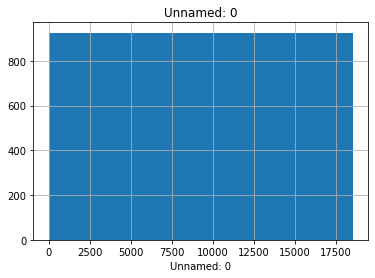

count    18512.000000
mean        12.316659
std          7.690665
min          0.000000
5%           0.000000
10%          1.000000
20%          4.000000
30%          6.000000
40%         10.000000
50%         14.000000
60%         17.000000
70%         19.000000
80%         20.000000
90%         22.000000
95%         23.000000
99%         23.000000
max         23.000000
Name: hour_of_day, dtype: float64



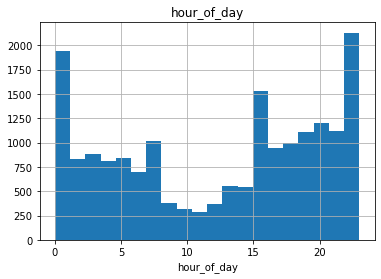

count    18512.000000
mean      1169.814248
std        818.455239
min         15.710000
5%         234.943000
10%        309.092000
20%        363.822000
30%        372.620000
40%        946.178000
50%       1165.795000
60%       1368.390000
70%       1438.764000
80%       1696.596000
90%       2180.891000
95%       2494.096500
99%       3939.923100
max       4978.650000
Name: register__sales_dollar_amt_this_hour, dtype: float64



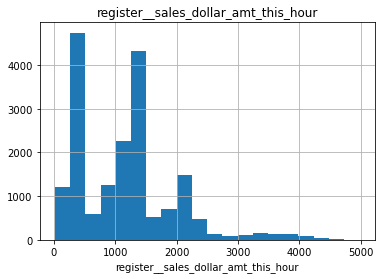

count    18512.000000
mean         0.002944
std          1.007499
min         -0.985800
5%          -0.738300
10%         -0.675700
20%         -0.624100
30%         -0.624100
40%         -0.559400
50%         -0.335700
60%          0.051900
70%          0.308400
80%          0.474200
90%          0.648300
95%          1.007600
99%          5.623500
max          6.021600
Name: register__peak_sales_dollar_amt_per_hour, dtype: float64



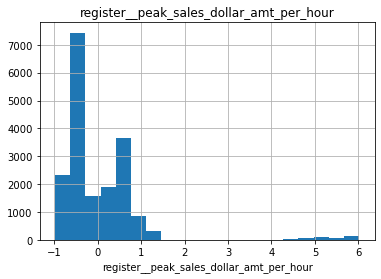

count    18512.000000
mean         0.000513
std          1.119465
min         -0.127000
5%          -0.127000
10%         -0.127000
20%         -0.126900
30%         -0.126500
40%         -0.125900
50%         -0.125000
60%         -0.122100
70%         -0.114530
80%         -0.026020
90%          0.317720
95%          0.692070
99%          1.281712
max        146.352200
Name: register__sales_dollar_amt_last_hour, dtype: float64



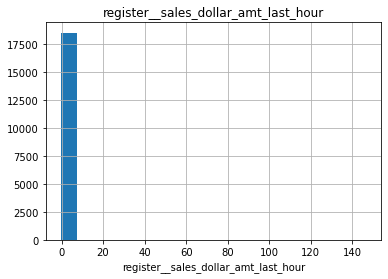

count    18512.000000
mean         0.001174
std          1.113356
min         -0.199400
5%          -0.199000
10%         -0.198800
20%         -0.198200
30%         -0.196200
40%         -0.177300
50%         -0.168600
60%         -0.134700
70%         -0.066530
80%          0.044580
90%          0.416630
95%          0.725545
99%          1.953151
max        141.513200
Name: register__sales_quantity_last_hour, dtype: float64



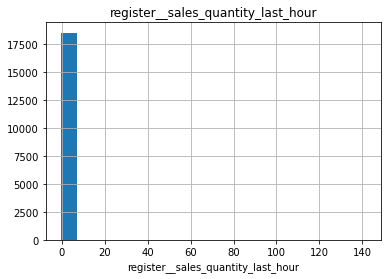

count    18512.000000
mean        -0.014366
std          0.988478
min         -0.829900
5%          -0.829900
10%         -0.822800
20%         -0.788300
30%         -0.736870
40%         -0.595060
50%         -0.368350
60%         -0.162400
70%          0.136370
80%          0.679960
90%          1.504390
95%          2.035480
99%          3.203587
max          7.850300
Name: register__sales_quantity_rescanned_frac, dtype: float64



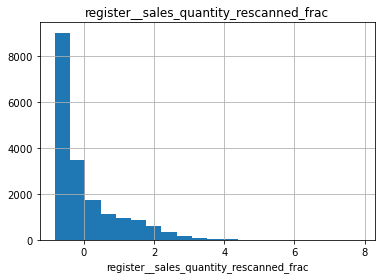

count    18512.000000
mean         0.001537
std          1.037091
min         -0.124700
5%          -0.124700
10%         -0.124700
20%         -0.124700
30%         -0.124700
40%         -0.124700
50%         -0.124700
60%         -0.124700
70%         -0.124700
80%         -0.121100
90%         -0.040100
95%          0.290600
99%          2.699953
max         55.379800
Name: register__sales_payments_declined_frac, dtype: float64



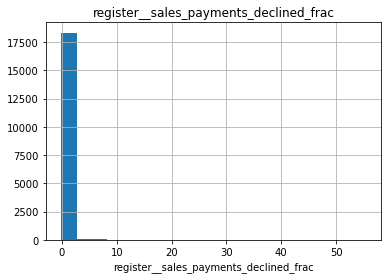

count    18512.000000
mean         0.006712
std          1.010382
min         -0.585200
5%          -0.572100
10%         -0.525100
20%         -0.525100
30%         -0.525100
40%         -0.525100
50%         -0.525100
60%         -0.135100
70%         -0.135100
80%          0.457100
90%          0.979500
95%          1.294300
99%          5.686500
max          5.686500
Name: register__peak_returns_dollar_amt_per_hour, dtype: float64



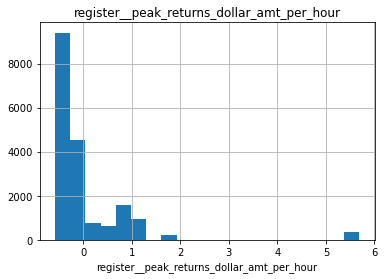

count    18512.000000
mean         0.003119
std          1.107004
min         -0.258200
5%          -0.258200
10%         -0.258100
20%         -0.258100
30%         -0.257800
40%         -0.252800
50%         -0.247500
60%         -0.217400
70%         -0.072430
80%          0.195280
90%          0.779400
95%          0.847400
99%          1.755367
max        136.491200
Name: register__returns_dollar_amt_last_hour, dtype: float64



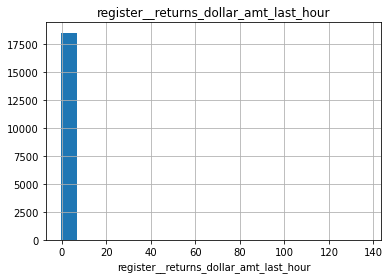

count    18512.000000
mean         0.002602
std          1.110886
min         -0.262100
5%          -0.261600
10%         -0.261100
20%         -0.259600
30%         -0.256700
40%         -0.236200
50%         -0.204700
60%         -0.173700
70%         -0.045300
80%          0.207700
90%          0.665180
95%          0.827990
99%          1.573078
max        139.600000
Name: register__returns_quantity_last_hour, dtype: float64



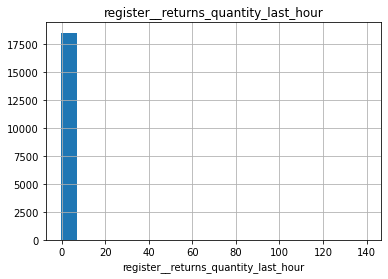

count    18512.000000
mean        -0.024150
std          0.960737
min         -0.533700
5%          -0.533700
10%         -0.533700
20%         -0.529300
30%         -0.518300
40%         -0.481360
50%         -0.398200
60%         -0.302600
70%         -0.176100
80%          0.107600
90%          1.017590
95%          2.317080
99%          4.114368
max          9.693300
Name: register__returns_quantity_rescanned_frac, dtype: float64



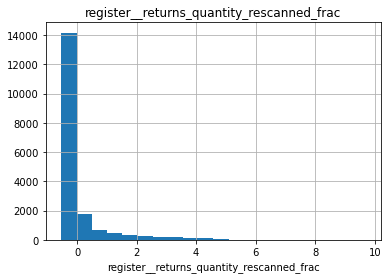

count    18512.000000
mean         0.005945
std          0.992792
min         -0.718300
5%          -0.707300
10%         -0.691190
20%         -0.645900
30%         -0.577300
40%         -0.481200
50%         -0.347400
60%         -0.198440
70%          0.009870
80%          0.319760
90%          1.263020
95%          1.943000
99%          4.468012
max          4.700100
Name: cashier__hours_into_shift, dtype: float64



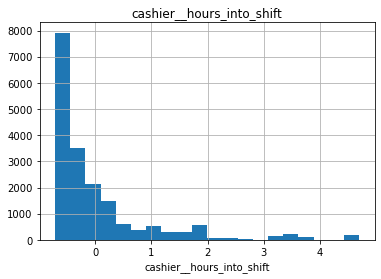

count    18512.000000
mean        -0.001230
std          1.007069
min         -3.618100
5%          -1.763400
10%         -1.557300
20%         -1.145200
30%         -0.320900
40%         -0.114800
50%          0.091300
60%          0.400400
70%          0.812500
80%          0.915600
90%          1.121700
95%          1.121700
99%          1.946000
max          3.491600
Name: cashier__item_scan_rate_per_min, dtype: float64



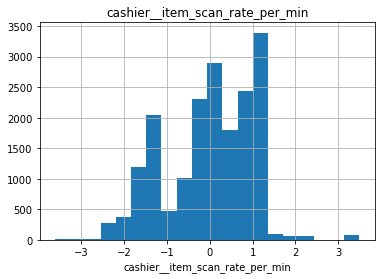

count    18512.000000
mean        -0.001449
std          1.008924
min         -6.931000
5%          -2.136700
10%         -1.407100
20%         -0.990200
30%         -0.260700
40%          0.156200
50%          0.260500
60%          0.468900
70%          0.677300
80%          0.885800
90%          0.990000
95%          0.990000
99%          1.719600
max          2.866000
Name: cashier__item_manual_entry_rate_per_min, dtype: float64



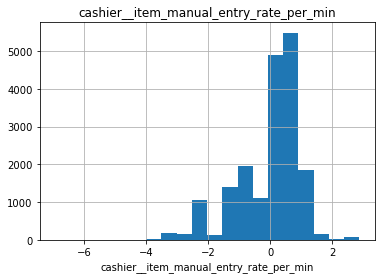

count    18512.000000
mean         0.030023
std          0.977420
min         -2.652400
5%          -2.134200
10%         -2.134200
20%          0.197300
30%          0.197300
40%          0.197300
50%          0.197300
60%          0.456400
70%          0.456400
80%          0.715500
90%          0.974500
95%          0.974500
99%          0.974500
max          1.492700
Name: store__miles_to_nearest_location, dtype: float64



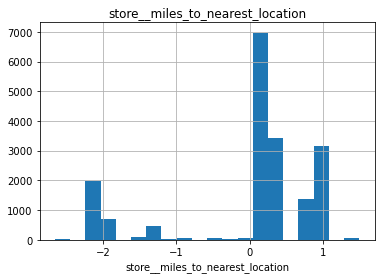

count    18512.000000
mean        -0.022675
std          0.917017
min         -7.104400
5%          -0.300100
10%         -0.242400
20%         -0.197900
30%         -0.169100
40%         -0.064700
50%          0.001900
60%          0.037500
70%          0.057400
80%          0.077400
90%          0.090800
95%          0.104100
99%          0.104100
max         15.447100
Name: store__target_sales_quantity_per_hour, dtype: float64



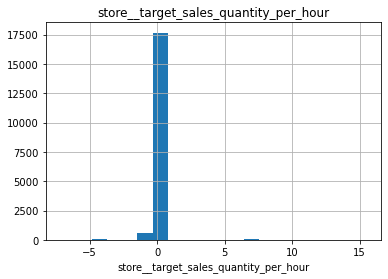

count    18512.000000
mean         0.000694
std          1.009366
min         -1.629600
5%          -0.923100
10%         -0.923100
20%         -0.923100
30%         -0.923100
40%         -0.569900
50%         -0.216600
60%          0.489900
70%          0.489900
80%          0.843200
90%          1.196400
95%          1.549700
99%          2.609500
max         22.391900
Name: store__mean_customer_to_staff_ratio, dtype: float64



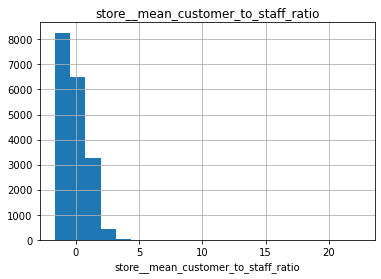

count    18512.000000
mean         0.016124
std          1.002453
min         -1.220600
5%          -1.107300
10%         -1.058990
20%         -0.764100
30%         -0.303170
40%         -0.155460
50%         -0.042050
60%          0.156480
70%          0.287600
80%          0.436460
90%          0.664300
95%          1.118445
99%          4.020235
max         24.922100
Name: store__mean_service_time_per_customer, dtype: float64



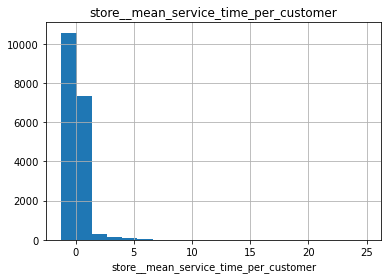

count    18512.000000
mean         0.002485
std          1.004449
min         -0.938100
5%          -0.938100
10%         -0.938100
20%         -0.365700
30%         -0.365700
40%         -0.365700
50%         -0.365700
60%         -0.365700
70%          0.206800
80%          0.206800
90%          0.206800
95%          1.924300
99%          4.214200
max          4.786700
Name: store__n_managers, dtype: float64



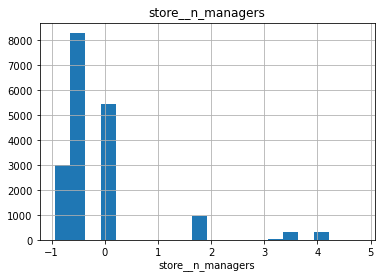

count    18512.000000
mean         0.014078
std          1.006427
min         -0.753600
5%          -0.753600
10%         -0.753600
20%         -0.753600
30%         -0.579600
40%         -0.579600
50%         -0.405700
60%         -0.057800
70%          0.116100
80%          0.464000
90%          1.159700
95%          2.725000
99%          3.594700
max          3.768600
Name: store__n_open_registers, dtype: float64



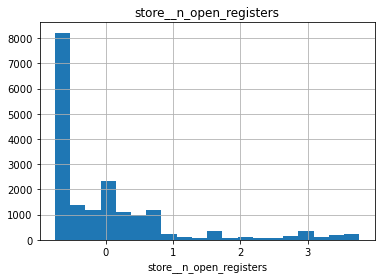

count    18512.000000
mean         0.002835
std          1.003090
min         -0.646300
5%          -0.645700
10%         -0.644400
20%         -0.641500
30%         -0.622500
40%         -0.571860
50%         -0.534700
60%         -0.441000
70%         -0.206860
80%          0.790000
90%          1.945390
95%          2.250490
99%          2.502234
max          8.148100
Name: store__occupancy_main_floor, dtype: float64



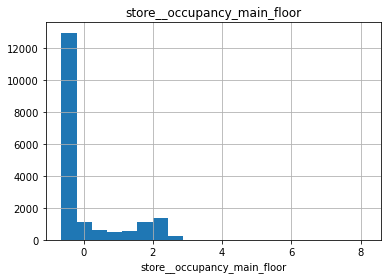

count    18512.000000
mean         0.005949
std          0.997506
min         -0.849200
5%          -0.797600
10%         -0.730700
20%         -0.657080
30%         -0.598900
40%         -0.480060
50%         -0.403650
60%         -0.231480
70%          0.036670
80%          0.542480
90%          1.399550
95%          2.282035
99%          3.186740
max         10.782800
Name: store__occupancy_grocery, dtype: float64



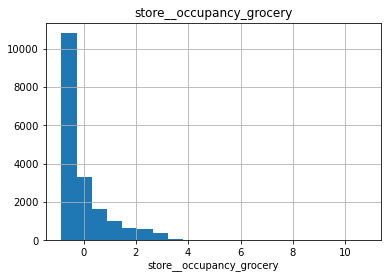

count    18512.000000
mean        -0.026494
std          0.967587
min         -0.438600
5%          -0.438600
10%         -0.438600
20%         -0.438600
30%         -0.438600
40%         -0.436200
50%         -0.346700
60%         -0.225640
70%         -0.066100
80%          0.143660
90%          0.500490
95%          1.302170
99%          4.077979
max         13.518900
Name: store__occupancy_checkout_areas, dtype: float64



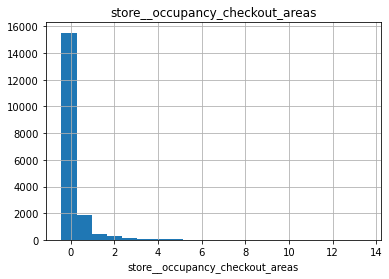

count    18512.000000
mean        -0.000883
std          0.995046
min         -0.884100
5%          -0.876000
10%         -0.866690
20%         -0.772600
30%         -0.599820
40%         -0.439000
50%         -0.286500
60%         -0.096100
70%          0.164170
80%          0.557200
90%          1.169760
95%          1.828675
99%          3.732626
max         13.203600
Name: store__occupancy_food_court, dtype: float64



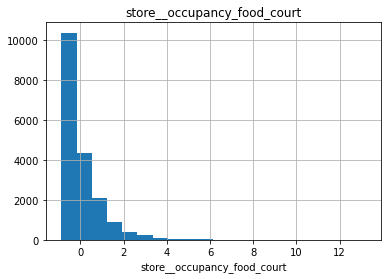

count    18512.000000
mean        -0.004780
std          0.994366
min         -0.181200
5%          -0.181200
10%         -0.181100
20%         -0.173200
30%         -0.158370
40%         -0.137500
50%         -0.113800
60%         -0.078440
70%         -0.033500
80%          0.041580
90%          0.177100
95%          0.306135
99%          0.725836
max         44.415900
Name: store__occupancy_backrooms, dtype: float64



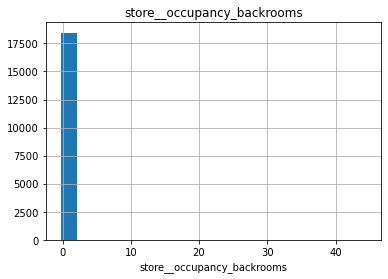

count    18512.000000
mean        -0.002356
std          1.002190
min         -1.006300
5%          -0.963345
10%         -0.904990
20%         -0.842900
30%         -0.714600
40%         -0.577760
50%         -0.372300
60%         -0.099240
70%          0.262270
80%          0.772960
90%          1.579840
95%          2.222445
99%          2.774856
max          5.224300
Name: store__occupancy_indoors, dtype: float64



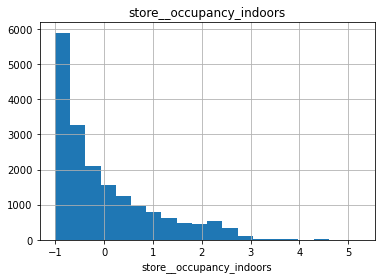

count    18512.000000
mean        -0.021494
std          0.981435
min         -0.708700
5%          -0.702700
10%         -0.686090
20%         -0.612000
30%         -0.519400
40%         -0.406900
50%         -0.257100
60%         -0.110300
70%          0.044510
80%          0.248300
90%          0.721370
95%          1.457390
99%          4.140904
max         15.654700
Name: store__occupancy_outdoors, dtype: float64



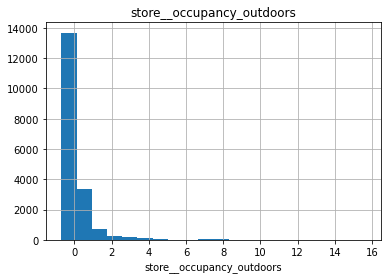

count    18512.000000
mean        -0.030302
std          0.986377
min         -2.279700
5%          -1.501700
10%         -1.210000
20%         -1.015500
30%         -0.723700
40%         -0.334800
50%          0.012800
60%          0.230700
70%          0.448500
80%          0.775200
90%          1.123800
95%          1.610000
99%          2.300200
max          5.013600
Name: store__outdoor_temperature, dtype: float64



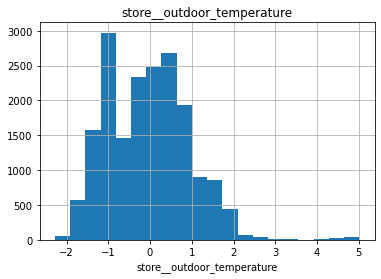

count    18512.000000
mean        -0.023004
std          0.996865
min         -1.224200
5%          -1.107000
10%         -1.087090
20%         -1.053200
30%         -1.039200
40%         -1.011020
50%          0.064300
60%          0.892420
70%          0.944270
80%          1.008380
90%          1.179080
95%          1.257100
99%          1.298778
max          3.090800
Name: store__parking_lot_utilization, dtype: float64



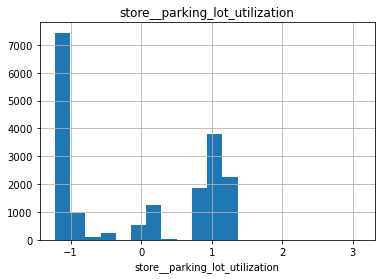

count    18512.000000
mean        -0.030949
std          0.984071
min         -4.926500
5%          -1.558900
10%         -1.429300
20%         -0.652200
30%         -0.263600
40%         -0.263600
50%         -0.134100
60%          0.254500
70%          0.384000
80%          0.772600
90%          0.902100
95%          1.161200
99%          2.586000
max          7.248900
Name: store__shelf_freespace_frac, dtype: float64



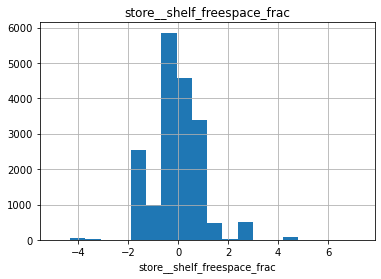

count    18512.000000
mean        -0.010074
std          0.996157
min         -1.180400
5%          -1.104400
10%         -1.034500
20%         -0.760860
30%         -0.429100
40%         -0.315900
50%         -0.215300
60%         -0.075740
70%          0.101770
80%          0.347740
90%          1.009070
95%          1.632290
99%          2.825689
max          6.721000
Name: store__hrs_since_last_delivery, dtype: float64



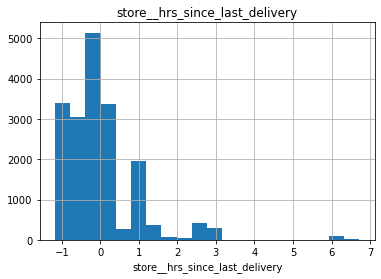

count    18512.000000
mean         0.002377
std          1.011207
min         -0.549300
5%          -0.549200
10%         -0.549100
20%         -0.548900
30%         -0.546100
40%         -0.534500
50%         -0.520000
60%         -0.461300
70%         -0.134030
80%          0.424300
90%          1.707080
95%          1.896745
99%          3.825091
max         14.652900
Name: store__sales_dollar_amt_last_hour, dtype: float64



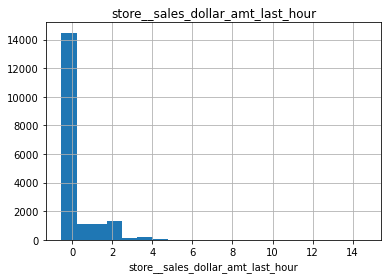

count    18512.000000
mean         0.002736
std          1.012666
min         -0.595900
5%          -0.595300
10%         -0.594600
20%         -0.593200
30%         -0.580800
40%         -0.536760
50%         -0.501950
60%         -0.382900
70%         -0.124130
80%          0.440460
90%          1.599170
95%          1.983425
99%          3.788726
max         12.342400
Name: store__sales_quantity_last_hour, dtype: float64



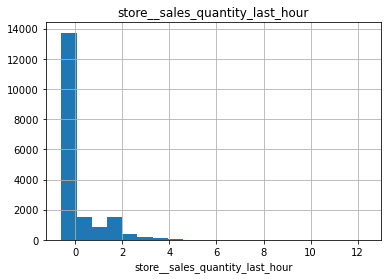

count    18512.000000
mean         0.000494
std          1.103591
min         -0.012400
5%          -0.012400
10%         -0.012400
20%         -0.012400
30%         -0.012400
40%         -0.012400
50%         -0.012400
60%         -0.012400
70%         -0.012400
80%         -0.012400
90%         -0.012400
95%         -0.012400
99%         -0.012400
max        147.513500
Name: store__sales_quantity_rescanned_frac, dtype: float64



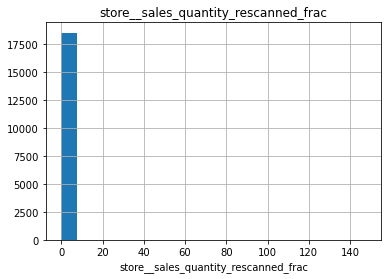

count    18512.000000
mean        -0.027451
std          0.975194
min         -0.411900
5%          -0.411900
10%         -0.411900
20%         -0.411900
30%         -0.410400
40%         -0.406500
50%         -0.378500
60%         -0.207500
70%         -0.068100
80%          0.094100
90%          0.530600
95%          1.319100
99%          3.098242
max         12.663500
Name: store__gift_sales_quantity_last_hour, dtype: float64



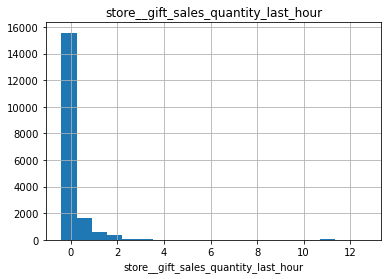

count    18512.000000
mean        -0.001778
std          1.006207
min         -0.434500
5%          -0.434400
10%         -0.434200
20%         -0.433400
30%         -0.431200
40%         -0.426800
50%         -0.413200
60%         -0.369340
70%         -0.213400
80%          0.082680
90%          1.028760
95%          2.136490
99%          3.944368
max         18.339500
Name: store__returns_dollar_amt_last_hour, dtype: float64



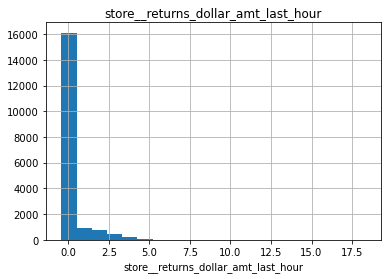

count    18512.000000
mean        -0.000283
std          1.011181
min         -0.547700
5%          -0.546200
10%         -0.545100
20%         -0.541200
30%         -0.517000
40%         -0.471800
50%         -0.397400
60%         -0.268340
70%         -0.098660
80%          0.225760
90%          1.079770
95%          1.800850
99%          4.828692
max         15.099000
Name: store__returns_quantity_last_hour, dtype: float64



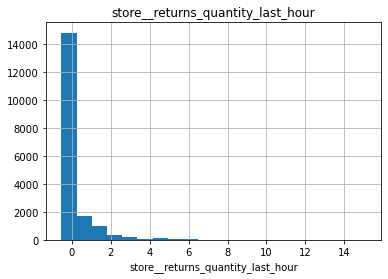

count    18512.000000
mean         0.006926
std          1.009954
min         -0.330100
5%          -0.330100
10%         -0.330100
20%         -0.330100
30%         -0.330100
40%         -0.330100
50%         -0.329300
60%         -0.324000
70%         -0.300930
80%         -0.209400
90%          0.451790
95%          2.565690
99%          4.774067
max          5.343800
Name: store__returns_quantity_rescanned_frac, dtype: float64



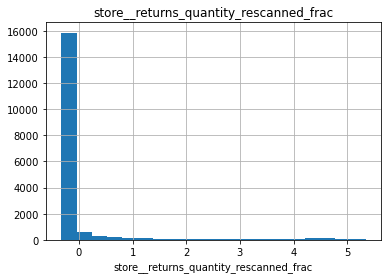

count    18512.000000
mean        -0.004067
std          0.971675
min         -0.294800
5%          -0.294800
10%         -0.294800
20%         -0.294800
30%         -0.284700
40%         -0.264500
50%         -0.219100
60%         -0.153600
70%         -0.062800
80%          0.088500
90%          0.325600
95%          0.835100
99%          3.185600
max         33.712100
Name: store__gift_returns_quantity_last_hour, dtype: float64



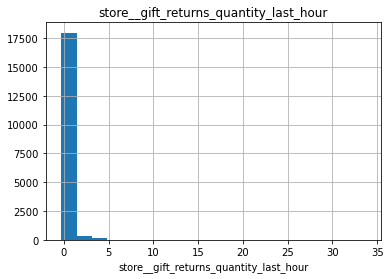

count    18512.000000
mean         0.014392
std          1.010495
min         -0.783400
5%          -0.783400
10%         -0.759900
20%         -0.759900
30%         -0.759900
40%         -0.736400
50%         -0.665800
60%         -0.383800
70%          1.496800
80%          1.496800
90%          1.496800
95%          1.496800
99%          1.496800
max          5.234400
Name: region__n_stores, dtype: float64



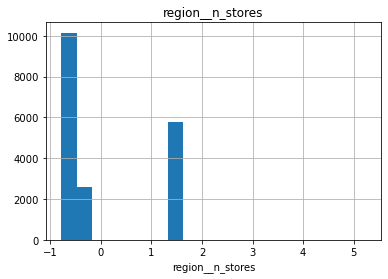

count    18512.000000
mean         0.017364
std          1.008064
min         -0.725700
5%          -0.722000
10%         -0.722000
20%         -0.718400
30%         -0.678200
40%         -0.641600
50%         -0.616000
60%         -0.597800
70%          1.047200
80%          1.379900
90%          1.613800
95%          1.814900
99%          2.058997
max          2.505800
Name: region__n_open_registers, dtype: float64



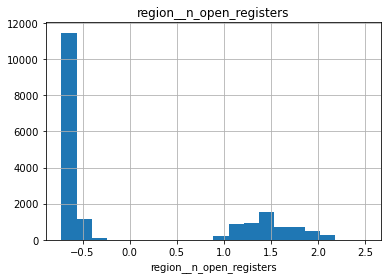

count    18512.000000
mean         0.020981
std          0.991513
min         -1.274300
5%          -1.258000
10%         -1.234100
20%         -0.789800
30%         -0.342500
40%         -0.280000
50%         -0.232600
60%         -0.128700
70%          0.455260
80%          0.886600
90%          1.126400
95%          1.751000
99%          3.204400
max         15.733500
Name: region__mean_service_time_per_customer, dtype: float64



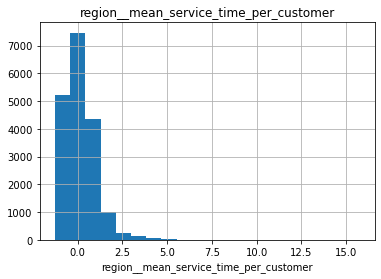

count    18512.000000
mean         0.006291
std          0.997525
min         -0.521400
5%          -0.491600
10%         -0.484000
20%         -0.480100
30%         -0.461000
40%         -0.451180
50%         -0.430300
60%         -0.323600
70%          0.017100
80%          0.214100
90%          0.557300
95%          2.175400
99%          4.599900
max          6.108400
Name: region__stdev_service_time_per_customer, dtype: float64



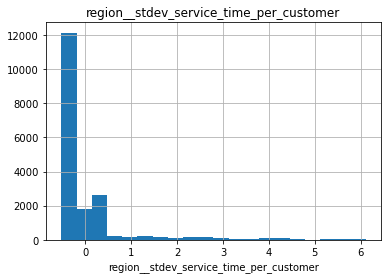

count    18512.000000
mean         0.017787
std          1.015479
min         -0.693400
5%          -0.679500
10%         -0.661000
20%         -0.651900
30%         -0.647500
40%         -0.560740
50%         -0.458600
60%         -0.399600
70%         -0.033700
80%          1.044900
90%          1.582100
95%          2.011000
99%          2.437100
max          9.338400
Name: region__sales_dollar_amt_last_hour, dtype: float64



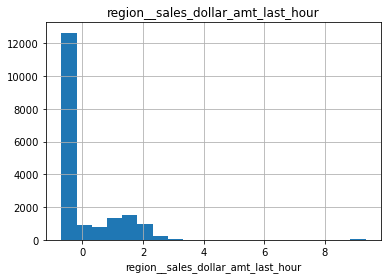

count    18512.000000
mean         0.006959
std          1.039629
min         -0.461800
5%          -0.456900
10%         -0.443900
20%         -0.442200
30%         -0.440500
40%         -0.327900
50%         -0.229500
60%         -0.035400
70%          0.227900
80%          0.379980
90%          0.628760
95%          0.844700
99%          1.313400
max         19.881600
Name: region__returns_dollar_amt_last_hour, dtype: float64



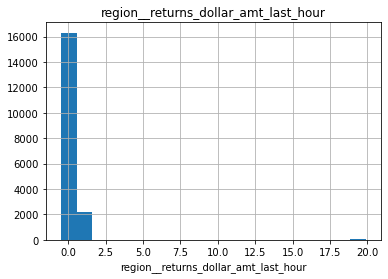

count    18512.00000
mean         0.01484
std          1.00561
min         -0.64980
5%          -0.64980
10%         -0.64980
20%         -0.64980
30%         -0.60400
40%         -0.59250
50%         -0.55810
60%         -0.51800
70%          0.34740
80%          0.65690
90%          2.08960
95%          2.13550
99%          2.16990
max          2.16990
Name: region__nighttime_open_registers, dtype: float64



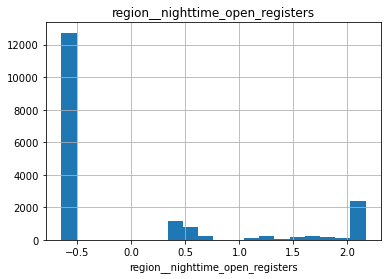

count    18512.000000
mean         0.021682
std          0.978837
min         -1.422900
5%          -1.409700
10%         -1.409400
20%         -1.006500
30%         -0.714800
40%          0.044800
50%          0.047700
60%          0.050200
70%          0.886700
80%          0.896600
90%          0.956000
95%          1.520500
99%          1.608800
max         11.537500
Name: region__nighttime_service_time_per_customer, dtype: float64



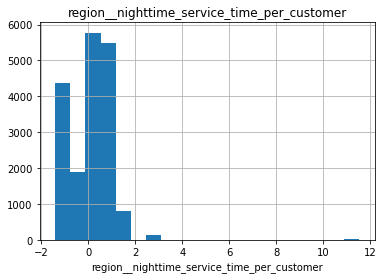

count    18512.000000
mean         0.018446
std          1.007041
min         -0.649300
5%          -0.649300
10%         -0.649300
20%         -0.649300
30%         -0.648700
40%         -0.647800
50%         -0.647100
60%         -0.646100
70%          0.914600
80%          1.574500
90%          1.683100
95%          1.769900
99%          1.827500
max          1.827500
Name: region__nighttime_sales_amt_per_hour, dtype: float64



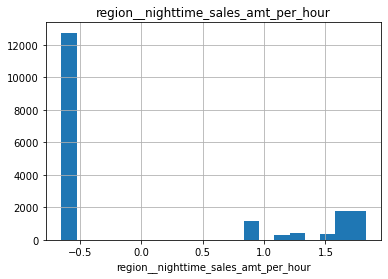

count    18512.000000
mean         0.015523
std          1.005561
min         -0.610600
5%          -0.610600
10%         -0.610600
20%         -0.610600
30%         -0.609100
40%         -0.608100
50%         -0.603700
60%         -0.603100
70%          0.328000
80%          0.903000
90%          1.989600
95%          2.051300
99%          2.068900
max          2.068900
Name: region__nighttime_returns_amt_per_hour, dtype: float64



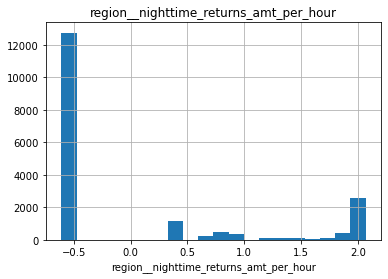

count    18512.000000
mean        -0.019027
std          0.996364
min         -2.259200
5%          -1.977900
10%         -1.977900
20%         -0.539400
30%         -0.173300
40%          0.033200
50%          0.033200
60%          0.128800
70%          0.440000
80%          0.499800
90%          1.002000
95%          1.933700
99%          2.431500
max          3.614100
Name: region__peak_sales_dollar_amt_per_hour, dtype: float64



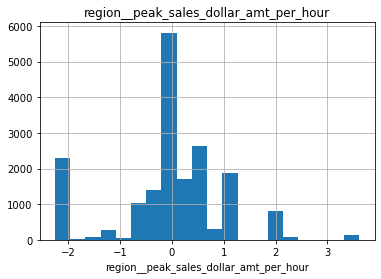

count    18512.000000
mean         0.022354
std          0.998245
min         -0.981600
5%          -0.981600
10%         -0.981600
20%         -0.981600
30%         -0.909300
40%         -0.909300
50%          0.022354
60%          0.174800
70%          1.379500
80%          1.379500
90%          1.379500
95%          1.379500
99%          1.379500
max          1.379500
Name: region__peak_sales_dollar_amt_per_hour_v2, dtype: float64



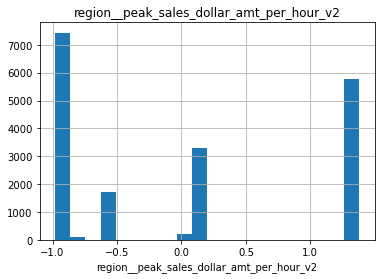

count    18512.000000
mean         0.008615
std          1.008285
min         -2.337000
5%          -1.795100
10%         -1.795100
20%         -0.363000
30%         -0.348900
40%         -0.348900
50%         -0.308000
60%         -0.131100
70%          0.516000
80%          0.893900
90%          1.115000
95%          1.729000
99%          2.404600
max          2.404600
Name: region__peak_returns_dollar_amt_per_hour, dtype: float64



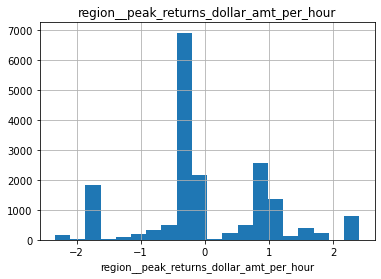

count    18512.000000
mean         0.019324
std          0.953223
min         -0.861400
5%          -0.861400
10%         -0.861400
20%         -0.861400
30%         -0.828400
40%         -0.756700
50%         -0.756700
60%          0.019324
70%          1.338200
80%          1.338200
90%          1.338200
95%          1.338200
99%          1.338200
max          1.338200
Name: region__peak_returns_dollar_amt_per_hour_v2, dtype: float64



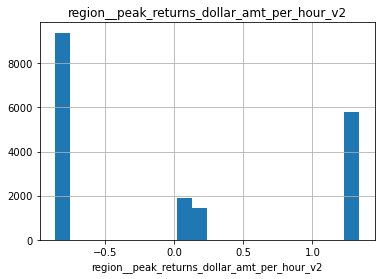

In [9]:
for col in num_col:
    num_summary(df_train,col,True)

# Categorical Features Analysis

                   register__payment_types_accepted      Ratio
Cash+Credit                                   16310  88.105013
Cash+Credit+Check                              2133  11.522256
Credit                                           69   0.372731
##########################################


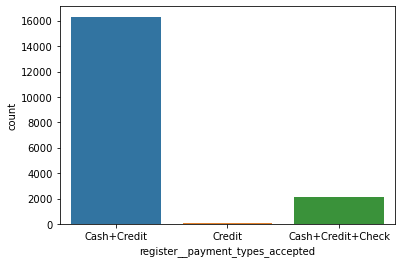

   store__type_code      Ratio
A             11691  63.153630
C              5637  30.450519
B               861   4.651037
D               316   1.707001
F                 5   0.027010
E                 2   0.010804
##########################################


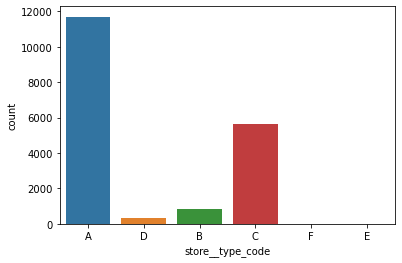

         cashier__title_level      Ratio
-0.3520                 14373  77.641530
 1.8996                  3509  18.955272
-2.6036                   630   3.403198
##########################################


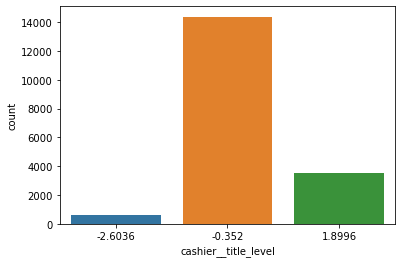

         cashier__n_years_experience      Ratio
-0.7454                         9957  53.786733
 1.0463                         7900  42.675022
-2.5371                          573   3.095290
 2.8380                           82   0.442956
##########################################


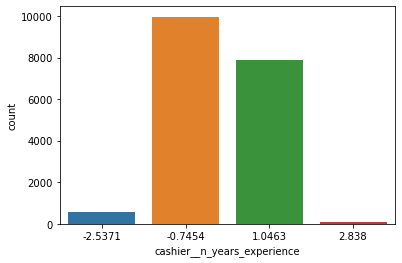

         store__n_employees_total      Ratio
-0.2960                      6780  36.624892
 0.9549                      6699  36.187338
 0.0580                      1988  10.738980
-1.3581                       978   5.283060
-2.9041                       873   4.715860
-1.4997                       865   4.672645
 1.3797                       320   1.728608
-0.5084                         9   0.048617
##########################################


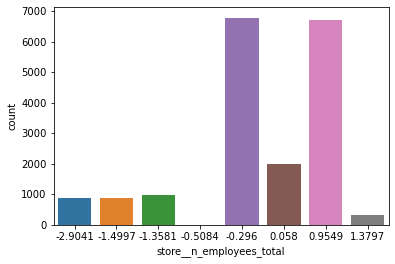

         store__n_baggers      Ratio
-0.6371              8934  48.260588
 0.1657              7792  42.091616
 1.7712              1352   7.303371
 4.9823               434   2.344425
##########################################


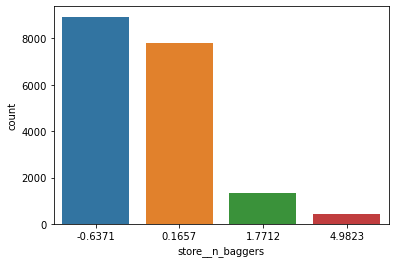

         store__is_sufficiently_staffed      Ratio
-0.3909                           16335  88.240061
 2.5582                            2177  11.759939
##########################################


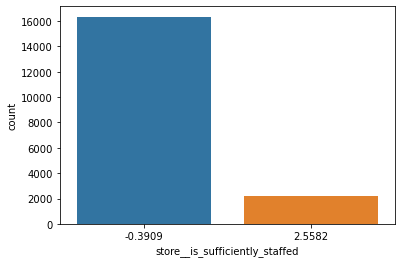

In [10]:
for col in cat_col:
    cat_summary(df_train,col,True)

# Outliers analysis

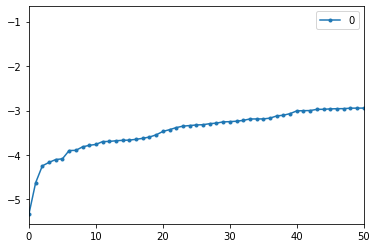

array([-1.21550419, -1.09557627, -1.30107466, ..., -1.62736996,
       -3.24101575, -1.02865962])

In [11]:
LOF(df_train,num_col)

In [12]:
for col in num_col:
    print(col,check_outlier(df_train,col,q1=0.01,q3=0.99))

Unnamed: 0 False
hour_of_day False
register__sales_dollar_amt_this_hour False
register__peak_sales_dollar_amt_per_hour False
register__sales_dollar_amt_last_hour True
register__sales_quantity_last_hour True
register__sales_quantity_rescanned_frac False
register__sales_payments_declined_frac True
register__peak_returns_dollar_amt_per_hour False
register__returns_dollar_amt_last_hour True
register__returns_quantity_last_hour True
register__returns_quantity_rescanned_frac False
cashier__hours_into_shift False
cashier__item_scan_rate_per_min False
cashier__item_manual_entry_rate_per_min False
store__miles_to_nearest_location False
store__target_sales_quantity_per_hour True
store__mean_customer_to_staff_ratio True
store__mean_service_time_per_customer True
store__n_managers False
store__n_open_registers False
store__occupancy_main_floor True
store__occupancy_grocery True
store__occupancy_checkout_areas True
store__occupancy_food_court True
store__occupancy_backrooms True
store__occupancy_in

# Correlation analysis

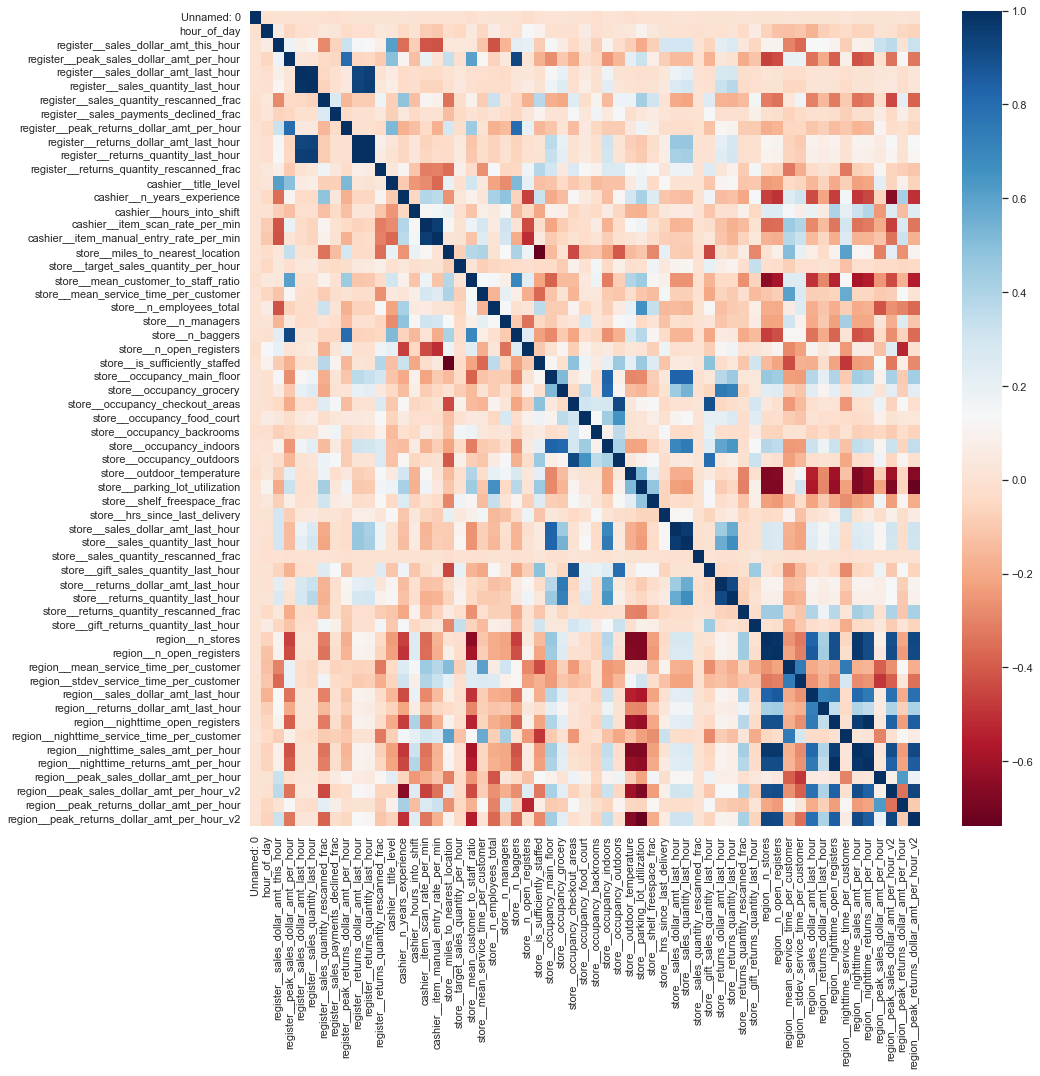

['register__sales_quantity_last_hour',
 'register__returns_dollar_amt_last_hour',
 'register__returns_quantity_last_hour',
 'cashier__item_manual_entry_rate_per_min',
 'store__n_baggers',
 'store__occupancy_outdoors',
 'store__sales_quantity_last_hour',
 'store__returns_quantity_last_hour',
 'region__n_open_registers',
 'region__nighttime_sales_amt_per_hour',
 'region__nighttime_returns_amt_per_hour',
 'region__peak_sales_dollar_amt_per_hour_v2',
 'region__peak_returns_dollar_amt_per_hour_v2']

In [13]:
high_correlated_cols(df_train,plot=True)

# features importance 

In [14]:
df_train = pd.read_csv('training_dataset.csv')

In [15]:
df_train['label'] = 1
df_test['label'] = 0

In [16]:
df = pd.concat([df_train,df_test])

In [17]:
label = "label"

In [18]:
except_cols=['observation_id','observation_timestamp','Unnamed: 0',target]

In [19]:
X = df.drop(labels = except_cols + [label], axis=1)
y = df[label]

In [20]:
cat_col, num_col, cat_but_col = grab_col_names(X)

Observations: 23691
Variables: 59
cat_cols: 7
num_cols: 52
cat_but_car: 0
num_but_cat: 5


In [21]:
for col in cat_col:
    X[col] = X[col].astype(str).astype("O")

In [22]:
def lets_gamble(x_data, y_data):
    cat = CatBoostClassifier(cat_features=cat_col, iterations = 50, verbose=0)
    cat.fit(x_data, y_data)
    preds = cat.predict(x_data)
    score = roc_auc_score(y,preds)
    
    print("ROC-AUC Score:", score)
    
    feature_importance = cat.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 18))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
    plt.title('Feature Importance')

ROC-AUC Score: 0.5723233197510122


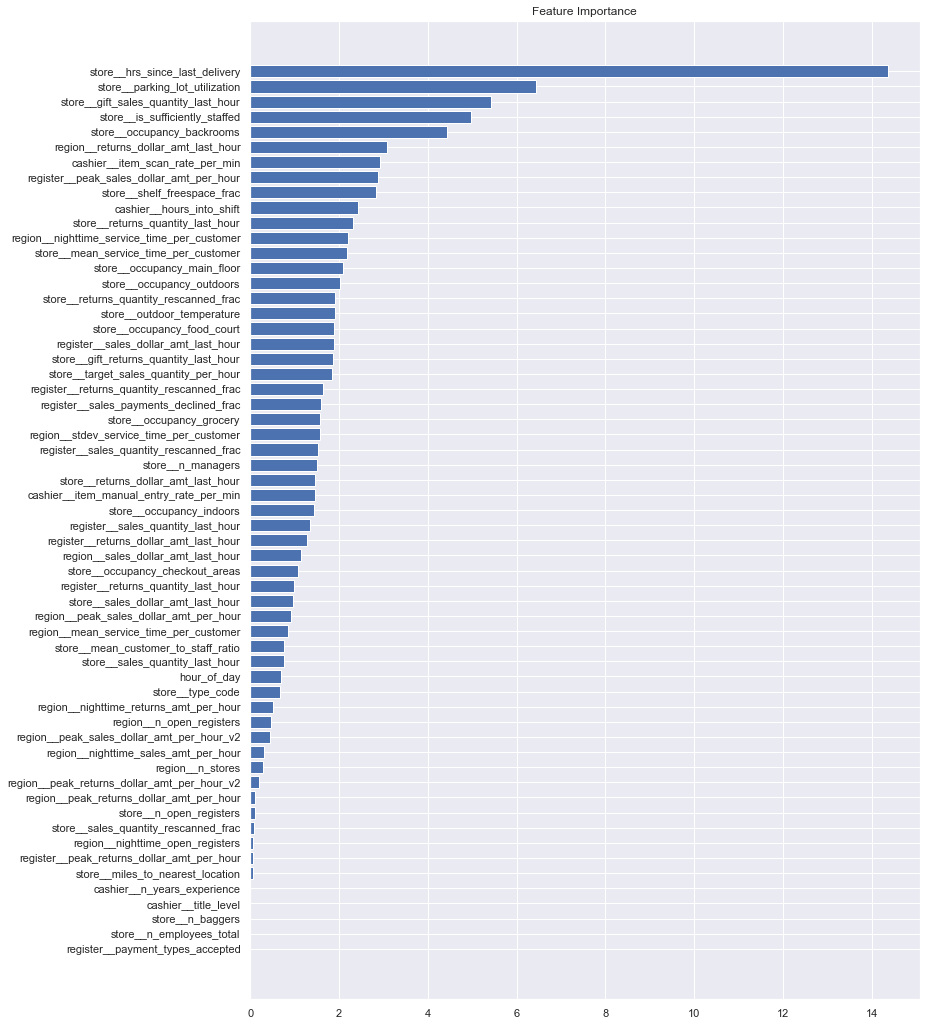

In [23]:
lets_gamble(X,y)

# MODEL

In [5]:
df_train = pd.read_csv('training_dataset.csv')
df_test= pd.read_csv('test_dataset.csv')

In [6]:
target = 'register__sales_dollar_amt_this_hour'

In [7]:
df_train.loc[((df_train['hour_of_day']>=18)&(df_train['hour_of_day']<=23))|
            ((df_train['hour_of_day']>=0)&(df_train['hour_of_day']<=6)),'part_of_day'] ='night'

df_train.loc[(df_train['hour_of_day']>=7)&(df_train['hour_of_day']<=17),'part_of_day'] ='day'


In [8]:
df_train.drop(['observation_timestamp','Unnamed: 0','observation_id',
              'region__peak_sales_dollar_amt_per_hour_v2',
               'region__peak_returns_dollar_amt_per_hour_v2'],axis=1,inplace=True)

In [9]:
cat_col,num_col,cat_but_car=grab_col_names(df_train)

Observations: 18512
Variables: 59
cat_cols: 8
num_cols: 51
cat_but_car: 0
num_but_cat: 5


In [10]:
df_train = one_hot_encoder(df_train,cat_col,True)

In [11]:
X = df_train.drop(target,axis=1)
y = df_train[target]

In [12]:
def objective(trial, X, y):
    param_grid = {

        'metric': ['rmse'],
        'verbose': -5,
        'boosting_type': 'gbdt',
        'force_row_wise': True,
        'max_depth':15,
        'min_child_samples' : 36,
        'bagging_fraction': 0.865952560845951,


        'learning_rate':trial.suggest_discrete_uniform("learning_rate", 0.01, 0.04, 0.001),
        'n_estimators' : trial.suggest_int('n_estimators',200, 250,5),

        'max_bin': trial.suggest_int('max_bin', 325, 375,5),
        'num_leaves': trial.suggest_int('num_leaves', 164, 268,4),

        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.000002, 0.000005),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 3, 5),

        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0.7),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 7),

        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 15),

        'sub_feature': trial.suggest_uniform('sub_feature', 0.1, 0.2),
        'sub_row': trial.suggest_uniform('sub_row', 0.8, 0.9),
        
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 200000, 300000,100)
    }

    cv = KFold(n_splits=10, shuffle=True, random_state=17)

    cv_scores = np.empty(10)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMRegressor(objective="regression", **param_grid,random_state=17,
                              n_jobs=-1)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="root_mean_squared_error",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "rmse")
            ], 
        )
        preds = model.predict(X_test)
        cv_scores[idx] = np.sqrt(mean_squared_error(y_test, preds))

    return np.mean(cv_scores)

In [13]:
%%time
study = optuna.create_study(direction = 'minimize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
func = lambda trial: objective(trial, X, y)

study.optimize(func, n_trials = 50)


[I 2022-09-16 15:36:56,096] A new study created in memory with name: no-name-39536424-427d-4a2b-abf5-f4aad70805a6


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.11815228166105791. Current value: feature_fraction=0.11815228166105791
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8177356628511083. Current value: bagging_fraction=0.8177356628511083
[LightGBM] [Warning] feature_fraction is set=0.5373045846898759, sub_feature=0.11815228166105791 will be ignored. Current value: feature_fraction=0.5373045846898759
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] lambda_l1 is set=4.1816071553868515e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1816071553868515e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8177356628511083 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.885106658686221, reg_lambda=0

[8]	valid_0's rmse: 704.638
[9]	valid_0's rmse: 690.162
[10]	valid_0's rmse: 676.05
[11]	valid_0's rmse: 662.26
[12]	valid_0's rmse: 648.856
[13]	valid_0's rmse: 635.8
[14]	valid_0's rmse: 622.97
[15]	valid_0's rmse: 610.506
[16]	valid_0's rmse: 598.223
[17]	valid_0's rmse: 586.395
[18]	valid_0's rmse: 574.707
[19]	valid_0's rmse: 563.556
[20]	valid_0's rmse: 552.579
[21]	valid_0's rmse: 541.793
[22]	valid_0's rmse: 531.222
[23]	valid_0's rmse: 521.091
[24]	valid_0's rmse: 511.077
[25]	valid_0's rmse: 501.276
[26]	valid_0's rmse: 491.714
[27]	valid_0's rmse: 482.434
[28]	valid_0's rmse: 473.376
[29]	valid_0's rmse: 464.652
[30]	valid_0's rmse: 456.121
[31]	valid_0's rmse: 447.721
[32]	valid_0's rmse: 439.606
[33]	valid_0's rmse: 431.637
[34]	valid_0's rmse: 423.985
[35]	valid_0's rmse: 416.582
[36]	valid_0's rmse: 409.204
[37]	valid_0's rmse: 402.103
[38]	valid_0's rmse: 395.144
[39]	valid_0's rmse: 388.396
[40]	valid_0's rmse: 381.749
[41]	valid_0's rmse: 375.322
[42]	valid_0's rmse: 

[47]	valid_0's rmse: 317.326
[48]	valid_0's rmse: 312.274
[49]	valid_0's rmse: 307.262
[50]	valid_0's rmse: 302.312
[51]	valid_0's rmse: 297.618
[52]	valid_0's rmse: 293.002
[53]	valid_0's rmse: 288.542
[54]	valid_0's rmse: 284.237
[55]	valid_0's rmse: 280.199
[56]	valid_0's rmse: 276.239
[57]	valid_0's rmse: 272.348
[58]	valid_0's rmse: 268.505
[59]	valid_0's rmse: 264.753
[60]	valid_0's rmse: 261.045
[61]	valid_0's rmse: 257.506
[62]	valid_0's rmse: 254.055
[63]	valid_0's rmse: 250.798
[64]	valid_0's rmse: 247.532
[65]	valid_0's rmse: 244.515
[66]	valid_0's rmse: 241.636
[67]	valid_0's rmse: 238.708
[68]	valid_0's rmse: 235.915
[69]	valid_0's rmse: 233.253
[70]	valid_0's rmse: 230.689
[71]	valid_0's rmse: 228.096
[72]	valid_0's rmse: 225.666
[73]	valid_0's rmse: 223.21
[74]	valid_0's rmse: 220.935
[75]	valid_0's rmse: 218.772
[76]	valid_0's rmse: 216.652
[77]	valid_0's rmse: 214.649
[78]	valid_0's rmse: 212.614
[79]	valid_0's rmse: 210.71
[80]	valid_0's rmse: 208.847
[81]	valid_0's r

[85]	valid_0's rmse: 208.377
[86]	valid_0's rmse: 206.848
[87]	valid_0's rmse: 205.28
[88]	valid_0's rmse: 203.937
[89]	valid_0's rmse: 202.534
[90]	valid_0's rmse: 201.158
[91]	valid_0's rmse: 199.812
[92]	valid_0's rmse: 198.559
[93]	valid_0's rmse: 197.367
[94]	valid_0's rmse: 196.162
[95]	valid_0's rmse: 195.076
[96]	valid_0's rmse: 194.029
[97]	valid_0's rmse: 192.912
[98]	valid_0's rmse: 192.076
[99]	valid_0's rmse: 191.181
[100]	valid_0's rmse: 190.313
[101]	valid_0's rmse: 189.329
[102]	valid_0's rmse: 188.434
[103]	valid_0's rmse: 187.556
[104]	valid_0's rmse: 186.68
[105]	valid_0's rmse: 185.813
[106]	valid_0's rmse: 185.118
[107]	valid_0's rmse: 184.472
[108]	valid_0's rmse: 183.84
[109]	valid_0's rmse: 183.287
[110]	valid_0's rmse: 182.708
[111]	valid_0's rmse: 182.14
[112]	valid_0's rmse: 181.569
[113]	valid_0's rmse: 181.068
[114]	valid_0's rmse: 180.63
[115]	valid_0's rmse: 180.045
[116]	valid_0's rmse: 179.499
[117]	valid_0's rmse: 179.002
[118]	valid_0's rmse: 178.586


[115]	valid_0's rmse: 225.017
[116]	valid_0's rmse: 224.605
[117]	valid_0's rmse: 224.19
[118]	valid_0's rmse: 223.714
[119]	valid_0's rmse: 223.419
[120]	valid_0's rmse: 222.986
[121]	valid_0's rmse: 222.567
[122]	valid_0's rmse: 222.312
[123]	valid_0's rmse: 221.896
[124]	valid_0's rmse: 221.616
[125]	valid_0's rmse: 221.412
[126]	valid_0's rmse: 221.226
[127]	valid_0's rmse: 220.943
[128]	valid_0's rmse: 220.671
[129]	valid_0's rmse: 220.335
[130]	valid_0's rmse: 220.116
[131]	valid_0's rmse: 219.761
[132]	valid_0's rmse: 219.655
[133]	valid_0's rmse: 219.587
[134]	valid_0's rmse: 219.503
[135]	valid_0's rmse: 219.236
[136]	valid_0's rmse: 218.977
[137]	valid_0's rmse: 218.775
[138]	valid_0's rmse: 218.467
[139]	valid_0's rmse: 218.176
[140]	valid_0's rmse: 217.952
[141]	valid_0's rmse: 217.85
[142]	valid_0's rmse: 217.783
[143]	valid_0's rmse: 217.858
[144]	valid_0's rmse: 217.88
[145]	valid_0's rmse: 217.743
[146]	valid_0's rmse: 217.77
[147]	valid_0's rmse: 217.66
[148]	valid_0's

[145]	valid_0's rmse: 174.667
[146]	valid_0's rmse: 174.569
[147]	valid_0's rmse: 174.449
[148]	valid_0's rmse: 174.303
[149]	valid_0's rmse: 174.205
[150]	valid_0's rmse: 174.138
[151]	valid_0's rmse: 174.005
[152]	valid_0's rmse: 173.936
[153]	valid_0's rmse: 173.932
[154]	valid_0's rmse: 173.789
[155]	valid_0's rmse: 173.665
[156]	valid_0's rmse: 173.556
[157]	valid_0's rmse: 173.469
[158]	valid_0's rmse: 173.415
[159]	valid_0's rmse: 173.391
[160]	valid_0's rmse: 173.383
[161]	valid_0's rmse: 173.344
[162]	valid_0's rmse: 173.353
[163]	valid_0's rmse: 173.256
[164]	valid_0's rmse: 173.152
[165]	valid_0's rmse: 173.094
[166]	valid_0's rmse: 173.056
[167]	valid_0's rmse: 172.944
[168]	valid_0's rmse: 172.952
[169]	valid_0's rmse: 172.933
[170]	valid_0's rmse: 172.881
[171]	valid_0's rmse: 172.823
[172]	valid_0's rmse: 172.752
[173]	valid_0's rmse: 172.733
[174]	valid_0's rmse: 172.754
[175]	valid_0's rmse: 172.679
[176]	valid_0's rmse: 172.642
[177]	valid_0's rmse: 172.621
[178]	vali

[178]	valid_0's rmse: 170.912
[179]	valid_0's rmse: 170.94
[180]	valid_0's rmse: 170.974
[181]	valid_0's rmse: 170.846
[182]	valid_0's rmse: 170.807
[183]	valid_0's rmse: 170.688
[184]	valid_0's rmse: 170.746
[185]	valid_0's rmse: 170.751
[186]	valid_0's rmse: 170.77
[187]	valid_0's rmse: 170.823
[188]	valid_0's rmse: 170.841
[189]	valid_0's rmse: 170.796
[190]	valid_0's rmse: 170.82
[191]	valid_0's rmse: 170.805
[192]	valid_0's rmse: 170.821
[193]	valid_0's rmse: 170.794
[194]	valid_0's rmse: 170.794
[195]	valid_0's rmse: 170.83
[196]	valid_0's rmse: 170.83
[197]	valid_0's rmse: 170.782
[198]	valid_0's rmse: 170.796
[199]	valid_0's rmse: 170.801
[200]	valid_0's rmse: 170.87
[201]	valid_0's rmse: 170.839
[202]	valid_0's rmse: 170.847
[203]	valid_0's rmse: 170.883
[204]	valid_0's rmse: 170.904
[205]	valid_0's rmse: 170.933
Did not meet early stopping. Best iteration is:
[183]	valid_0's rmse: 170.688
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridd

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.11815228166105791. Current value: feature_fraction=0.11815228166105791
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8177356628511083. Current value: bagging_fraction=0.8177356628511083
[LightGBM] [Warning] feature_fraction is set=0.5373045846898759, sub_feature=0.11815228166105791 will be ignored. Current value: feature_fraction=0.5373045846898759
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] lambda_l1 is set=4.1816071553868515e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1816071553868515e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8177356628511083 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.885106658686221, reg_lambda=0

[5]	valid_0's rmse: 702.108
[6]	valid_0's rmse: 687.405
[7]	valid_0's rmse: 672.924
[8]	valid_0's rmse: 658.788
[9]	valid_0's rmse: 645.052
[10]	valid_0's rmse: 631.634
[11]	valid_0's rmse: 618.505
[12]	valid_0's rmse: 605.664
[13]	valid_0's rmse: 593.155
[14]	valid_0's rmse: 580.981
[15]	valid_0's rmse: 569.186
[16]	valid_0's rmse: 557.584
[17]	valid_0's rmse: 546.341
[18]	valid_0's rmse: 535.385
[19]	valid_0's rmse: 524.774
[20]	valid_0's rmse: 514.376
[21]	valid_0's rmse: 504.338
[22]	valid_0's rmse: 494.381
[23]	valid_0's rmse: 484.697
[24]	valid_0's rmse: 475.287
[25]	valid_0's rmse: 466.156
[26]	valid_0's rmse: 457.124
[27]	valid_0's rmse: 448.516
[28]	valid_0's rmse: 440.08
[29]	valid_0's rmse: 431.827
[30]	valid_0's rmse: 423.785
[31]	valid_0's rmse: 415.949
[32]	valid_0's rmse: 408.333
[33]	valid_0's rmse: 400.914
[34]	valid_0's rmse: 393.703
[35]	valid_0's rmse: 386.762
[36]	valid_0's rmse: 380.012
[37]	valid_0's rmse: 373.434
[38]	valid_0's rmse: 366.988
[39]	valid_0's rmse:

[I 2022-09-16 15:37:45,192] Trial 0 finished with value: 180.28870799582882 and parameters: {'learning_rate': 0.023, 'n_estimators': 205, 'max_bin': 335, 'num_leaves': 224, 'lambda_l1': 4.1816071553868515e-06, 'lambda_l2': 3.885106658686221, 'feature_fraction': 0.5373045846898759, 'bagging_freq': 3, 'min_data_in_leaf': 11, 'sub_feature': 0.11815228166105791, 'sub_row': 0.8177356628511083, 'subsample_for_bin': 260200}. Best is trial 0 with value: 180.28870799582882.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.19543632133429523. Current value: feature_fraction=0.19543632133429523
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8728870511899217. Current value: bagging_fraction=0.8728870511899217
[LightGBM] [Warning] feature_fraction is set=0.6974147576174453, sub_feature=0.19543632133429523 will be ignored. Current value: feature_fraction=0.6974147576174453
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=4.552373874664521e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.552373874664521e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8728870511899217 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.462275706466429, reg_lambda=0.0

[5]	valid_0's rmse: 699.708
[6]	valid_0's rmse: 676.158
[7]	valid_0's rmse: 653.725
[8]	valid_0's rmse: 631.925
[9]	valid_0's rmse: 610.948
[10]	valid_0's rmse: 590.858
[11]	valid_0's rmse: 571.702
[12]	valid_0's rmse: 553.091
[13]	valid_0's rmse: 535.559
[14]	valid_0's rmse: 518.511
[15]	valid_0's rmse: 502.424
[16]	valid_0's rmse: 486.683
[17]	valid_0's rmse: 471.856
[18]	valid_0's rmse: 457.682
[19]	valid_0's rmse: 443.996
[20]	valid_0's rmse: 430.949
[21]	valid_0's rmse: 418.058
[22]	valid_0's rmse: 406.049
[23]	valid_0's rmse: 394.229
[24]	valid_0's rmse: 383.256
[25]	valid_0's rmse: 372.639
[26]	valid_0's rmse: 362.605
[27]	valid_0's rmse: 352.815
[28]	valid_0's rmse: 343.469
[29]	valid_0's rmse: 334.695
[30]	valid_0's rmse: 326.103
[31]	valid_0's rmse: 318.018
[32]	valid_0's rmse: 310.205
[33]	valid_0's rmse: 302.905
[34]	valid_0's rmse: 295.948
[35]	valid_0's rmse: 289.313
[36]	valid_0's rmse: 282.949
[37]	valid_0's rmse: 277.122
[38]	valid_0's rmse: 271.388
[39]	valid_0's rmse

[13]	valid_0's rmse: 508.574
[14]	valid_0's rmse: 491.819
[15]	valid_0's rmse: 475.826
[16]	valid_0's rmse: 460.27
[17]	valid_0's rmse: 445.57
[18]	valid_0's rmse: 431.751
[19]	valid_0's rmse: 418.252
[20]	valid_0's rmse: 405.6
[21]	valid_0's rmse: 393.248
[22]	valid_0's rmse: 381.363
[23]	valid_0's rmse: 370.043
[24]	valid_0's rmse: 359.15
[25]	valid_0's rmse: 349.008
[26]	valid_0's rmse: 339.097
[27]	valid_0's rmse: 329.796
[28]	valid_0's rmse: 320.728
[29]	valid_0's rmse: 312.26
[30]	valid_0's rmse: 303.909
[31]	valid_0's rmse: 296.136
[32]	valid_0's rmse: 288.662
[33]	valid_0's rmse: 281.615
[34]	valid_0's rmse: 274.846
[35]	valid_0's rmse: 268.548
[36]	valid_0's rmse: 262.426
[37]	valid_0's rmse: 256.618
[38]	valid_0's rmse: 251.067
[39]	valid_0's rmse: 246.075
[40]	valid_0's rmse: 241.06
[41]	valid_0's rmse: 236.361
[42]	valid_0's rmse: 231.881
[43]	valid_0's rmse: 227.707
[44]	valid_0's rmse: 223.718
[45]	valid_0's rmse: 219.891
[46]	valid_0's rmse: 216.247
[47]	valid_0's rmse: 

[29]	valid_0's rmse: 321.197
[30]	valid_0's rmse: 312.965
[31]	valid_0's rmse: 305.046
[32]	valid_0's rmse: 297.503
[33]	valid_0's rmse: 290.402
[34]	valid_0's rmse: 283.665
[35]	valid_0's rmse: 277.24
[36]	valid_0's rmse: 270.985
[37]	valid_0's rmse: 265.213
[38]	valid_0's rmse: 259.793
[39]	valid_0's rmse: 254.677
[40]	valid_0's rmse: 249.587
[41]	valid_0's rmse: 244.897
[42]	valid_0's rmse: 240.364
[43]	valid_0's rmse: 235.965
[44]	valid_0's rmse: 231.985
[45]	valid_0's rmse: 228.062
[46]	valid_0's rmse: 224.464
[47]	valid_0's rmse: 221.151
[48]	valid_0's rmse: 217.786
[49]	valid_0's rmse: 214.798
[50]	valid_0's rmse: 211.798
[51]	valid_0's rmse: 209.136
[52]	valid_0's rmse: 206.66
[53]	valid_0's rmse: 204.3
[54]	valid_0's rmse: 202.16
[55]	valid_0's rmse: 199.9
[56]	valid_0's rmse: 197.947
[57]	valid_0's rmse: 196.053
[58]	valid_0's rmse: 194.134
[59]	valid_0's rmse: 192.588
[60]	valid_0's rmse: 190.894
[61]	valid_0's rmse: 189.487
[62]	valid_0's rmse: 188.053
[63]	valid_0's rmse: 

[42]	valid_0's rmse: 277.639
[43]	valid_0's rmse: 273.633
[44]	valid_0's rmse: 270.25
[45]	valid_0's rmse: 266.864
[46]	valid_0's rmse: 263.611
[47]	valid_0's rmse: 260.491
[48]	valid_0's rmse: 257.653
[49]	valid_0's rmse: 254.792
[50]	valid_0's rmse: 252.004
[51]	valid_0's rmse: 249.562
[52]	valid_0's rmse: 247.551
[53]	valid_0's rmse: 245.226
[54]	valid_0's rmse: 243.071
[55]	valid_0's rmse: 241.327
[56]	valid_0's rmse: 239.23
[57]	valid_0's rmse: 237.683
[58]	valid_0's rmse: 236.249
[59]	valid_0's rmse: 234.696
[60]	valid_0's rmse: 233.38
[61]	valid_0's rmse: 232.012
[62]	valid_0's rmse: 230.584
[63]	valid_0's rmse: 229.398
[64]	valid_0's rmse: 228.257
[65]	valid_0's rmse: 227.396
[66]	valid_0's rmse: 226.629
[67]	valid_0's rmse: 225.847
[68]	valid_0's rmse: 225.127
[69]	valid_0's rmse: 224.255
[70]	valid_0's rmse: 223.525
[71]	valid_0's rmse: 223.214
[72]	valid_0's rmse: 222.414
[73]	valid_0's rmse: 221.696
[74]	valid_0's rmse: 221.049
[75]	valid_0's rmse: 220.574
[76]	valid_0's rm

[55]	valid_0's rmse: 201.42
[56]	valid_0's rmse: 199.599
[57]	valid_0's rmse: 198.036
[58]	valid_0's rmse: 196.354
[59]	valid_0's rmse: 194.916
[60]	valid_0's rmse: 193.368
[61]	valid_0's rmse: 192.087
[62]	valid_0's rmse: 190.871
[63]	valid_0's rmse: 189.721
[64]	valid_0's rmse: 188.578
[65]	valid_0's rmse: 187.656
[66]	valid_0's rmse: 186.54
[67]	valid_0's rmse: 185.851
[68]	valid_0's rmse: 185.236
[69]	valid_0's rmse: 184.418
[70]	valid_0's rmse: 183.558
[71]	valid_0's rmse: 182.64
[72]	valid_0's rmse: 181.947
[73]	valid_0's rmse: 181.253
[74]	valid_0's rmse: 180.682
[75]	valid_0's rmse: 180.222
[76]	valid_0's rmse: 179.772
[77]	valid_0's rmse: 179.243
[78]	valid_0's rmse: 178.815
[79]	valid_0's rmse: 178.42
[80]	valid_0's rmse: 178.074
[81]	valid_0's rmse: 177.648
[82]	valid_0's rmse: 177.415
[83]	valid_0's rmse: 177.139
[84]	valid_0's rmse: 176.743
[85]	valid_0's rmse: 176.603
[86]	valid_0's rmse: 176.433
[87]	valid_0's rmse: 176.206
[88]	valid_0's rmse: 176.155
[89]	valid_0's rms

[79]	valid_0's rmse: 178.471
[80]	valid_0's rmse: 178.218
[81]	valid_0's rmse: 177.72
[82]	valid_0's rmse: 177.531
[83]	valid_0's rmse: 177.22
[84]	valid_0's rmse: 176.847
[85]	valid_0's rmse: 176.563
[86]	valid_0's rmse: 176.295
[87]	valid_0's rmse: 176.188
[88]	valid_0's rmse: 175.995
[89]	valid_0's rmse: 175.627
[90]	valid_0's rmse: 175.333
[91]	valid_0's rmse: 174.958
[92]	valid_0's rmse: 174.891
[93]	valid_0's rmse: 174.704
[94]	valid_0's rmse: 174.614
[95]	valid_0's rmse: 174.501
[96]	valid_0's rmse: 174.53
[97]	valid_0's rmse: 174.274
[98]	valid_0's rmse: 174.209
[99]	valid_0's rmse: 174.091
[100]	valid_0's rmse: 173.991
[101]	valid_0's rmse: 173.882
[102]	valid_0's rmse: 173.972
[103]	valid_0's rmse: 173.993
[104]	valid_0's rmse: 174.089
[105]	valid_0's rmse: 174.061
[106]	valid_0's rmse: 174.053
[107]	valid_0's rmse: 174.064
[108]	valid_0's rmse: 174.061
[109]	valid_0's rmse: 173.965
[110]	valid_0's rmse: 173.874
[111]	valid_0's rmse: 173.849
[112]	valid_0's rmse: 173.939
[113

[104]	valid_0's rmse: 173.61
[105]	valid_0's rmse: 173.252
[106]	valid_0's rmse: 173.058
[107]	valid_0's rmse: 172.82
[108]	valid_0's rmse: 172.704
[109]	valid_0's rmse: 172.497
[110]	valid_0's rmse: 172.35
[111]	valid_0's rmse: 172.138
[112]	valid_0's rmse: 172.106
[113]	valid_0's rmse: 172.029
[114]	valid_0's rmse: 171.917
[115]	valid_0's rmse: 171.824
[116]	valid_0's rmse: 171.822
[117]	valid_0's rmse: 171.77
[118]	valid_0's rmse: 171.665
[119]	valid_0's rmse: 171.611
[120]	valid_0's rmse: 171.425
[121]	valid_0's rmse: 171.363
[122]	valid_0's rmse: 171.3
[123]	valid_0's rmse: 171.105
[124]	valid_0's rmse: 171.061
[125]	valid_0's rmse: 171.009
[126]	valid_0's rmse: 170.929
[127]	valid_0's rmse: 170.85
[128]	valid_0's rmse: 170.87
[129]	valid_0's rmse: 170.7
[130]	valid_0's rmse: 170.677
[131]	valid_0's rmse: 170.572
[132]	valid_0's rmse: 170.572
[133]	valid_0's rmse: 170.511
[134]	valid_0's rmse: 170.423
[135]	valid_0's rmse: 170.356
[136]	valid_0's rmse: 170.373
[137]	valid_0's rmse

[117]	valid_0's rmse: 199.962
[118]	valid_0's rmse: 199.887
[119]	valid_0's rmse: 199.835
[120]	valid_0's rmse: 199.785
[121]	valid_0's rmse: 199.945
[122]	valid_0's rmse: 199.97
[123]	valid_0's rmse: 200.013
[124]	valid_0's rmse: 200.118
[125]	valid_0's rmse: 200.05
[126]	valid_0's rmse: 199.949
[127]	valid_0's rmse: 199.904
[128]	valid_0's rmse: 199.883
[129]	valid_0's rmse: 199.835
[130]	valid_0's rmse: 199.846
[131]	valid_0's rmse: 199.889
[132]	valid_0's rmse: 199.966
[133]	valid_0's rmse: 199.949
[134]	valid_0's rmse: 200.043
[135]	valid_0's rmse: 200.088
[136]	valid_0's rmse: 200.003
[137]	valid_0's rmse: 199.994
[138]	valid_0's rmse: 199.971
[139]	valid_0's rmse: 199.89
[140]	valid_0's rmse: 199.779
[141]	valid_0's rmse: 199.858
[142]	valid_0's rmse: 199.766
[143]	valid_0's rmse: 199.824
[144]	valid_0's rmse: 199.908
[145]	valid_0's rmse: 199.882
[146]	valid_0's rmse: 199.868
[147]	valid_0's rmse: 199.855
[148]	valid_0's rmse: 199.866
[149]	valid_0's rmse: 199.769
[150]	valid_0

[123]	valid_0's rmse: 185.142
[124]	valid_0's rmse: 185.197
[125]	valid_0's rmse: 185.216
[126]	valid_0's rmse: 185.2
[127]	valid_0's rmse: 185.183
[128]	valid_0's rmse: 185.124
[129]	valid_0's rmse: 185.215
[130]	valid_0's rmse: 185.189
[131]	valid_0's rmse: 185.258
[132]	valid_0's rmse: 185.359
[133]	valid_0's rmse: 185.309
[134]	valid_0's rmse: 185.3
[135]	valid_0's rmse: 185.384
[136]	valid_0's rmse: 185.366
[137]	valid_0's rmse: 185.337
[138]	valid_0's rmse: 185.225
[139]	valid_0's rmse: 185.201
[140]	valid_0's rmse: 185.149
[141]	valid_0's rmse: 185.262
[142]	valid_0's rmse: 185.189
[143]	valid_0's rmse: 185.268
[144]	valid_0's rmse: 185.279
[145]	valid_0's rmse: 185.261
[146]	valid_0's rmse: 185.218
[147]	valid_0's rmse: 185.221
[148]	valid_0's rmse: 185.217
[149]	valid_0's rmse: 185.189
[150]	valid_0's rmse: 185.231
[151]	valid_0's rmse: 185.22
[152]	valid_0's rmse: 185.239
[153]	valid_0's rmse: 185.229
[154]	valid_0's rmse: 185.254
[155]	valid_0's rmse: 185.306
[156]	valid_0's

[I 2022-09-16 15:38:36,799] Trial 1 finished with value: 180.68710470795003 and parameters: {'learning_rate': 0.038, 'n_estimators': 230, 'max_bin': 355, 'num_leaves': 192, 'lambda_l1': 4.552373874664521e-06, 'lambda_l2': 4.462275706466429, 'feature_fraction': 0.6974147576174453, 'bagging_freq': 4, 'min_data_in_leaf': 12, 'sub_feature': 0.19543632133429523, 'sub_row': 0.8728870511899217, 'subsample_for_bin': 277100}. Best is trial 0 with value: 180.28870799582882.


[216]	valid_0's rmse: 185.441
Early stopping, best iteration is:
[116]	valid_0's rmse: 184.7
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.10595082177604237. Current value: feature_fraction=0.10595082177604237
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8462907200648168. Current value: bagging_fraction=0.8462907200648168
[LightGBM] [Warning] feature_fraction is set=0.5929993510061543, sub_feature=0.10595082177604237 will be ignored. Current value: feature_fraction=0.5929993510061543
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] lambda_l1 is set=4.51337793544269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.51337793544269e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8462907200648168 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.10595082177604237. Current value: feature_fraction=0.10595082177604237
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8462907200648168. Current value: bagging_fraction=0.8462907200648168
[LightGBM] [Warning] feature_fraction is set=0.5929993510061543, sub_feature=0.10595082177604237 will be ignored. Current value: feature_fraction=0.5929993510061543
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] lambda_l1 is set=4.51337793544269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.51337793544269e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8462907200648168 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.4171931999920915, reg_lambda=0.0 

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.10595082177604237. Current value: feature_fraction=0.10595082177604237
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8462907200648168. Current value: bagging_fraction=0.8462907200648168
[LightGBM] [Warning] feature_fraction is set=0.5929993510061543, sub_feature=0.10595082177604237 will be ignored. Current value: feature_fraction=0.5929993510061543
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] lambda_l1 is set=4.51337793544269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.51337793544269e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8462907200648168 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.4171931999920915, reg_lambda=0.0 

[6]	valid_0's rmse: 669.381
[7]	valid_0's rmse: 647.751
[8]	valid_0's rmse: 626.793
[9]	valid_0's rmse: 606.745
[10]	valid_0's rmse: 587.295
[11]	valid_0's rmse: 568.547
[12]	valid_0's rmse: 550.594
[13]	valid_0's rmse: 533.436
[14]	valid_0's rmse: 516.748
[15]	valid_0's rmse: 500.674
[16]	valid_0's rmse: 485.096
[17]	valid_0's rmse: 470.421
[18]	valid_0's rmse: 456.346
[19]	valid_0's rmse: 442.69
[20]	valid_0's rmse: 429.878
[21]	valid_0's rmse: 417.213
[22]	valid_0's rmse: 405.17
[23]	valid_0's rmse: 393.839
[24]	valid_0's rmse: 382.964
[25]	valid_0's rmse: 372.552
[26]	valid_0's rmse: 362.437
[27]	valid_0's rmse: 352.789
[28]	valid_0's rmse: 343.603
[29]	valid_0's rmse: 334.587
[30]	valid_0's rmse: 326.327
[31]	valid_0's rmse: 318.301
[32]	valid_0's rmse: 310.542
[33]	valid_0's rmse: 303.368
[34]	valid_0's rmse: 296.38
[35]	valid_0's rmse: 289.53
[36]	valid_0's rmse: 283.255
[37]	valid_0's rmse: 277.236
[38]	valid_0's rmse: 271.355
[39]	valid_0's rmse: 265.912
[40]	valid_0's rmse: 2

[5]	valid_0's rmse: 726.699
[6]	valid_0's rmse: 704.101
[7]	valid_0's rmse: 682.278
[8]	valid_0's rmse: 661.095
[9]	valid_0's rmse: 640.677
[10]	valid_0's rmse: 621.185
[11]	valid_0's rmse: 602.549
[12]	valid_0's rmse: 584.461
[13]	valid_0's rmse: 567.112
[14]	valid_0's rmse: 550.478
[15]	valid_0's rmse: 534.317
[16]	valid_0's rmse: 518.943
[17]	valid_0's rmse: 504.269
[18]	valid_0's rmse: 490.138
[19]	valid_0's rmse: 476.718
[20]	valid_0's rmse: 464.016
[21]	valid_0's rmse: 451.49
[22]	valid_0's rmse: 439.533
[23]	valid_0's rmse: 428.064
[24]	valid_0's rmse: 417.367
[25]	valid_0's rmse: 406.933
[26]	valid_0's rmse: 396.877
[27]	valid_0's rmse: 387.467
[28]	valid_0's rmse: 378.509
[29]	valid_0's rmse: 369.693
[30]	valid_0's rmse: 361.449
[31]	valid_0's rmse: 353.409
[32]	valid_0's rmse: 345.826
[33]	valid_0's rmse: 338.629
[34]	valid_0's rmse: 331.748
[35]	valid_0's rmse: 325.44
[36]	valid_0's rmse: 319.066
[37]	valid_0's rmse: 313.081
[38]	valid_0's rmse: 307.681
[39]	valid_0's rmse: 

[5]	valid_0's rmse: 679.79
[6]	valid_0's rmse: 657.778
[7]	valid_0's rmse: 636.593
[8]	valid_0's rmse: 616.089
[9]	valid_0's rmse: 596.426
[10]	valid_0's rmse: 577.41
[11]	valid_0's rmse: 559.15
[12]	valid_0's rmse: 541.572
[13]	valid_0's rmse: 524.539
[14]	valid_0's rmse: 508.101
[15]	valid_0's rmse: 492.516
[16]	valid_0's rmse: 477.518
[17]	valid_0's rmse: 463.25
[18]	valid_0's rmse: 449.519
[19]	valid_0's rmse: 436.407
[20]	valid_0's rmse: 423.949
[21]	valid_0's rmse: 411.74
[22]	valid_0's rmse: 399.918
[23]	valid_0's rmse: 388.695
[24]	valid_0's rmse: 378.036
[25]	valid_0's rmse: 367.543
[26]	valid_0's rmse: 357.605
[27]	valid_0's rmse: 348.09
[28]	valid_0's rmse: 339.161
[29]	valid_0's rmse: 330.348
[30]	valid_0's rmse: 322.063
[31]	valid_0's rmse: 314.318
[32]	valid_0's rmse: 306.727
[33]	valid_0's rmse: 299.445
[34]	valid_0's rmse: 292.678
[35]	valid_0's rmse: 286.108
[36]	valid_0's rmse: 279.917
[37]	valid_0's rmse: 274.115
[38]	valid_0's rmse: 268.403
[39]	valid_0's rmse: 263.

[5]	valid_0's rmse: 702.664
[6]	valid_0's rmse: 680.001
[7]	valid_0's rmse: 658.411
[8]	valid_0's rmse: 637.371
[9]	valid_0's rmse: 617.126
[10]	valid_0's rmse: 597.442
[11]	valid_0's rmse: 578.947
[12]	valid_0's rmse: 560.972
[13]	valid_0's rmse: 543.552
[14]	valid_0's rmse: 527.05
[15]	valid_0's rmse: 511.016
[16]	valid_0's rmse: 495.582
[17]	valid_0's rmse: 480.746
[18]	valid_0's rmse: 466.34
[19]	valid_0's rmse: 452.597
[20]	valid_0's rmse: 439.697
[21]	valid_0's rmse: 427.128
[22]	valid_0's rmse: 414.801
[23]	valid_0's rmse: 402.887
[24]	valid_0's rmse: 391.63
[25]	valid_0's rmse: 380.786
[26]	valid_0's rmse: 370.307
[27]	valid_0's rmse: 360.554
[28]	valid_0's rmse: 351.089
[29]	valid_0's rmse: 342.169
[30]	valid_0's rmse: 333.368
[31]	valid_0's rmse: 325.169
[32]	valid_0's rmse: 317.191
[33]	valid_0's rmse: 309.648
[34]	valid_0's rmse: 302.401
[35]	valid_0's rmse: 295.61
[36]	valid_0's rmse: 288.851
[37]	valid_0's rmse: 282.705
[38]	valid_0's rmse: 276.76
[39]	valid_0's rmse: 271

[15]	valid_0's rmse: 502.442
[16]	valid_0's rmse: 487.554
[17]	valid_0's rmse: 473.433
[18]	valid_0's rmse: 459.756
[19]	valid_0's rmse: 446.574
[20]	valid_0's rmse: 434.075
[21]	valid_0's rmse: 421.563
[22]	valid_0's rmse: 410.009
[23]	valid_0's rmse: 398.98
[24]	valid_0's rmse: 388.468
[25]	valid_0's rmse: 378.153
[26]	valid_0's rmse: 368.301
[27]	valid_0's rmse: 358.974
[28]	valid_0's rmse: 349.954
[29]	valid_0's rmse: 341.19
[30]	valid_0's rmse: 332.931
[31]	valid_0's rmse: 325.02
[32]	valid_0's rmse: 317.281
[33]	valid_0's rmse: 309.892
[34]	valid_0's rmse: 302.871
[35]	valid_0's rmse: 296.129
[36]	valid_0's rmse: 289.751
[37]	valid_0's rmse: 283.803
[38]	valid_0's rmse: 278.214
[39]	valid_0's rmse: 273.016
[40]	valid_0's rmse: 267.724
[41]	valid_0's rmse: 262.597
[42]	valid_0's rmse: 257.815
[43]	valid_0's rmse: 253.364
[44]	valid_0's rmse: 249.053
[45]	valid_0's rmse: 244.8
[46]	valid_0's rmse: 241.013
[47]	valid_0's rmse: 237.291
[48]	valid_0's rmse: 233.579
[49]	valid_0's rmse

[4]	valid_0's rmse: 720.655
[5]	valid_0's rmse: 697.284
[6]	valid_0's rmse: 674.828
[7]	valid_0's rmse: 653.31
[8]	valid_0's rmse: 632.497
[9]	valid_0's rmse: 612.673
[10]	valid_0's rmse: 593.467
[11]	valid_0's rmse: 575.196
[12]	valid_0's rmse: 557.357
[13]	valid_0's rmse: 540.235
[14]	valid_0's rmse: 523.876
[15]	valid_0's rmse: 508.307
[16]	valid_0's rmse: 493.263
[17]	valid_0's rmse: 478.941
[18]	valid_0's rmse: 465.209
[19]	valid_0's rmse: 452.172
[20]	valid_0's rmse: 439.893
[21]	valid_0's rmse: 427.519
[22]	valid_0's rmse: 415.956
[23]	valid_0's rmse: 404.87
[24]	valid_0's rmse: 394.46
[25]	valid_0's rmse: 384.218
[26]	valid_0's rmse: 374.454
[27]	valid_0's rmse: 365.289
[28]	valid_0's rmse: 356.607
[29]	valid_0's rmse: 347.766
[30]	valid_0's rmse: 339.542
[31]	valid_0's rmse: 331.975
[32]	valid_0's rmse: 324.75
[33]	valid_0's rmse: 317.788
[34]	valid_0's rmse: 311.238
[35]	valid_0's rmse: 304.911
[36]	valid_0's rmse: 298.96
[37]	valid_0's rmse: 293.574
[38]	valid_0's rmse: 288.

[5]	valid_0's rmse: 660.53
[6]	valid_0's rmse: 639.217
[7]	valid_0's rmse: 618.507
[8]	valid_0's rmse: 598.615
[9]	valid_0's rmse: 579.446
[10]	valid_0's rmse: 561.111
[11]	valid_0's rmse: 543.463
[12]	valid_0's rmse: 526.318
[13]	valid_0's rmse: 510.012
[14]	valid_0's rmse: 494.228
[15]	valid_0's rmse: 479.194
[16]	valid_0's rmse: 464.578
[17]	valid_0's rmse: 450.681
[18]	valid_0's rmse: 437.284
[19]	valid_0's rmse: 424.622
[20]	valid_0's rmse: 412.421
[21]	valid_0's rmse: 400.794
[22]	valid_0's rmse: 389.638
[23]	valid_0's rmse: 378.983
[24]	valid_0's rmse: 368.682
[25]	valid_0's rmse: 358.754
[26]	valid_0's rmse: 349.313
[27]	valid_0's rmse: 340.34
[28]	valid_0's rmse: 331.85
[29]	valid_0's rmse: 323.647
[30]	valid_0's rmse: 315.969
[31]	valid_0's rmse: 308.544
[32]	valid_0's rmse: 301.436
[33]	valid_0's rmse: 294.637
[34]	valid_0's rmse: 288.31
[35]	valid_0's rmse: 282.408
[36]	valid_0's rmse: 276.714
[37]	valid_0's rmse: 271.366
[38]	valid_0's rmse: 266.281
[39]	valid_0's rmse: 26

[I 2022-09-16 15:39:31,625] Trial 2 finished with value: 179.95502043633502 and parameters: {'learning_rate': 0.036000000000000004, 'n_estimators': 245, 'max_bin': 345, 'num_leaves': 264, 'lambda_l1': 4.51337793544269e-06, 'lambda_l2': 4.4171931999920915, 'feature_fraction': 0.5929993510061543, 'bagging_freq': 7, 'min_data_in_leaf': 11, 'sub_feature': 0.10595082177604237, 'sub_row': 0.8462907200648168, 'subsample_for_bin': 257200}. Best is trial 2 with value: 179.95502043633502.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17975298936320483. Current value: feature_fraction=0.17975298936320483
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8278996917991993. Current value: bagging_fraction=0.8278996917991993
[LightGBM] [Warning] feature_fraction is set=0.5053574390543624, sub_feature=0.17975298936320483 will be ignored. Current value: feature_fraction=0.5053574390543624
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] lambda_l1 is set=3.4986837836352783e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4986837836352783e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8278996917991993 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.016887058529504, reg_lambda=0

[4]	valid_0's rmse: 733.248
[5]	valid_0's rmse: 710.238
[6]	valid_0's rmse: 688.422
[7]	valid_0's rmse: 667.204
[8]	valid_0's rmse: 646.511
[9]	valid_0's rmse: 626.57
[10]	valid_0's rmse: 607.313
[11]	valid_0's rmse: 589.011
[12]	valid_0's rmse: 571.175
[13]	valid_0's rmse: 554.103
[14]	valid_0's rmse: 537.618
[15]	valid_0's rmse: 522.057
[16]	valid_0's rmse: 506.768
[17]	valid_0's rmse: 492.171
[18]	valid_0's rmse: 477.989
[19]	valid_0's rmse: 464.634
[20]	valid_0's rmse: 451.75
[21]	valid_0's rmse: 439.173
[22]	valid_0's rmse: 427.071
[23]	valid_0's rmse: 415.642
[24]	valid_0's rmse: 404.571
[25]	valid_0's rmse: 393.958
[26]	valid_0's rmse: 383.721
[27]	valid_0's rmse: 374.191
[28]	valid_0's rmse: 364.761
[29]	valid_0's rmse: 355.891
[30]	valid_0's rmse: 347.11
[31]	valid_0's rmse: 338.817
[32]	valid_0's rmse: 330.923
[33]	valid_0's rmse: 323.467
[34]	valid_0's rmse: 316.142
[35]	valid_0's rmse: 309.179
[36]	valid_0's rmse: 302.529
[37]	valid_0's rmse: 296.157
[38]	valid_0's rmse: 29

[17]	valid_0's rmse: 466.401
[18]	valid_0's rmse: 452.59
[19]	valid_0's rmse: 439.286
[20]	valid_0's rmse: 426.601
[21]	valid_0's rmse: 414.387
[22]	valid_0's rmse: 402.6
[23]	valid_0's rmse: 391.211
[24]	valid_0's rmse: 380.449
[25]	valid_0's rmse: 370.125
[26]	valid_0's rmse: 360.11
[27]	valid_0's rmse: 350.59
[28]	valid_0's rmse: 341.377
[29]	valid_0's rmse: 332.604
[30]	valid_0's rmse: 324.238
[31]	valid_0's rmse: 316.304
[32]	valid_0's rmse: 308.591
[33]	valid_0's rmse: 301.18
[34]	valid_0's rmse: 294.076
[35]	valid_0's rmse: 287.361
[36]	valid_0's rmse: 280.91
[37]	valid_0's rmse: 274.822
[38]	valid_0's rmse: 268.883
[39]	valid_0's rmse: 263.164
[40]	valid_0's rmse: 257.677
[41]	valid_0's rmse: 252.677
[42]	valid_0's rmse: 247.834
[43]	valid_0's rmse: 243.191
[44]	valid_0's rmse: 238.779
[45]	valid_0's rmse: 234.484
[46]	valid_0's rmse: 230.334
[47]	valid_0's rmse: 226.526
[48]	valid_0's rmse: 223.038
[49]	valid_0's rmse: 219.534
[50]	valid_0's rmse: 216.259
[51]	valid_0's rmse: 

[29]	valid_0's rmse: 342.783
[30]	valid_0's rmse: 334.319
[31]	valid_0's rmse: 326.229
[32]	valid_0's rmse: 318.373
[33]	valid_0's rmse: 311.089
[34]	valid_0's rmse: 303.947
[35]	valid_0's rmse: 297.315
[36]	valid_0's rmse: 290.91
[37]	valid_0's rmse: 284.79
[38]	valid_0's rmse: 278.742
[39]	valid_0's rmse: 273.122
[40]	valid_0's rmse: 267.724
[41]	valid_0's rmse: 262.554
[42]	valid_0's rmse: 257.736
[43]	valid_0's rmse: 253.039
[44]	valid_0's rmse: 248.715
[45]	valid_0's rmse: 244.57
[46]	valid_0's rmse: 240.521
[47]	valid_0's rmse: 236.541
[48]	valid_0's rmse: 232.909
[49]	valid_0's rmse: 229.504
[50]	valid_0's rmse: 225.936
[51]	valid_0's rmse: 222.834
[52]	valid_0's rmse: 219.982
[53]	valid_0's rmse: 217.122
[54]	valid_0's rmse: 214.552
[55]	valid_0's rmse: 211.935
[56]	valid_0's rmse: 209.489
[57]	valid_0's rmse: 207.22
[58]	valid_0's rmse: 205.036
[59]	valid_0's rmse: 203.03
[60]	valid_0's rmse: 200.888
[61]	valid_0's rmse: 198.914
[62]	valid_0's rmse: 197.252
[63]	valid_0's rmse

[41]	valid_0's rmse: 298.988
[42]	valid_0's rmse: 294.233
[43]	valid_0's rmse: 289.678
[44]	valid_0's rmse: 285.292
[45]	valid_0's rmse: 281.298
[46]	valid_0's rmse: 277.215
[47]	valid_0's rmse: 273.561
[48]	valid_0's rmse: 269.965
[49]	valid_0's rmse: 266.637
[50]	valid_0's rmse: 263.907
[51]	valid_0's rmse: 260.941
[52]	valid_0's rmse: 258.28
[53]	valid_0's rmse: 255.815
[54]	valid_0's rmse: 253.068
[55]	valid_0's rmse: 251.034
[56]	valid_0's rmse: 248.711
[57]	valid_0's rmse: 246.575
[58]	valid_0's rmse: 244.656
[59]	valid_0's rmse: 242.792
[60]	valid_0's rmse: 241.17
[61]	valid_0's rmse: 239.43
[62]	valid_0's rmse: 238.061
[63]	valid_0's rmse: 236.465
[64]	valid_0's rmse: 235.011
[65]	valid_0's rmse: 234.15
[66]	valid_0's rmse: 232.923
[67]	valid_0's rmse: 232.125
[68]	valid_0's rmse: 231.164
[69]	valid_0's rmse: 230.422
[70]	valid_0's rmse: 229.313
[71]	valid_0's rmse: 228.657
[72]	valid_0's rmse: 228.229
[73]	valid_0's rmse: 227.476
[74]	valid_0's rmse: 226.843
[75]	valid_0's rms

[49]	valid_0's rmse: 227.329
[50]	valid_0's rmse: 224.08
[51]	valid_0's rmse: 221.084
[52]	valid_0's rmse: 218.268
[53]	valid_0's rmse: 215.604
[54]	valid_0's rmse: 213.222
[55]	valid_0's rmse: 210.645
[56]	valid_0's rmse: 208.439
[57]	valid_0's rmse: 206.273
[58]	valid_0's rmse: 204.297
[59]	valid_0's rmse: 202.399
[60]	valid_0's rmse: 200.549
[61]	valid_0's rmse: 198.776
[62]	valid_0's rmse: 197.197
[63]	valid_0's rmse: 195.544
[64]	valid_0's rmse: 194.123
[65]	valid_0's rmse: 192.911
[66]	valid_0's rmse: 191.553
[67]	valid_0's rmse: 190.27
[68]	valid_0's rmse: 189.209
[69]	valid_0's rmse: 188.136
[70]	valid_0's rmse: 187.217
[71]	valid_0's rmse: 186.331
[72]	valid_0's rmse: 185.439
[73]	valid_0's rmse: 184.546
[74]	valid_0's rmse: 183.779
[75]	valid_0's rmse: 183.109
[76]	valid_0's rmse: 182.443
[77]	valid_0's rmse: 181.846
[78]	valid_0's rmse: 181.269
[79]	valid_0's rmse: 180.668
[80]	valid_0's rmse: 180.16
[81]	valid_0's rmse: 179.675
[82]	valid_0's rmse: 179.252
[83]	valid_0's rm

[58]	valid_0's rmse: 207.763
[59]	valid_0's rmse: 205.698
[60]	valid_0's rmse: 203.57
[61]	valid_0's rmse: 201.663
[62]	valid_0's rmse: 199.897
[63]	valid_0's rmse: 198.109
[64]	valid_0's rmse: 196.546
[65]	valid_0's rmse: 195.06
[66]	valid_0's rmse: 193.555
[67]	valid_0's rmse: 191.998
[68]	valid_0's rmse: 190.806
[69]	valid_0's rmse: 189.578
[70]	valid_0's rmse: 188.3
[71]	valid_0's rmse: 187.2
[72]	valid_0's rmse: 185.983
[73]	valid_0's rmse: 184.907
[74]	valid_0's rmse: 184.011
[75]	valid_0's rmse: 183.15
[76]	valid_0's rmse: 182.179
[77]	valid_0's rmse: 181.455
[78]	valid_0's rmse: 180.616
[79]	valid_0's rmse: 179.839
[80]	valid_0's rmse: 179.192
[81]	valid_0's rmse: 178.567
[82]	valid_0's rmse: 178.092
[83]	valid_0's rmse: 177.491
[84]	valid_0's rmse: 176.959
[85]	valid_0's rmse: 176.454
[86]	valid_0's rmse: 175.903
[87]	valid_0's rmse: 175.435
[88]	valid_0's rmse: 175.003
[89]	valid_0's rmse: 174.633
[90]	valid_0's rmse: 174.137
[91]	valid_0's rmse: 173.757
[92]	valid_0's rmse: 

[62]	valid_0's rmse: 204.835
[63]	valid_0's rmse: 203.118
[64]	valid_0's rmse: 201.385
[65]	valid_0's rmse: 199.884
[66]	valid_0's rmse: 198.47
[67]	valid_0's rmse: 197.229
[68]	valid_0's rmse: 195.778
[69]	valid_0's rmse: 194.628
[70]	valid_0's rmse: 193.312
[71]	valid_0's rmse: 192.266
[72]	valid_0's rmse: 191.105
[73]	valid_0's rmse: 190.235
[74]	valid_0's rmse: 189.203
[75]	valid_0's rmse: 188.319
[76]	valid_0's rmse: 187.422
[77]	valid_0's rmse: 186.685
[78]	valid_0's rmse: 186.175
[79]	valid_0's rmse: 185.386
[80]	valid_0's rmse: 184.83
[81]	valid_0's rmse: 184.227
[82]	valid_0's rmse: 183.507
[83]	valid_0's rmse: 182.764
[84]	valid_0's rmse: 182
[85]	valid_0's rmse: 181.371
[86]	valid_0's rmse: 180.942
[87]	valid_0's rmse: 180.394
[88]	valid_0's rmse: 180.09
[89]	valid_0's rmse: 179.55
[90]	valid_0's rmse: 179.234
[91]	valid_0's rmse: 178.859
[92]	valid_0's rmse: 178.635
[93]	valid_0's rmse: 178.365
[94]	valid_0's rmse: 178.073
[95]	valid_0's rmse: 177.739
[96]	valid_0's rmse: 1

[70]	valid_0's rmse: 216.051
[71]	valid_0's rmse: 215.073
[72]	valid_0's rmse: 214.454
[73]	valid_0's rmse: 213.759
[74]	valid_0's rmse: 212.979
[75]	valid_0's rmse: 212.142
[76]	valid_0's rmse: 211.505
[77]	valid_0's rmse: 210.876
[78]	valid_0's rmse: 210.313
[79]	valid_0's rmse: 209.672
[80]	valid_0's rmse: 209.012
[81]	valid_0's rmse: 208.518
[82]	valid_0's rmse: 208.114
[83]	valid_0's rmse: 207.713
[84]	valid_0's rmse: 207.284
[85]	valid_0's rmse: 206.896
[86]	valid_0's rmse: 206.346
[87]	valid_0's rmse: 205.868
[88]	valid_0's rmse: 205.385
[89]	valid_0's rmse: 204.99
[90]	valid_0's rmse: 204.853
[91]	valid_0's rmse: 204.608
[92]	valid_0's rmse: 204.257
[93]	valid_0's rmse: 203.806
[94]	valid_0's rmse: 203.359
[95]	valid_0's rmse: 203.279
[96]	valid_0's rmse: 203.12
[97]	valid_0's rmse: 202.964
[98]	valid_0's rmse: 202.809
[99]	valid_0's rmse: 202.638
[100]	valid_0's rmse: 202.491
[101]	valid_0's rmse: 202.141
[102]	valid_0's rmse: 202.085
[103]	valid_0's rmse: 202.053
[104]	valid_

[81]	valid_0's rmse: 189.914
[82]	valid_0's rmse: 189.579
[83]	valid_0's rmse: 189.236
[84]	valid_0's rmse: 189.015
[85]	valid_0's rmse: 188.648
[86]	valid_0's rmse: 188.3
[87]	valid_0's rmse: 188.021
[88]	valid_0's rmse: 187.795
[89]	valid_0's rmse: 187.558
[90]	valid_0's rmse: 187.369
[91]	valid_0's rmse: 187.199
[92]	valid_0's rmse: 186.994
[93]	valid_0's rmse: 186.832
[94]	valid_0's rmse: 186.666
[95]	valid_0's rmse: 186.459
[96]	valid_0's rmse: 186.273
[97]	valid_0's rmse: 186.323
[98]	valid_0's rmse: 186.113
[99]	valid_0's rmse: 186.143
[100]	valid_0's rmse: 186.122
[101]	valid_0's rmse: 185.959
[102]	valid_0's rmse: 185.892
[103]	valid_0's rmse: 185.883
[104]	valid_0's rmse: 185.897
[105]	valid_0's rmse: 185.74
[106]	valid_0's rmse: 185.79
[107]	valid_0's rmse: 185.774
[108]	valid_0's rmse: 185.798
[109]	valid_0's rmse: 185.794
[110]	valid_0's rmse: 185.701
[111]	valid_0's rmse: 185.588
[112]	valid_0's rmse: 185.479
[113]	valid_0's rmse: 185.463
[114]	valid_0's rmse: 185.381
[11

[I 2022-09-16 15:40:20,480] Trial 3 finished with value: 179.6473503308368 and parameters: {'learning_rate': 0.035, 'n_estimators': 230, 'max_bin': 355, 'num_leaves': 252, 'lambda_l1': 3.4986837836352783e-06, 'lambda_l2': 4.016887058529504, 'feature_fraction': 0.5053574390543624, 'bagging_freq': 5, 'min_data_in_leaf': 14, 'sub_feature': 0.17975298936320483, 'sub_row': 0.8278996917991993, 'subsample_for_bin': 274700}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17621159574100376. Current value: feature_fraction=0.17621159574100376
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8205863822217203. Current value: bagging_fraction=0.8205863822217203
[LightGBM] [Warning] feature_fraction is set=0.5562768746899787, sub_feature=0.17621159574100376 will be ignored. Current value: feature_fraction=0.5562768746899787
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.314819333075213e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.314819333075213e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8205863822217203 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.225932646140432, reg_lambda=0.0 w

[I 2022-09-16 15:41:19,879] Trial 4 finished with value: 192.55271198034063 and parameters: {'learning_rate': 0.011, 'n_estimators': 235, 'max_bin': 365, 'num_leaves': 180, 'lambda_l1': 4.314819333075213e-06, 'lambda_l2': 3.225932646140432, 'feature_fraction': 0.5562768746899787, 'bagging_freq': 4, 'min_data_in_leaf': 8, 'sub_feature': 0.17621159574100376, 'sub_row': 0.8205863822217203, 'subsample_for_bin': 230700}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17136600965104865. Current value: feature_fraction=0.17136600965104865
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.810912094335143. Current value: bagging_fraction=0.810912094335143
[LightGBM] [Warning] feature_fraction is set=0.6617681328374445, sub_feature=0.17136600965104865 will be ignored. Current value: feature_fraction=0.6617681328374445
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=4.658249019415996e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.658249019415996e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.810912094335143 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.760061894372609, reg_lambda=0.0 will

[I 2022-09-16 15:41:20,263] Trial 5 pruned. Trial was pruned at iteration 11.


[5]	valid_0's rmse: 701.64
[6]	valid_0's rmse: 680.013
[7]	valid_0's rmse: 659.04
[8]	valid_0's rmse: 638.972
[9]	valid_0's rmse: 619.593
[10]	valid_0's rmse: 600.825
[11]	valid_0's rmse: 582.99
[1]	valid_0's rmse: 809.564
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 797.186
[3]	valid_0's rmse: 785.122
[4]	valid_0's rmse: 773.194
[5]	valid_0's rmse: 761.443
[6]	valid_0's rmse: 750.01
[7]	valid_0's rmse: 738.728
[8]	valid_0's rmse: 727.47
[9]	valid_0's rmse: 716.514


[I 2022-09-16 15:41:20,662] Trial 6 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 705.653


[I 2022-09-16 15:41:21,082] Trial 7 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 806.795
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 791.584
[3]	valid_0's rmse: 776.823
[4]	valid_0's rmse: 762.049
[5]	valid_0's rmse: 747.785
[6]	valid_0's rmse: 733.914
[7]	valid_0's rmse: 720.45
[8]	valid_0's rmse: 707.141
[9]	valid_0's rmse: 694.263
[10]	valid_0's rmse: 681.533


[I 2022-09-16 15:41:21,427] Trial 8 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 805.065
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 788.149
[3]	valid_0's rmse: 771.997
[4]	valid_0's rmse: 755.966
[5]	valid_0's rmse: 740.451
[6]	valid_0's rmse: 725.58
[7]	valid_0's rmse: 710.672
[8]	valid_0's rmse: 696.031
[9]	valid_0's rmse: 681.701
[10]	valid_0's rmse: 667.829


[I 2022-09-16 15:41:21,785] Trial 9 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 799.349
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 777.116
[3]	valid_0's rmse: 755.816
[4]	valid_0's rmse: 735.036
[5]	valid_0's rmse: 714.802
[6]	valid_0's rmse: 695.417
[7]	valid_0's rmse: 676.658
[8]	valid_0's rmse: 658.298
[9]	valid_0's rmse: 640.567
[10]	valid_0's rmse: 623.353


[I 2022-09-16 15:41:22,144] Trial 10 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 800.393
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 778.498
[3]	valid_0's rmse: 757.661
[4]	valid_0's rmse: 737.325
[5]	valid_0's rmse: 717.595
[6]	valid_0's rmse: 698.731
[7]	valid_0's rmse: 680.152
[8]	valid_0's rmse: 662.083
[9]	valid_0's rmse: 644.433
[10]	valid_0's rmse: 627.541
[1]	valid_0's rmse: 793.489
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 765.805
[3]	valid_0's rmse: 739.567
[4]	valid_0's rmse: 714.142
[5]	valid_0's rmse: 689.631
[6]	valid_0's rmse: 665.922
[7]	valid_0's rmse: 643.647
[8]	valid_0's rmse: 622.068
[9]	valid_0's rmse: 601.453
[10]	valid_0's rmse: 581.371
[11]	valid_0's rmse: 562.567
[12]	valid_0's rmse: 544.214
[13]	valid_0's rmse: 526.651
[14]	valid_0's rmse: 509.954
[15]	valid_0's rmse: 493.862
[16]	valid_0's rmse: 478.716
[17]	valid_0's rmse: 464.153
[18]	valid_0's rmse: 450.029
[19]	valid_0's rmse: 436.642
[20]	valid_0's rmse: 424.115
[21]	valid_0's rmse: 411

[6]	valid_0's rmse: 672.457
[7]	valid_0's rmse: 649.531
[8]	valid_0's rmse: 627.286
[9]	valid_0's rmse: 606.01
[10]	valid_0's rmse: 585.476
[11]	valid_0's rmse: 566.262
[12]	valid_0's rmse: 547.391
[13]	valid_0's rmse: 529.529
[14]	valid_0's rmse: 512.407
[15]	valid_0's rmse: 496.085
[16]	valid_0's rmse: 480.163
[17]	valid_0's rmse: 465.266
[18]	valid_0's rmse: 450.676
[19]	valid_0's rmse: 436.976
[20]	valid_0's rmse: 423.869
[21]	valid_0's rmse: 411.042
[22]	valid_0's rmse: 398.904
[23]	valid_0's rmse: 387.239
[24]	valid_0's rmse: 376.278
[25]	valid_0's rmse: 365.554
[26]	valid_0's rmse: 355.511
[27]	valid_0's rmse: 346.004
[28]	valid_0's rmse: 336.801
[29]	valid_0's rmse: 328.207
[30]	valid_0's rmse: 319.853
[31]	valid_0's rmse: 311.842
[32]	valid_0's rmse: 304.296
[33]	valid_0's rmse: 297.177
[34]	valid_0's rmse: 290.518
[35]	valid_0's rmse: 283.901
[36]	valid_0's rmse: 277.716
[37]	valid_0's rmse: 271.978
[38]	valid_0's rmse: 266.244
[39]	valid_0's rmse: 261.023
[40]	valid_0's rmse

[5]	valid_0's rmse: 667.29
[6]	valid_0's rmse: 643.657
[7]	valid_0's rmse: 620.999
[8]	valid_0's rmse: 599.145
[9]	valid_0's rmse: 578.151
[10]	valid_0's rmse: 557.937
[11]	valid_0's rmse: 538.699
[12]	valid_0's rmse: 520.21
[13]	valid_0's rmse: 502.503
[14]	valid_0's rmse: 485.536
[15]	valid_0's rmse: 469.282
[16]	valid_0's rmse: 453.637
[17]	valid_0's rmse: 439.012
[18]	valid_0's rmse: 424.76
[19]	valid_0's rmse: 411.141
[20]	valid_0's rmse: 398.219
[21]	valid_0's rmse: 385.746
[22]	valid_0's rmse: 373.865
[23]	valid_0's rmse: 362.524
[24]	valid_0's rmse: 351.772
[25]	valid_0's rmse: 341.479
[26]	valid_0's rmse: 331.636
[27]	valid_0's rmse: 322.225
[28]	valid_0's rmse: 313.177
[29]	valid_0's rmse: 304.701
[30]	valid_0's rmse: 296.584
[31]	valid_0's rmse: 288.865
[32]	valid_0's rmse: 281.592
[33]	valid_0's rmse: 274.514
[34]	valid_0's rmse: 267.938
[35]	valid_0's rmse: 261.794
[36]	valid_0's rmse: 255.877
[37]	valid_0's rmse: 250.43
[38]	valid_0's rmse: 245.084
[39]	valid_0's rmse: 24

[27]	valid_0's rmse: 332.414
[28]	valid_0's rmse: 323.478
[29]	valid_0's rmse: 314.925
[30]	valid_0's rmse: 306.72
[31]	valid_0's rmse: 299.029
[32]	valid_0's rmse: 291.515
[33]	valid_0's rmse: 284.58
[34]	valid_0's rmse: 277.946
[35]	valid_0's rmse: 271.494
[36]	valid_0's rmse: 265.552
[37]	valid_0's rmse: 259.931
[38]	valid_0's rmse: 254.435
[39]	valid_0's rmse: 249.395
[40]	valid_0's rmse: 244.654
[41]	valid_0's rmse: 240.265
[42]	valid_0's rmse: 235.995
[43]	valid_0's rmse: 231.787
[44]	valid_0's rmse: 228.03
[45]	valid_0's rmse: 224.241
[46]	valid_0's rmse: 220.807
[47]	valid_0's rmse: 217.706
[48]	valid_0's rmse: 214.689
[49]	valid_0's rmse: 211.61
[50]	valid_0's rmse: 208.699
[51]	valid_0's rmse: 206.063
[52]	valid_0's rmse: 203.556
[53]	valid_0's rmse: 201.145
[54]	valid_0's rmse: 199.087
[55]	valid_0's rmse: 197.034
[56]	valid_0's rmse: 195.038
[57]	valid_0's rmse: 193.249
[58]	valid_0's rmse: 191.454
[59]	valid_0's rmse: 189.934
[60]	valid_0's rmse: 188.423
[61]	valid_0's rms

[17]	valid_0's rmse: 484.34
[18]	valid_0's rmse: 470.054
[19]	valid_0's rmse: 456.281
[20]	valid_0's rmse: 443.336
[21]	valid_0's rmse: 430.67
[22]	valid_0's rmse: 418.638
[23]	valid_0's rmse: 407.307
[24]	valid_0's rmse: 396.536
[25]	valid_0's rmse: 386.183
[26]	valid_0's rmse: 376.235
[27]	valid_0's rmse: 366.783
[28]	valid_0's rmse: 357.833
[29]	valid_0's rmse: 349.257
[30]	valid_0's rmse: 341.057
[31]	valid_0's rmse: 333.429
[32]	valid_0's rmse: 326.056
[33]	valid_0's rmse: 319.394
[34]	valid_0's rmse: 313.01
[35]	valid_0's rmse: 306.733
[36]	valid_0's rmse: 301.073
[37]	valid_0's rmse: 295.752
[38]	valid_0's rmse: 290.897
[39]	valid_0's rmse: 286.282
[40]	valid_0's rmse: 281.674
[41]	valid_0's rmse: 277.538
[42]	valid_0's rmse: 273.57
[43]	valid_0's rmse: 269.605
[44]	valid_0's rmse: 266.128
[45]	valid_0's rmse: 262.81
[46]	valid_0's rmse: 259.615
[47]	valid_0's rmse: 256.557
[48]	valid_0's rmse: 253.563
[49]	valid_0's rmse: 250.809
[50]	valid_0's rmse: 248.51
[51]	valid_0's rmse:

[7]	valid_0's rmse: 624.383
[8]	valid_0's rmse: 602.643
[9]	valid_0's rmse: 581.981
[10]	valid_0's rmse: 562.169
[11]	valid_0's rmse: 543.253
[12]	valid_0's rmse: 524.962
[13]	valid_0's rmse: 507.264
[14]	valid_0's rmse: 490.405
[15]	valid_0's rmse: 474.24
[16]	valid_0's rmse: 458.757
[17]	valid_0's rmse: 444.157
[18]	valid_0's rmse: 430
[19]	valid_0's rmse: 416.604
[20]	valid_0's rmse: 404.032
[21]	valid_0's rmse: 391.681
[22]	valid_0's rmse: 379.925
[23]	valid_0's rmse: 368.69
[24]	valid_0's rmse: 357.934
[25]	valid_0's rmse: 347.853
[26]	valid_0's rmse: 338.204
[27]	valid_0's rmse: 328.875
[28]	valid_0's rmse: 320.094
[29]	valid_0's rmse: 311.714
[30]	valid_0's rmse: 303.777
[31]	valid_0's rmse: 296.285
[32]	valid_0's rmse: 288.879
[33]	valid_0's rmse: 281.983
[34]	valid_0's rmse: 275.352
[35]	valid_0's rmse: 269.04
[36]	valid_0's rmse: 263.168
[37]	valid_0's rmse: 257.74
[38]	valid_0's rmse: 252.499
[39]	valid_0's rmse: 247.662
[40]	valid_0's rmse: 243.175
[41]	valid_0's rmse: 238.

[37]	valid_0's rmse: 266.32
[38]	valid_0's rmse: 260.819
[39]	valid_0's rmse: 255.557
[40]	valid_0's rmse: 250.4
[41]	valid_0's rmse: 245.843
[42]	valid_0's rmse: 241.351
[43]	valid_0's rmse: 237.145
[44]	valid_0's rmse: 233.185
[45]	valid_0's rmse: 229.517
[46]	valid_0's rmse: 226.09
[47]	valid_0's rmse: 222.687
[48]	valid_0's rmse: 219.306
[49]	valid_0's rmse: 216.495
[50]	valid_0's rmse: 213.751
[51]	valid_0's rmse: 211.045
[52]	valid_0's rmse: 208.486
[53]	valid_0's rmse: 206.048
[54]	valid_0's rmse: 203.752
[55]	valid_0's rmse: 201.469
[56]	valid_0's rmse: 199.437
[57]	valid_0's rmse: 197.619
[58]	valid_0's rmse: 195.836
[59]	valid_0's rmse: 194.136
[60]	valid_0's rmse: 192.614
[61]	valid_0's rmse: 191.067
[62]	valid_0's rmse: 189.686
[63]	valid_0's rmse: 188.555
[64]	valid_0's rmse: 187.484
[65]	valid_0's rmse: 186.414
[66]	valid_0's rmse: 185.477
[67]	valid_0's rmse: 184.348
[68]	valid_0's rmse: 183.274
[69]	valid_0's rmse: 182.608
[70]	valid_0's rmse: 181.814
[71]	valid_0's rms

[48]	valid_0's rmse: 223.555
[49]	valid_0's rmse: 220.74
[50]	valid_0's rmse: 217.985
[51]	valid_0's rmse: 215.437
[52]	valid_0's rmse: 213.018
[53]	valid_0's rmse: 210.893
[54]	valid_0's rmse: 208.715
[55]	valid_0's rmse: 206.386
[56]	valid_0's rmse: 204.475
[57]	valid_0's rmse: 202.489
[58]	valid_0's rmse: 200.593
[59]	valid_0's rmse: 198.996
[60]	valid_0's rmse: 197.53
[61]	valid_0's rmse: 196.022
[62]	valid_0's rmse: 194.578
[63]	valid_0's rmse: 193.188
[64]	valid_0's rmse: 191.9
[65]	valid_0's rmse: 190.847
[66]	valid_0's rmse: 189.651
[67]	valid_0's rmse: 188.495
[68]	valid_0's rmse: 187.725
[69]	valid_0's rmse: 186.81
[70]	valid_0's rmse: 185.836
[71]	valid_0's rmse: 184.836
[72]	valid_0's rmse: 184.109
[73]	valid_0's rmse: 183.343
[74]	valid_0's rmse: 182.479
[75]	valid_0's rmse: 181.808
[76]	valid_0's rmse: 181.072
[77]	valid_0's rmse: 180.507
[78]	valid_0's rmse: 180.027
[79]	valid_0's rmse: 179.565
[80]	valid_0's rmse: 179.27
[81]	valid_0's rmse: 178.705
[82]	valid_0's rmse:

[33]	valid_0's rmse: 301.312
[34]	valid_0's rmse: 295.093
[35]	valid_0's rmse: 289.124
[36]	valid_0's rmse: 283.684
[37]	valid_0's rmse: 278.681
[38]	valid_0's rmse: 273.862
[39]	valid_0's rmse: 269.394
[40]	valid_0's rmse: 265.051
[41]	valid_0's rmse: 260.847
[42]	valid_0's rmse: 256.828
[43]	valid_0's rmse: 253.378
[44]	valid_0's rmse: 249.817
[45]	valid_0's rmse: 246.541
[46]	valid_0's rmse: 243.301
[47]	valid_0's rmse: 240.5
[48]	valid_0's rmse: 237.937
[49]	valid_0's rmse: 235.325
[50]	valid_0's rmse: 232.718
[51]	valid_0's rmse: 230.575
[52]	valid_0's rmse: 228.546
[53]	valid_0's rmse: 226.736
[54]	valid_0's rmse: 225.073
[55]	valid_0's rmse: 223.362
[56]	valid_0's rmse: 221.931
[57]	valid_0's rmse: 220.427
[58]	valid_0's rmse: 218.953
[59]	valid_0's rmse: 217.385
[60]	valid_0's rmse: 216.419
[61]	valid_0's rmse: 215.305
[62]	valid_0's rmse: 214.474
[63]	valid_0's rmse: 213.603
[64]	valid_0's rmse: 212.896
[65]	valid_0's rmse: 212.285
[66]	valid_0's rmse: 211.507
[67]	valid_0's r

[18]	valid_0's rmse: 418.842
[19]	valid_0's rmse: 405.905
[20]	valid_0's rmse: 393.626
[21]	valid_0's rmse: 382.027
[22]	valid_0's rmse: 370.86
[23]	valid_0's rmse: 360.253
[24]	valid_0's rmse: 350.124
[25]	valid_0's rmse: 340.539
[26]	valid_0's rmse: 331.416
[27]	valid_0's rmse: 322.758
[28]	valid_0's rmse: 314.734
[29]	valid_0's rmse: 306.935
[30]	valid_0's rmse: 299.613
[31]	valid_0's rmse: 292.729
[32]	valid_0's rmse: 286.053
[33]	valid_0's rmse: 279.796
[34]	valid_0's rmse: 274.05
[35]	valid_0's rmse: 268.594
[36]	valid_0's rmse: 263.364
[37]	valid_0's rmse: 258.493
[38]	valid_0's rmse: 253.744
[39]	valid_0's rmse: 249.205
[40]	valid_0's rmse: 244.914
[41]	valid_0's rmse: 240.946
[42]	valid_0's rmse: 237.311
[43]	valid_0's rmse: 233.798
[44]	valid_0's rmse: 230.638
[45]	valid_0's rmse: 227.608
[46]	valid_0's rmse: 224.728
[47]	valid_0's rmse: 221.945
[48]	valid_0's rmse: 219.498
[49]	valid_0's rmse: 217.096
[50]	valid_0's rmse: 214.847
[51]	valid_0's rmse: 212.923
[52]	valid_0's r

[I 2022-09-16 15:42:12,254] Trial 11 finished with value: 179.7915146081924 and parameters: {'learning_rate': 0.039, 'n_estimators': 250, 'max_bin': 345, 'num_leaves': 268, 'lambda_l1': 3.483836528767497e-06, 'lambda_l2': 4.857815271486514, 'feature_fraction': 0.6270569080084322, 'bagging_freq': 5, 'min_data_in_leaf': 13, 'sub_feature': 0.10731678087600335, 'sub_row': 0.8362929200753075, 'subsample_for_bin': 248400}. Best is trial 3 with value: 179.6473503308368.


[203]	valid_0's rmse: 186.379
Early stopping, best iteration is:
[103]	valid_0's rmse: 185.989
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.12578146981667537. Current value: feature_fraction=0.12578146981667537
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8372918008651297. Current value: bagging_fraction=0.8372918008651297
[LightGBM] [Warning] feature_fraction is set=0.6339350572364864, sub_feature=0.12578146981667537 will be ignored. Current value: feature_fraction=0.6339350572364864
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=3.5029242935796482e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5029242935796482e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8372918008651297 will be ignored. Current value: bagging_f

[6]	valid_0's rmse: 672.617
[7]	valid_0's rmse: 649.747
[8]	valid_0's rmse: 627.491
[9]	valid_0's rmse: 606.41
[10]	valid_0's rmse: 586.003
[11]	valid_0's rmse: 566.821
[12]	valid_0's rmse: 547.937
[13]	valid_0's rmse: 530.047
[14]	valid_0's rmse: 512.866
[15]	valid_0's rmse: 496.467
[16]	valid_0's rmse: 480.629
[17]	valid_0's rmse: 465.712
[18]	valid_0's rmse: 451.207
[19]	valid_0's rmse: 437.54
[20]	valid_0's rmse: 424.465
[21]	valid_0's rmse: 411.582
[22]	valid_0's rmse: 399.529
[23]	valid_0's rmse: 387.806
[24]	valid_0's rmse: 376.849
[25]	valid_0's rmse: 366.275
[26]	valid_0's rmse: 356.165
[27]	valid_0's rmse: 346.476
[28]	valid_0's rmse: 337.359
[29]	valid_0's rmse: 328.765
[30]	valid_0's rmse: 320.43
[31]	valid_0's rmse: 312.412
[32]	valid_0's rmse: 304.864
[33]	valid_0's rmse: 297.681
[34]	valid_0's rmse: 290.889
[35]	valid_0's rmse: 284.36
[36]	valid_0's rmse: 278.143
[37]	valid_0's rmse: 272.449
[38]	valid_0's rmse: 266.779
[39]	valid_0's rmse: 261.491
[40]	valid_0's rmse: 2

[23]	valid_0's rmse: 363.302
[24]	valid_0's rmse: 352.586
[25]	valid_0's rmse: 342.294
[26]	valid_0's rmse: 332.482
[27]	valid_0's rmse: 323.103
[28]	valid_0's rmse: 314.099
[29]	valid_0's rmse: 305.618
[30]	valid_0's rmse: 297.615
[31]	valid_0's rmse: 290.044
[32]	valid_0's rmse: 282.79
[33]	valid_0's rmse: 275.808
[34]	valid_0's rmse: 269.246
[35]	valid_0's rmse: 263.004
[36]	valid_0's rmse: 257.034
[37]	valid_0's rmse: 251.581
[38]	valid_0's rmse: 246.189
[39]	valid_0's rmse: 241.156
[40]	valid_0's rmse: 236.417
[41]	valid_0's rmse: 231.874
[42]	valid_0's rmse: 227.6
[43]	valid_0's rmse: 223.494
[44]	valid_0's rmse: 219.65
[45]	valid_0's rmse: 215.98
[46]	valid_0's rmse: 212.569
[47]	valid_0's rmse: 209.407
[48]	valid_0's rmse: 206.422
[49]	valid_0's rmse: 203.48
[50]	valid_0's rmse: 200.823
[51]	valid_0's rmse: 198.303
[52]	valid_0's rmse: 195.934
[53]	valid_0's rmse: 193.792
[54]	valid_0's rmse: 191.718
[55]	valid_0's rmse: 189.728
[56]	valid_0's rmse: 187.882
[57]	valid_0's rmse:

[46]	valid_0's rmse: 221.918
[47]	valid_0's rmse: 218.716
[48]	valid_0's rmse: 215.606
[49]	valid_0's rmse: 212.662
[50]	valid_0's rmse: 209.821
[51]	valid_0's rmse: 207.272
[52]	valid_0's rmse: 204.719
[53]	valid_0's rmse: 202.467
[54]	valid_0's rmse: 200.55
[55]	valid_0's rmse: 198.606
[56]	valid_0's rmse: 196.487
[57]	valid_0's rmse: 194.737
[58]	valid_0's rmse: 192.979
[59]	valid_0's rmse: 191.456
[60]	valid_0's rmse: 189.847
[61]	valid_0's rmse: 188.45
[62]	valid_0's rmse: 187.054
[63]	valid_0's rmse: 185.812
[64]	valid_0's rmse: 184.603
[65]	valid_0's rmse: 183.591
[66]	valid_0's rmse: 182.364
[67]	valid_0's rmse: 181.685
[68]	valid_0's rmse: 180.786
[69]	valid_0's rmse: 179.849
[70]	valid_0's rmse: 178.943
[71]	valid_0's rmse: 178.064
[72]	valid_0's rmse: 177.242
[73]	valid_0's rmse: 176.638
[74]	valid_0's rmse: 176.192
[75]	valid_0's rmse: 175.401
[76]	valid_0's rmse: 174.736
[77]	valid_0's rmse: 174.196
[78]	valid_0's rmse: 173.797
[79]	valid_0's rmse: 173.467
[80]	valid_0's r

[68]	valid_0's rmse: 227.031
[69]	valid_0's rmse: 226.696
[70]	valid_0's rmse: 226.47
[71]	valid_0's rmse: 226.237
[72]	valid_0's rmse: 226.169
[73]	valid_0's rmse: 225.999
[74]	valid_0's rmse: 225.374
[75]	valid_0's rmse: 225.038
[76]	valid_0's rmse: 224.584
[77]	valid_0's rmse: 223.956
[78]	valid_0's rmse: 223.716
[79]	valid_0's rmse: 223.319
[80]	valid_0's rmse: 222.914
[81]	valid_0's rmse: 222.513
[82]	valid_0's rmse: 222.033
[83]	valid_0's rmse: 221.822
[84]	valid_0's rmse: 221.631
[85]	valid_0's rmse: 221.419
[86]	valid_0's rmse: 221.147
[87]	valid_0's rmse: 220.921
[88]	valid_0's rmse: 220.941
[89]	valid_0's rmse: 221.293
[90]	valid_0's rmse: 220.995
[91]	valid_0's rmse: 220.724
[92]	valid_0's rmse: 220.55
[93]	valid_0's rmse: 220.293
[94]	valid_0's rmse: 220.023
[95]	valid_0's rmse: 219.8
[96]	valid_0's rmse: 219.895
[97]	valid_0's rmse: 219.897
[98]	valid_0's rmse: 219.726
[99]	valid_0's rmse: 219.825
[100]	valid_0's rmse: 219.613
[101]	valid_0's rmse: 219.281
[102]	valid_0's 

[86]	valid_0's rmse: 174.541
[87]	valid_0's rmse: 174.325
[88]	valid_0's rmse: 174.099
[89]	valid_0's rmse: 174.174
[90]	valid_0's rmse: 174.047
[91]	valid_0's rmse: 173.993
[92]	valid_0's rmse: 173.89
[93]	valid_0's rmse: 173.706
[94]	valid_0's rmse: 173.606
[95]	valid_0's rmse: 173.526
[96]	valid_0's rmse: 173.443
[97]	valid_0's rmse: 173.38
[98]	valid_0's rmse: 173.343
[99]	valid_0's rmse: 173.301
[100]	valid_0's rmse: 173.274
[101]	valid_0's rmse: 173.115
[102]	valid_0's rmse: 172.835
[103]	valid_0's rmse: 172.876
[104]	valid_0's rmse: 172.813
[105]	valid_0's rmse: 172.797
[106]	valid_0's rmse: 172.751
[107]	valid_0's rmse: 172.75
[108]	valid_0's rmse: 172.702
[109]	valid_0's rmse: 172.669
[110]	valid_0's rmse: 172.58
[111]	valid_0's rmse: 172.593
[112]	valid_0's rmse: 172.623
[113]	valid_0's rmse: 172.572
[114]	valid_0's rmse: 172.588
[115]	valid_0's rmse: 172.504
[116]	valid_0's rmse: 172.455
[117]	valid_0's rmse: 172.446
[118]	valid_0's rmse: 172.485
[119]	valid_0's rmse: 172.47

[107]	valid_0's rmse: 169.924
[108]	valid_0's rmse: 170.019
[109]	valid_0's rmse: 169.968
[110]	valid_0's rmse: 169.976
[111]	valid_0's rmse: 170.031
[112]	valid_0's rmse: 169.876
[113]	valid_0's rmse: 169.688
[114]	valid_0's rmse: 169.81
[115]	valid_0's rmse: 169.88
[116]	valid_0's rmse: 169.834
[117]	valid_0's rmse: 169.912
[118]	valid_0's rmse: 169.922
[119]	valid_0's rmse: 170.028
[120]	valid_0's rmse: 170.14
[121]	valid_0's rmse: 170.107
[122]	valid_0's rmse: 170.069
[123]	valid_0's rmse: 169.961
[124]	valid_0's rmse: 169.939
[125]	valid_0's rmse: 169.623
[126]	valid_0's rmse: 169.65
[127]	valid_0's rmse: 169.443
[128]	valid_0's rmse: 169.488
[129]	valid_0's rmse: 169.566
[130]	valid_0's rmse: 169.619
[131]	valid_0's rmse: 169.713
[132]	valid_0's rmse: 169.709
[133]	valid_0's rmse: 169.782
[134]	valid_0's rmse: 169.793
[135]	valid_0's rmse: 169.783
[136]	valid_0's rmse: 169.733
[137]	valid_0's rmse: 169.606
[138]	valid_0's rmse: 169.661
[139]	valid_0's rmse: 169.605
[140]	valid_0'

[123]	valid_0's rmse: 172.734
[124]	valid_0's rmse: 172.671
[125]	valid_0's rmse: 172.594
[126]	valid_0's rmse: 172.575
[127]	valid_0's rmse: 172.451
[128]	valid_0's rmse: 172.362
[129]	valid_0's rmse: 172.2
[130]	valid_0's rmse: 172.166
[131]	valid_0's rmse: 172.132
[132]	valid_0's rmse: 172.077
[133]	valid_0's rmse: 171.988
[134]	valid_0's rmse: 171.88
[135]	valid_0's rmse: 171.709
[136]	valid_0's rmse: 171.613
[137]	valid_0's rmse: 171.581
[138]	valid_0's rmse: 171.556
[139]	valid_0's rmse: 171.585
[140]	valid_0's rmse: 171.538
[141]	valid_0's rmse: 171.569
[142]	valid_0's rmse: 171.682
[143]	valid_0's rmse: 171.512
[144]	valid_0's rmse: 171.565
[145]	valid_0's rmse: 171.611
[146]	valid_0's rmse: 171.44
[147]	valid_0's rmse: 171.453
[148]	valid_0's rmse: 171.427
[149]	valid_0's rmse: 171.298
[150]	valid_0's rmse: 171.24
[151]	valid_0's rmse: 171.371
[152]	valid_0's rmse: 171.343
[153]	valid_0's rmse: 171.304
[154]	valid_0's rmse: 171.394
[155]	valid_0's rmse: 171.268
[156]	valid_0's

[140]	valid_0's rmse: 200.541
[141]	valid_0's rmse: 200.519
[142]	valid_0's rmse: 200.398
[143]	valid_0's rmse: 200.451
[144]	valid_0's rmse: 200.462
[145]	valid_0's rmse: 200.387
[146]	valid_0's rmse: 200.482
[147]	valid_0's rmse: 200.468
[148]	valid_0's rmse: 200.477
[149]	valid_0's rmse: 200.429
[150]	valid_0's rmse: 200.472
[151]	valid_0's rmse: 200.394
[152]	valid_0's rmse: 200.407
[153]	valid_0's rmse: 200.467
[154]	valid_0's rmse: 200.547
[155]	valid_0's rmse: 200.688
[156]	valid_0's rmse: 200.653
[157]	valid_0's rmse: 200.656
[158]	valid_0's rmse: 200.614
[159]	valid_0's rmse: 200.512
[160]	valid_0's rmse: 200.434
[161]	valid_0's rmse: 200.422
[162]	valid_0's rmse: 200.348
[163]	valid_0's rmse: 200.362
[164]	valid_0's rmse: 200.473
[165]	valid_0's rmse: 200.448
[166]	valid_0's rmse: 200.477
[167]	valid_0's rmse: 200.446
[168]	valid_0's rmse: 200.444
[169]	valid_0's rmse: 200.526
[170]	valid_0's rmse: 200.513
[171]	valid_0's rmse: 200.505
[172]	valid_0's rmse: 200.553
[173]	vali

[159]	valid_0's rmse: 186.033
[160]	valid_0's rmse: 186.042
[161]	valid_0's rmse: 186.028
[162]	valid_0's rmse: 186.024
[163]	valid_0's rmse: 186.058
[164]	valid_0's rmse: 186.033
[165]	valid_0's rmse: 186.104
[166]	valid_0's rmse: 186.041
[167]	valid_0's rmse: 186.023
[168]	valid_0's rmse: 186.064
[169]	valid_0's rmse: 186.101
[170]	valid_0's rmse: 186.098
[171]	valid_0's rmse: 186.113
[172]	valid_0's rmse: 186.186
[173]	valid_0's rmse: 186.116
[174]	valid_0's rmse: 186.117
[175]	valid_0's rmse: 186.115
[176]	valid_0's rmse: 186.148
[177]	valid_0's rmse: 186.203
[178]	valid_0's rmse: 186.167
[179]	valid_0's rmse: 186.143
[180]	valid_0's rmse: 186.162
[181]	valid_0's rmse: 186.201
[182]	valid_0's rmse: 186.221
[183]	valid_0's rmse: 186.17
[184]	valid_0's rmse: 186.133
[185]	valid_0's rmse: 186.125
[186]	valid_0's rmse: 186.101
[187]	valid_0's rmse: 186.094
[188]	valid_0's rmse: 186.052
[189]	valid_0's rmse: 186.098
[190]	valid_0's rmse: 186.101
[191]	valid_0's rmse: 186.097
[192]	valid

[I 2022-09-16 15:43:01,676] Trial 12 finished with value: 180.47916132816513 and parameters: {'learning_rate': 0.039, 'n_estimators': 220, 'max_bin': 355, 'num_leaves': 244, 'lambda_l1': 3.5029242935796482e-06, 'lambda_l2': 4.9655561160416335, 'feature_fraction': 0.6339350572364864, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'sub_feature': 0.12578146981667537, 'sub_row': 0.8372918008651297, 'subsample_for_bin': 236000}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.10144114504098434. Current value: feature_fraction=0.10144114504098434
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8329844491579476. Current value: bagging_fraction=0.8329844491579476
[LightGBM] [Warning] feature_fraction is set=0.5009011566180532, sub_feature=0.10144114504098434 will be ignored. Current value: feature_fraction=0.5009011566180532
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] lambda_l1 is set=2.666713924072869e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.666713924072869e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8329844491579476 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.9234093165628265, reg_lambda=0.

[I 2022-09-16 15:43:02,377] Trial 13 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 663.232
[9]	valid_0's rmse: 646.029
[10]	valid_0's rmse: 629.287
[1]	valid_0's rmse: 792.609
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 763.723
[3]	valid_0's rmse: 736.509
[4]	valid_0's rmse: 710.349
[5]	valid_0's rmse: 685.264
[6]	valid_0's rmse: 661.329
[7]	valid_0's rmse: 638.481
[8]	valid_0's rmse: 616.23
[9]	valid_0's rmse: 594.814
[10]	valid_0's rmse: 574.575
[11]	valid_0's rmse: 555.422
[12]	valid_0's rmse: 536.644
[13]	valid_0's rmse: 518.934
[14]	valid_0's rmse: 501.866
[15]	valid_0's rmse: 485.606
[16]	valid_0's rmse: 470.056
[17]	valid_0's rmse: 455.211
[18]	valid_0's rmse: 441.104
[19]	valid_0's rmse: 427.422
[20]	valid_0's rmse: 414.721
[21]	valid_0's rmse: 402.266
[22]	valid_0's rmse: 390.779
[23]	valid_0's rmse: 379.452
[24]	valid_0's rmse: 369.146
[25]	valid_0's rmse: 358.639
[26]	valid_0's rmse: 349.354
[27]	valid_0's rmse: 340.075
[28]	valid_0's rmse: 331.445
[29]	valid_0's rmse: 323.095
[30]	valid_0's rmse: 3

[I 2022-09-16 15:43:06,135] Trial 14 pruned. Trial was pruned at iteration 73.


[73]	valid_0's rmse: 203.364
[1]	valid_0's rmse: 797.087
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 772.85
[3]	valid_0's rmse: 749.604
[4]	valid_0's rmse: 727.012
[5]	valid_0's rmse: 705.263
[6]	valid_0's rmse: 684.5
[7]	valid_0's rmse: 664.063
[8]	valid_0's rmse: 644.248
[9]	valid_0's rmse: 625.239
[10]	valid_0's rmse: 606.909


[I 2022-09-16 15:43:06,635] Trial 15 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 802.207
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 782.738
[3]	valid_0's rmse: 763.952
[4]	valid_0's rmse: 745.59
[5]	valid_0's rmse: 727.494
[6]	valid_0's rmse: 709.933
[7]	valid_0's rmse: 693.2


[I 2022-09-16 15:43:07,233] Trial 16 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 676.589
[9]	valid_0's rmse: 660.646
[10]	valid_0's rmse: 645.034
[1]	valid_0's rmse: 797.924
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 774.316
[3]	valid_0's rmse: 751.773
[4]	valid_0's rmse: 729.859
[5]	valid_0's rmse: 708.614
[6]	valid_0's rmse: 688.158
[7]	valid_0's rmse: 668.588
[8]	valid_0's rmse: 649.349


[I 2022-09-16 15:43:08,136] Trial 17 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 630.629
[10]	valid_0's rmse: 612.725
[1]	valid_0's rmse: 801.371
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 781.262
[3]	valid_0's rmse: 762
[4]	valid_0's rmse: 743.002
[5]	valid_0's rmse: 724.55
[6]	valid_0's rmse: 706.435


[I 2022-09-16 15:43:08,801] Trial 18 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 689.274
[8]	valid_0's rmse: 672.141
[9]	valid_0's rmse: 655.549
[10]	valid_0's rmse: 639.587
[1]	valid_0's rmse: 792.79
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 763.901
[3]	valid_0's rmse: 736.863
[4]	valid_0's rmse: 710.712
[5]	valid_0's rmse: 685.599
[6]	valid_0's rmse: 661.318
[7]	valid_0's rmse: 638.211
[8]	valid_0's rmse: 615.882
[9]	valid_0's rmse: 594.695
[10]	valid_0's rmse: 574.167
[11]	valid_0's rmse: 554.937
[12]	valid_0's rmse: 536.195
[13]	valid_0's rmse: 518.302
[14]	valid_0's rmse: 501.423
[15]	valid_0's rmse: 485.077
[16]	valid_0's rmse: 469.546
[17]	valid_0's rmse: 454.82
[18]	valid_0's rmse: 440.713
[19]	valid_0's rmse: 427.182
[20]	valid_0's rmse: 414.549
[21]	valid_0's rmse: 401.909
[22]	valid_0's rmse: 390.112
[23]	valid_0's rmse: 378.767
[24]	valid_0's rmse: 368.501
[25]	valid_0's rmse: 357.984
[26]	valid_0's rmse: 348.176
[27]	valid_0's rmse: 339.224
[28]	valid_0's rmse: 330.691
[29]	valid_0's rmse: 322

[I 2022-09-16 15:43:13,126] Trial 19 pruned. Trial was pruned at iteration 157.


[156]	valid_0's rmse: 194.806
[157]	valid_0's rmse: 194.782


[I 2022-09-16 15:43:13,538] Trial 20 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 795.875
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 770.256
[3]	valid_0's rmse: 745.751
[4]	valid_0's rmse: 721.987
[5]	valid_0's rmse: 699.3
[6]	valid_0's rmse: 677.562
[7]	valid_0's rmse: 656.212
[8]	valid_0's rmse: 635.728
[9]	valid_0's rmse: 616.325
[10]	valid_0's rmse: 597.414


[I 2022-09-16 15:43:13,968] Trial 21 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 796.492
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 771.471
[3]	valid_0's rmse: 747.617
[4]	valid_0's rmse: 724.448
[5]	valid_0's rmse: 702
[6]	valid_0's rmse: 680.605
[7]	valid_0's rmse: 659.916
[8]	valid_0's rmse: 639.753
[9]	valid_0's rmse: 620.301
[10]	valid_0's rmse: 601.564
[1]	valid_0's rmse: 794.903
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 768.591
[3]	valid_0's rmse: 743.518
[4]	valid_0's rmse: 719.251
[5]	valid_0's rmse: 695.716
[6]	valid_0's rmse: 673.081
[7]	valid_0's rmse: 651.694
[8]	valid_0's rmse: 630.98
[9]	valid_0's rmse: 610.908
[10]	valid_0's rmse: 591.452
[11]	valid_0's rmse: 573.148
[12]	valid_0's rmse: 555.155
[13]	valid_0's rmse: 537.951
[14]	valid_0's rmse: 521.502
[15]	valid_0's rmse: 505.864
[16]	valid_0's rmse: 491.024
[17]	valid_0's rmse: 476.53
[18]	valid_0's rmse: 462.709
[19]	valid_0's rmse: 449.494
[20]	valid_0's rmse: 437.012
[21]	valid_0's rmse: 424.698
[

[I 2022-09-16 15:43:15,430] Trial 22 pruned. Trial was pruned at iteration 60.


[54]	valid_0's rmse: 229.446
[55]	valid_0's rmse: 227.366
[56]	valid_0's rmse: 225.43
[57]	valid_0's rmse: 223.814
[58]	valid_0's rmse: 222.02
[59]	valid_0's rmse: 220.398
[60]	valid_0's rmse: 218.787


[I 2022-09-16 15:43:15,915] Trial 23 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 798.725
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 775.783
[3]	valid_0's rmse: 753.887
[4]	valid_0's rmse: 732.495
[5]	valid_0's rmse: 711.719
[6]	valid_0's rmse: 691.835
[7]	valid_0's rmse: 672.684
[8]	valid_0's rmse: 653.853
[9]	valid_0's rmse: 635.672
[10]	valid_0's rmse: 618.098
[1]	valid_0's rmse: 794.708
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 768.002
[3]	valid_0's rmse: 742.946
[4]	valid_0's rmse: 718.537
[5]	valid_0's rmse: 694.993
[6]	valid_0's rmse: 672.678
[7]	valid_0's rmse: 650.722
[8]	valid_0's rmse: 629.567
[9]	valid_0's rmse: 609.283
[10]	valid_0's rmse: 589.804
[11]	valid_0's rmse: 571.161
[12]	valid_0's rmse: 553.175
[13]	valid_0's rmse: 535.974
[14]	valid_0's rmse: 519.341
[15]	valid_0's rmse: 503.603
[16]	valid_0's rmse: 488.558
[17]	valid_0's rmse: 473.865
[18]	valid_0's rmse: 459.834
[19]	valid_0's rmse: 446.506
[20]	valid_0's rmse: 433.921
[21]	valid_0's rmse: 421

[I 2022-09-16 15:43:19,882] Trial 24 pruned. Trial was pruned at iteration 235.


[1]	valid_0's rmse: 802.595
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 783.124
[3]	valid_0's rmse: 764.324
[4]	valid_0's rmse: 745.99
[5]	valid_0's rmse: 728.087
[6]	valid_0's rmse: 710.798
[7]	valid_0's rmse: 693.929
[8]	valid_0's rmse: 677.423
[9]	valid_0's rmse: 661.377
[10]	valid_0's rmse: 645.758


[I 2022-09-16 15:43:20,362] Trial 25 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 797.106
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 772.798
[3]	valid_0's rmse: 749.534
[4]	valid_0's rmse: 726.983
[5]	valid_0's rmse: 704.983
[6]	valid_0's rmse: 683.952
[7]	valid_0's rmse: 663.681
[8]	valid_0's rmse: 643.942
[9]	valid_0's rmse: 624.883


[I 2022-09-16 15:43:20,898] Trial 26 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 606.328
[1]	valid_0's rmse: 808.897
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 795.818
[3]	valid_0's rmse: 783.198
[4]	valid_0's rmse: 770.624
[5]	valid_0's rmse: 758.276
[6]	valid_0's rmse: 746.166
[7]	valid_0's rmse: 734.329
[8]	valid_0's rmse: 722.565
[9]	valid_0's rmse: 710.971
[10]	valid_0's rmse: 699.709


[I 2022-09-16 15:43:21,348] Trial 27 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 794.072
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 767.052
[3]	valid_0's rmse: 741.409
[4]	valid_0's rmse: 716.502
[5]	valid_0's rmse: 692.576
[6]	valid_0's rmse: 669.897
[7]	valid_0's rmse: 647.596
[8]	valid_0's rmse: 626.13
[9]	valid_0's rmse: 605.617
[10]	valid_0's rmse: 586.022
[11]	valid_0's rmse: 567.24
[12]	valid_0's rmse: 548.985
[13]	valid_0's rmse: 531.788
[14]	valid_0's rmse: 515.076
[15]	valid_0's rmse: 499.217
[16]	valid_0's rmse: 484.108
[17]	valid_0's rmse: 469.452
[18]	valid_0's rmse: 455.529
[19]	valid_0's rmse: 442.135
[20]	valid_0's rmse: 429.636
[21]	valid_0's rmse: 417.073
[22]	valid_0's rmse: 405.402
[23]	valid_0's rmse: 394.225
[24]	valid_0's rmse: 383.765
[25]	valid_0's rmse: 373.325
[26]	valid_0's rmse: 363.338
[27]	valid_0's rmse: 354.242
[28]	valid_0's rmse: 345.42
[29]	valid_0's rmse: 336.89
[30]	valid_0's rmse: 329.211
[31]	valid_0's rmse: 321.829
[32]	valid_0's rmse: 314.53
[33]	valid_0's rmse: 307

[I 2022-09-16 15:43:26,069] Trial 28 pruned. Trial was pruned at iteration 235.


[235]	valid_0's rmse: 193.788


[I 2022-09-16 15:43:26,481] Trial 29 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 804.465
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 787.086
[3]	valid_0's rmse: 770.275
[4]	valid_0's rmse: 753.641
[5]	valid_0's rmse: 737.482
[6]	valid_0's rmse: 721.815
[7]	valid_0's rmse: 706.641
[8]	valid_0's rmse: 691.691
[9]	valid_0's rmse: 677.123
[10]	valid_0's rmse: 662.924


[I 2022-09-16 15:43:26,949] Trial 30 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 814.105
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 806.005
[3]	valid_0's rmse: 798.124
[4]	valid_0's rmse: 790.251
[5]	valid_0's rmse: 782.422
[6]	valid_0's rmse: 774.732
[7]	valid_0's rmse: 767.066
[8]	valid_0's rmse: 759.414
[9]	valid_0's rmse: 751.902
[10]	valid_0's rmse: 744.467


[I 2022-09-16 15:43:27,302] Trial 31 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 806.691
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 791.453
[3]	valid_0's rmse: 776.63
[4]	valid_0's rmse: 761.917
[5]	valid_0's rmse: 747.728
[6]	valid_0's rmse: 733.758
[7]	valid_0's rmse: 719.994
[8]	valid_0's rmse: 706.697
[9]	valid_0's rmse: 693.56
[10]	valid_0's rmse: 680.724


[I 2022-09-16 15:43:27,654] Trial 32 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 809.738
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 797.135
[3]	valid_0's rmse: 785.034
[4]	valid_0's rmse: 772.972
[5]	valid_0's rmse: 761.236
[6]	valid_0's rmse: 749.701
[7]	valid_0's rmse: 738.34
[8]	valid_0's rmse: 727.209
[9]	valid_0's rmse: 716.14
[10]	valid_0's rmse: 705.368
[1]	valid_0's rmse: 794.579
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 767.432
[3]	valid_0's rmse: 741.631
[4]	valid_0's rmse: 716.679
[5]	valid_0's rmse: 692.863
[6]	valid_0's rmse: 669.945
[7]	valid_0's rmse: 647.878
[8]	valid_0's rmse: 626.464
[9]	valid_0's rmse: 605.892
[10]	valid_0's rmse: 586.362
[11]	valid_0's rmse: 567.131
[12]	valid_0's rmse: 548.879
[13]	valid_0's rmse: 531.821
[14]	valid_0's rmse: 515.166
[15]	valid_0's rmse: 499.851
[16]	valid_0's rmse: 484.797
[17]	valid_0's rmse: 470.261
[18]	valid_0's rmse: 455.93
[19]	valid_0's rmse: 442.444
[20]	valid_0's rmse: 429.995
[21]	valid_0's rmse: 417.82

[I 2022-09-16 15:43:30,661] Trial 33 pruned. Trial was pruned at iteration 155.


[149]	valid_0's rmse: 194.112
[150]	valid_0's rmse: 194.042
[151]	valid_0's rmse: 194.068
[152]	valid_0's rmse: 194.132
[153]	valid_0's rmse: 194.105
[154]	valid_0's rmse: 194.045
[155]	valid_0's rmse: 193.931


[I 2022-09-16 15:43:31,016] Trial 34 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 812.552
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 803.017
[3]	valid_0's rmse: 793.725
[4]	valid_0's rmse: 784.469
[5]	valid_0's rmse: 775.322
[6]	valid_0's rmse: 766.273
[7]	valid_0's rmse: 757.248
[8]	valid_0's rmse: 748.38
[9]	valid_0's rmse: 739.623
[10]	valid_0's rmse: 731.057


[I 2022-09-16 15:43:31,391] Trial 35 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 807.364
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 792.592
[3]	valid_0's rmse: 778.397
[4]	valid_0's rmse: 764.353
[5]	valid_0's rmse: 750.681
[6]	valid_0's rmse: 737.303
[7]	valid_0's rmse: 724.225
[8]	valid_0's rmse: 711.368
[9]	valid_0's rmse: 698.724
[10]	valid_0's rmse: 686.424


[I 2022-09-16 15:43:31,760] Trial 36 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 803.78
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 785.713
[3]	valid_0's rmse: 768.223
[4]	valid_0's rmse: 751.085
[5]	valid_0's rmse: 734.318
[6]	valid_0's rmse: 718.013
[7]	valid_0's rmse: 702.301
[8]	valid_0's rmse: 686.81
[9]	valid_0's rmse: 671.742
[10]	valid_0's rmse: 656.944


[I 2022-09-16 15:43:32,242] Trial 37 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 800.881
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 780.061
[3]	valid_0's rmse: 760.064
[4]	valid_0's rmse: 740.536
[5]	valid_0's rmse: 721.519
[6]	valid_0's rmse: 703.181
[7]	valid_0's rmse: 685.294
[8]	valid_0's rmse: 667.863
[9]	valid_0's rmse: 650.927
[10]	valid_0's rmse: 634.49


[I 2022-09-16 15:43:32,730] Trial 38 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 798.718
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 775.79
[3]	valid_0's rmse: 753.926
[4]	valid_0's rmse: 732.567
[5]	valid_0's rmse: 711.821
[6]	valid_0's rmse: 691.948
[7]	valid_0's rmse: 672.753
[8]	valid_0's rmse: 653.927
[9]	valid_0's rmse: 635.826
[10]	valid_0's rmse: 618.306


[I 2022-09-16 15:43:33,201] Trial 39 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 803.791
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 785.714
[3]	valid_0's rmse: 768.291
[4]	valid_0's rmse: 751.19
[5]	valid_0's rmse: 734.414
[6]	valid_0's rmse: 717.97
[7]	valid_0's rmse: 702.281
[8]	valid_0's rmse: 686.803
[9]	valid_0's rmse: 671.581
[10]	valid_0's rmse: 656.875
[1]	valid_0's rmse: 796.038
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 769.94
[3]	valid_0's rmse: 745.357
[4]	valid_0's rmse: 721.293
[5]	valid_0's rmse: 698.33
[6]	valid_0's rmse: 676.406
[7]	valid_0's rmse: 655.171
[8]	valid_0's rmse: 634.725
[9]	valid_0's rmse: 614.725
[10]	valid_0's rmse: 595.547
[11]	valid_0's rmse: 577.149
[12]	valid_0's rmse: 559.501
[13]	valid_0's rmse: 542.498
[14]	valid_0's rmse: 526.178
[15]	valid_0's rmse: 510.813
[16]	valid_0's rmse: 495.853
[17]	valid_0's rmse: 481.3
[18]	valid_0's rmse: 467.358
[19]	valid_0's rmse: 454.026
[20]	valid_0's rmse: 441.626
[21]	valid_0's rmse: 429.576
[

[5]	valid_0's rmse: 706.364
[6]	valid_0's rmse: 684.057
[7]	valid_0's rmse: 662.249
[8]	valid_0's rmse: 641.054
[9]	valid_0's rmse: 620.79
[10]	valid_0's rmse: 601.23
[11]	valid_0's rmse: 582.489
[12]	valid_0's rmse: 564.561
[13]	valid_0's rmse: 547.245
[14]	valid_0's rmse: 530.54
[15]	valid_0's rmse: 514.673
[16]	valid_0's rmse: 499.184
[17]	valid_0's rmse: 484.298
[18]	valid_0's rmse: 469.91
[19]	valid_0's rmse: 456.28
[20]	valid_0's rmse: 443.241
[21]	valid_0's rmse: 430.613
[22]	valid_0's rmse: 418.315
[23]	valid_0's rmse: 406.69
[24]	valid_0's rmse: 395.478
[25]	valid_0's rmse: 384.776
[26]	valid_0's rmse: 374.67
[27]	valid_0's rmse: 364.777
[28]	valid_0's rmse: 355.483
[29]	valid_0's rmse: 346.5
[30]	valid_0's rmse: 337.841
[31]	valid_0's rmse: 329.359
[32]	valid_0's rmse: 321.497
[33]	valid_0's rmse: 313.849
[34]	valid_0's rmse: 306.813
[35]	valid_0's rmse: 300.059
[36]	valid_0's rmse: 293.626
[37]	valid_0's rmse: 287.327
[38]	valid_0's rmse: 281.216
[39]	valid_0's rmse: 275.483

[4]	valid_0's rmse: 700.152
[5]	valid_0's rmse: 676.839
[6]	valid_0's rmse: 654.7
[7]	valid_0's rmse: 633.215
[8]	valid_0's rmse: 612.438
[9]	valid_0's rmse: 592.391
[10]	valid_0's rmse: 573.29
[11]	valid_0's rmse: 555.035
[12]	valid_0's rmse: 537.403
[13]	valid_0's rmse: 520.173
[14]	valid_0's rmse: 503.631
[15]	valid_0's rmse: 487.828
[16]	valid_0's rmse: 472.612
[17]	valid_0's rmse: 458.074
[18]	valid_0's rmse: 444.098
[19]	valid_0's rmse: 430.756
[20]	valid_0's rmse: 418.056
[21]	valid_0's rmse: 405.797
[22]	valid_0's rmse: 393.907
[23]	valid_0's rmse: 382.404
[24]	valid_0's rmse: 371.623
[25]	valid_0's rmse: 361.24
[26]	valid_0's rmse: 351.081
[27]	valid_0's rmse: 341.615
[28]	valid_0's rmse: 332.408
[29]	valid_0's rmse: 323.772
[30]	valid_0's rmse: 315.424
[31]	valid_0's rmse: 307.511
[32]	valid_0's rmse: 299.898
[33]	valid_0's rmse: 292.65
[34]	valid_0's rmse: 285.738
[35]	valid_0's rmse: 279.131
[36]	valid_0's rmse: 272.96
[37]	valid_0's rmse: 266.808
[38]	valid_0's rmse: 261.0

[18]	valid_0's rmse: 456.22
[19]	valid_0's rmse: 442.453
[20]	valid_0's rmse: 429.64
[21]	valid_0's rmse: 417.145
[22]	valid_0's rmse: 404.995
[23]	valid_0's rmse: 393.385
[24]	valid_0's rmse: 382.314
[25]	valid_0's rmse: 371.662
[26]	valid_0's rmse: 361.603
[27]	valid_0's rmse: 352.005
[28]	valid_0's rmse: 342.771
[29]	valid_0's rmse: 333.812
[30]	valid_0's rmse: 325.351
[31]	valid_0's rmse: 317.283
[32]	valid_0's rmse: 309.572
[33]	valid_0's rmse: 302.209
[34]	valid_0's rmse: 295.25
[35]	valid_0's rmse: 288.662
[36]	valid_0's rmse: 282.461
[37]	valid_0's rmse: 276.341
[38]	valid_0's rmse: 270.619
[39]	valid_0's rmse: 265.192
[40]	valid_0's rmse: 259.945
[41]	valid_0's rmse: 255.054
[42]	valid_0's rmse: 250.508
[43]	valid_0's rmse: 245.816
[44]	valid_0's rmse: 241.54
[45]	valid_0's rmse: 237.309
[46]	valid_0's rmse: 233.462
[47]	valid_0's rmse: 229.7
[48]	valid_0's rmse: 226.289
[49]	valid_0's rmse: 222.863
[50]	valid_0's rmse: 219.686
[51]	valid_0's rmse: 216.868
[52]	valid_0's rmse:

[20]	valid_0's rmse: 462.784
[21]	valid_0's rmse: 450.347
[22]	valid_0's rmse: 438.498
[23]	valid_0's rmse: 427.114
[24]	valid_0's rmse: 416.52
[25]	valid_0's rmse: 405.955
[26]	valid_0's rmse: 396.033
[27]	valid_0's rmse: 386.925
[28]	valid_0's rmse: 377.831
[29]	valid_0's rmse: 368.901
[30]	valid_0's rmse: 360.661
[31]	valid_0's rmse: 353.018
[32]	valid_0's rmse: 345.585
[33]	valid_0's rmse: 338.495
[34]	valid_0's rmse: 331.742
[35]	valid_0's rmse: 325.349
[36]	valid_0's rmse: 319.133
[37]	valid_0's rmse: 313.132
[38]	valid_0's rmse: 307.928
[39]	valid_0's rmse: 302.668
[40]	valid_0's rmse: 297.624
[41]	valid_0's rmse: 292.704
[42]	valid_0's rmse: 288.19
[43]	valid_0's rmse: 283.84
[44]	valid_0's rmse: 279.797
[45]	valid_0's rmse: 276.026
[46]	valid_0's rmse: 272.279
[47]	valid_0's rmse: 268.787
[48]	valid_0's rmse: 265.471
[49]	valid_0's rmse: 262.454
[50]	valid_0's rmse: 259.626
[51]	valid_0's rmse: 257.039
[52]	valid_0's rmse: 254.482
[53]	valid_0's rmse: 252.022
[54]	valid_0's rm

[20]	valid_0's rmse: 422.989
[21]	valid_0's rmse: 410.706
[22]	valid_0's rmse: 398.823
[23]	valid_0's rmse: 387.68
[24]	valid_0's rmse: 376.896
[25]	valid_0's rmse: 366.579
[26]	valid_0's rmse: 356.663
[27]	valid_0's rmse: 347.202
[28]	valid_0's rmse: 338.172
[29]	valid_0's rmse: 329.495
[30]	valid_0's rmse: 321.181
[31]	valid_0's rmse: 313.546
[32]	valid_0's rmse: 305.787
[33]	valid_0's rmse: 298.45
[34]	valid_0's rmse: 291.545
[35]	valid_0's rmse: 284.838
[36]	valid_0's rmse: 278.51
[37]	valid_0's rmse: 272.518
[38]	valid_0's rmse: 266.83
[39]	valid_0's rmse: 261.528
[40]	valid_0's rmse: 256.353
[41]	valid_0's rmse: 251.519
[42]	valid_0's rmse: 246.972
[43]	valid_0's rmse: 242.548
[44]	valid_0's rmse: 238.302
[45]	valid_0's rmse: 234.265
[46]	valid_0's rmse: 230.735
[47]	valid_0's rmse: 227.203
[48]	valid_0's rmse: 223.9
[49]	valid_0's rmse: 220.708
[50]	valid_0's rmse: 217.808
[51]	valid_0's rmse: 215.11
[52]	valid_0's rmse: 212.581
[53]	valid_0's rmse: 210.321
[54]	valid_0's rmse: 

[25]	valid_0's rmse: 380.138
[26]	valid_0's rmse: 369.734
[27]	valid_0's rmse: 360.361
[28]	valid_0's rmse: 351.092
[29]	valid_0's rmse: 341.991
[30]	valid_0's rmse: 333.423
[31]	valid_0's rmse: 325.164
[32]	valid_0's rmse: 317.033
[33]	valid_0's rmse: 309.357
[34]	valid_0's rmse: 302.197
[35]	valid_0's rmse: 295.609
[36]	valid_0's rmse: 289.276
[37]	valid_0's rmse: 282.921
[38]	valid_0's rmse: 277.098
[39]	valid_0's rmse: 271.546
[40]	valid_0's rmse: 266.081
[41]	valid_0's rmse: 260.841
[42]	valid_0's rmse: 256.081
[43]	valid_0's rmse: 251.482
[44]	valid_0's rmse: 247.023
[45]	valid_0's rmse: 242.887
[46]	valid_0's rmse: 238.802
[47]	valid_0's rmse: 234.942
[48]	valid_0's rmse: 231.341
[49]	valid_0's rmse: 228.074
[50]	valid_0's rmse: 224.785
[51]	valid_0's rmse: 221.821
[52]	valid_0's rmse: 218.699
[53]	valid_0's rmse: 216.036
[54]	valid_0's rmse: 213.383
[55]	valid_0's rmse: 210.902
[56]	valid_0's rmse: 208.511
[57]	valid_0's rmse: 206.109
[58]	valid_0's rmse: 203.801
[59]	valid_0's

[53]	valid_0's rmse: 221.462
[54]	valid_0's rmse: 218.787
[55]	valid_0's rmse: 216.3
[56]	valid_0's rmse: 213.889
[57]	valid_0's rmse: 211.488
[58]	valid_0's rmse: 209.385
[59]	valid_0's rmse: 207.307
[60]	valid_0's rmse: 205.201
[61]	valid_0's rmse: 203.462
[62]	valid_0's rmse: 201.743
[63]	valid_0's rmse: 200.177
[64]	valid_0's rmse: 198.488
[65]	valid_0's rmse: 197.196
[66]	valid_0's rmse: 195.919
[67]	valid_0's rmse: 194.783
[68]	valid_0's rmse: 193.577
[69]	valid_0's rmse: 192.519
[70]	valid_0's rmse: 191.276
[71]	valid_0's rmse: 190.309
[72]	valid_0's rmse: 189.144
[73]	valid_0's rmse: 188.211
[74]	valid_0's rmse: 187.286
[75]	valid_0's rmse: 186.382
[76]	valid_0's rmse: 185.758
[77]	valid_0's rmse: 184.977
[78]	valid_0's rmse: 184.299
[79]	valid_0's rmse: 183.724
[80]	valid_0's rmse: 183
[81]	valid_0's rmse: 182.389
[82]	valid_0's rmse: 181.881
[83]	valid_0's rmse: 181.38
[84]	valid_0's rmse: 180.91
[85]	valid_0's rmse: 180.413
[86]	valid_0's rmse: 179.976
[87]	valid_0's rmse: 1

[56]	valid_0's rmse: 232.231
[57]	valid_0's rmse: 230.337
[58]	valid_0's rmse: 228.655
[59]	valid_0's rmse: 226.888
[60]	valid_0's rmse: 225.267
[61]	valid_0's rmse: 224.003
[62]	valid_0's rmse: 222.847
[63]	valid_0's rmse: 221.41
[64]	valid_0's rmse: 220.293
[65]	valid_0's rmse: 219.13
[66]	valid_0's rmse: 218.213
[67]	valid_0's rmse: 217.443
[68]	valid_0's rmse: 216.315
[69]	valid_0's rmse: 215.232
[70]	valid_0's rmse: 214.476
[71]	valid_0's rmse: 213.432
[72]	valid_0's rmse: 212.837
[73]	valid_0's rmse: 212.286
[74]	valid_0's rmse: 211.538
[75]	valid_0's rmse: 210.751
[76]	valid_0's rmse: 210.251
[77]	valid_0's rmse: 209.872
[78]	valid_0's rmse: 209.479
[79]	valid_0's rmse: 208.938
[80]	valid_0's rmse: 208.449
[81]	valid_0's rmse: 208.166
[82]	valid_0's rmse: 207.787
[83]	valid_0's rmse: 207.334
[84]	valid_0's rmse: 207.134
[85]	valid_0's rmse: 206.798
[86]	valid_0's rmse: 206.514
[87]	valid_0's rmse: 206.245
[88]	valid_0's rmse: 206.056
[89]	valid_0's rmse: 205.946
[90]	valid_0's r

[60]	valid_0's rmse: 204.14
[61]	valid_0's rmse: 202.777
[62]	valid_0's rmse: 201.506
[63]	valid_0's rmse: 200.465
[64]	valid_0's rmse: 199.244
[65]	valid_0's rmse: 198.436
[66]	valid_0's rmse: 197.528
[67]	valid_0's rmse: 196.527
[68]	valid_0's rmse: 195.853
[69]	valid_0's rmse: 195.132
[70]	valid_0's rmse: 194.504
[71]	valid_0's rmse: 193.902
[72]	valid_0's rmse: 193.329
[73]	valid_0's rmse: 192.703
[74]	valid_0's rmse: 192.118
[75]	valid_0's rmse: 191.74
[76]	valid_0's rmse: 191.353
[77]	valid_0's rmse: 190.94
[78]	valid_0's rmse: 190.508
[79]	valid_0's rmse: 190.117
[80]	valid_0's rmse: 189.8
[81]	valid_0's rmse: 189.571
[82]	valid_0's rmse: 189.15
[83]	valid_0's rmse: 189.162
[84]	valid_0's rmse: 188.886
[85]	valid_0's rmse: 188.615
[86]	valid_0's rmse: 188.34
[87]	valid_0's rmse: 188.023
[88]	valid_0's rmse: 187.871
[89]	valid_0's rmse: 187.697
[90]	valid_0's rmse: 187.461
[91]	valid_0's rmse: 187.442
[92]	valid_0's rmse: 187.273
[93]	valid_0's rmse: 187.219
[94]	valid_0's rmse: 

[I 2022-09-16 15:44:22,410] Trial 40 finished with value: 180.50979247855142 and parameters: {'learning_rate': 0.036000000000000004, 'n_estimators': 235, 'max_bin': 365, 'num_leaves': 264, 'lambda_l1': 3.9242038160400375e-06, 'lambda_l2': 3.0140412920184567, 'feature_fraction': 0.5140284112994046, 'bagging_freq': 3, 'min_data_in_leaf': 15, 'sub_feature': 0.13929272269654705, 'sub_row': 0.8211821460785498, 'subsample_for_bin': 242100}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.12670331236331286. Current value: feature_fraction=0.12670331236331286
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8379637284272059. Current value: bagging_fraction=0.8379637284272059
[LightGBM] [Warning] feature_fraction is set=0.6617998728431208, sub_feature=0.12670331236331286 will be ignored. Current value: feature_fraction=0.6617998728431208
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=3.455201290633222e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.455201290633222e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8379637284272059 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.846213499006697, reg_lambda=0.0

[2]	valid_0's rmse: 773.957
[3]	valid_0's rmse: 746.068
[4]	valid_0's rmse: 719.128
[5]	valid_0's rmse: 693.537
[6]	valid_0's rmse: 668.85
[7]	valid_0's rmse: 645.51
[8]	valid_0's rmse: 622.905
[9]	valid_0's rmse: 601.329
[10]	valid_0's rmse: 580.589
[11]	valid_0's rmse: 561.012
[12]	valid_0's rmse: 541.845
[13]	valid_0's rmse: 523.814
[14]	valid_0's rmse: 506.499
[15]	valid_0's rmse: 489.916
[16]	valid_0's rmse: 473.902
[17]	valid_0's rmse: 458.874
[18]	valid_0's rmse: 444.244
[19]	valid_0's rmse: 430.248
[20]	valid_0's rmse: 417.185
[21]	valid_0's rmse: 404.278
[22]	valid_0's rmse: 392.28
[23]	valid_0's rmse: 380.52
[24]	valid_0's rmse: 369.578
[25]	valid_0's rmse: 358.861
[26]	valid_0's rmse: 348.854
[27]	valid_0's rmse: 339.367
[28]	valid_0's rmse: 330.303
[29]	valid_0's rmse: 321.822
[30]	valid_0's rmse: 313.547
[31]	valid_0's rmse: 305.636
[32]	valid_0's rmse: 298.236
[33]	valid_0's rmse: 291.187
[34]	valid_0's rmse: 284.419
[35]	valid_0's rmse: 278.223
[36]	valid_0's rmse: 272.1

[27]	valid_0's rmse: 317.023
[28]	valid_0's rmse: 307.978
[29]	valid_0's rmse: 299.686
[30]	valid_0's rmse: 291.579
[31]	valid_0's rmse: 284.017
[32]	valid_0's rmse: 276.786
[33]	valid_0's rmse: 269.918
[34]	valid_0's rmse: 263.472
[35]	valid_0's rmse: 257.482
[36]	valid_0's rmse: 251.606
[37]	valid_0's rmse: 246.212
[38]	valid_0's rmse: 240.844
[39]	valid_0's rmse: 235.953
[40]	valid_0's rmse: 231.312
[41]	valid_0's rmse: 226.945
[42]	valid_0's rmse: 222.85
[43]	valid_0's rmse: 218.83
[44]	valid_0's rmse: 215.085
[45]	valid_0's rmse: 211.473
[46]	valid_0's rmse: 208.284
[47]	valid_0's rmse: 205.379
[48]	valid_0's rmse: 202.564
[49]	valid_0's rmse: 199.889
[50]	valid_0's rmse: 197.406
[51]	valid_0's rmse: 195.044
[52]	valid_0's rmse: 192.859
[53]	valid_0's rmse: 190.852
[54]	valid_0's rmse: 188.904
[55]	valid_0's rmse: 187.036
[56]	valid_0's rmse: 185.49
[57]	valid_0's rmse: 183.935
[58]	valid_0's rmse: 182.542
[59]	valid_0's rmse: 181.045
[60]	valid_0's rmse: 179.855
[61]	valid_0's rm

[54]	valid_0's rmse: 196.486
[55]	valid_0's rmse: 194.879
[56]	valid_0's rmse: 193.064
[57]	valid_0's rmse: 191.511
[58]	valid_0's rmse: 189.926
[59]	valid_0's rmse: 188.523
[60]	valid_0's rmse: 186.862
[61]	valid_0's rmse: 185.589
[62]	valid_0's rmse: 184.399
[63]	valid_0's rmse: 183.298
[64]	valid_0's rmse: 182.221
[65]	valid_0's rmse: 181.204
[66]	valid_0's rmse: 180.167
[67]	valid_0's rmse: 179.348
[68]	valid_0's rmse: 178.48
[69]	valid_0's rmse: 177.644
[70]	valid_0's rmse: 176.924
[71]	valid_0's rmse: 176.11
[72]	valid_0's rmse: 175.615
[73]	valid_0's rmse: 175.117
[74]	valid_0's rmse: 174.44
[75]	valid_0's rmse: 173.926
[76]	valid_0's rmse: 173.262
[77]	valid_0's rmse: 172.769
[78]	valid_0's rmse: 172.353
[79]	valid_0's rmse: 172.083
[80]	valid_0's rmse: 171.695
[81]	valid_0's rmse: 171.332
[82]	valid_0's rmse: 171.033
[83]	valid_0's rmse: 170.715
[84]	valid_0's rmse: 170.493
[85]	valid_0's rmse: 170.241
[86]	valid_0's rmse: 169.983
[87]	valid_0's rmse: 169.706
[88]	valid_0's rm

[72]	valid_0's rmse: 224.614
[73]	valid_0's rmse: 224.383
[74]	valid_0's rmse: 223.916
[75]	valid_0's rmse: 223.726
[76]	valid_0's rmse: 223.357
[77]	valid_0's rmse: 222.749
[78]	valid_0's rmse: 222.431
[79]	valid_0's rmse: 222.062
[80]	valid_0's rmse: 221.788
[81]	valid_0's rmse: 221.417
[82]	valid_0's rmse: 220.906
[83]	valid_0's rmse: 220.794
[84]	valid_0's rmse: 220.43
[85]	valid_0's rmse: 220.29
[86]	valid_0's rmse: 220.086
[87]	valid_0's rmse: 219.925
[88]	valid_0's rmse: 219.815
[89]	valid_0's rmse: 219.549
[90]	valid_0's rmse: 219.556
[91]	valid_0's rmse: 219.234
[92]	valid_0's rmse: 219.078
[93]	valid_0's rmse: 219.043
[94]	valid_0's rmse: 218.759
[95]	valid_0's rmse: 218.709
[96]	valid_0's rmse: 218.908
[97]	valid_0's rmse: 218.649
[98]	valid_0's rmse: 218.616
[99]	valid_0's rmse: 218.511
[100]	valid_0's rmse: 218.513
[101]	valid_0's rmse: 218.174
[102]	valid_0's rmse: 218.016
[103]	valid_0's rmse: 218.053
[104]	valid_0's rmse: 217.957
[105]	valid_0's rmse: 217.611
[106]	vali

[91]	valid_0's rmse: 173.062
[92]	valid_0's rmse: 172.9
[93]	valid_0's rmse: 172.805
[94]	valid_0's rmse: 172.761
[95]	valid_0's rmse: 172.694
[96]	valid_0's rmse: 172.658
[97]	valid_0's rmse: 172.635
[98]	valid_0's rmse: 172.686
[99]	valid_0's rmse: 172.66
[100]	valid_0's rmse: 172.694
[101]	valid_0's rmse: 172.529
[102]	valid_0's rmse: 172.395
[103]	valid_0's rmse: 172.416
[104]	valid_0's rmse: 172.345
[105]	valid_0's rmse: 172.352
[106]	valid_0's rmse: 172.384
[107]	valid_0's rmse: 172.385
[108]	valid_0's rmse: 172.492
[109]	valid_0's rmse: 172.569
[110]	valid_0's rmse: 172.465
[111]	valid_0's rmse: 172.434
[112]	valid_0's rmse: 172.499
[113]	valid_0's rmse: 172.568
[114]	valid_0's rmse: 172.651
[115]	valid_0's rmse: 172.68
[116]	valid_0's rmse: 172.736
[117]	valid_0's rmse: 172.629
[118]	valid_0's rmse: 172.67
[119]	valid_0's rmse: 172.545
[120]	valid_0's rmse: 172.507
[121]	valid_0's rmse: 172.593
[122]	valid_0's rmse: 172.568
[123]	valid_0's rmse: 172.529
[124]	valid_0's rmse: 17

[126]	valid_0's rmse: 170.665
[127]	valid_0's rmse: 170.681
[128]	valid_0's rmse: 170.665
[129]	valid_0's rmse: 170.62
[130]	valid_0's rmse: 170.639
[131]	valid_0's rmse: 170.73
[132]	valid_0's rmse: 170.719
[133]	valid_0's rmse: 170.768
[134]	valid_0's rmse: 170.776
[135]	valid_0's rmse: 170.791
[136]	valid_0's rmse: 170.792
[137]	valid_0's rmse: 170.842
[138]	valid_0's rmse: 170.889
[139]	valid_0's rmse: 170.925
[140]	valid_0's rmse: 170.929
[141]	valid_0's rmse: 170.987
[142]	valid_0's rmse: 171.089
[143]	valid_0's rmse: 171.159
[144]	valid_0's rmse: 171.275
[145]	valid_0's rmse: 171.407
[146]	valid_0's rmse: 171.449
[147]	valid_0's rmse: 171.501
[148]	valid_0's rmse: 171.509
[149]	valid_0's rmse: 171.531
[150]	valid_0's rmse: 171.658
[151]	valid_0's rmse: 171.774
[152]	valid_0's rmse: 171.863
[153]	valid_0's rmse: 171.986
[154]	valid_0's rmse: 172.095
[155]	valid_0's rmse: 172.136
[156]	valid_0's rmse: 172.157
[157]	valid_0's rmse: 172.294
[158]	valid_0's rmse: 172.252
[159]	valid_

[155]	valid_0's rmse: 171.266
[156]	valid_0's rmse: 171.22
[157]	valid_0's rmse: 171.177
[158]	valid_0's rmse: 171.107
[159]	valid_0's rmse: 171.017
[160]	valid_0's rmse: 170.971
[161]	valid_0's rmse: 170.93
[162]	valid_0's rmse: 170.877
[163]	valid_0's rmse: 170.807
[164]	valid_0's rmse: 170.849
[165]	valid_0's rmse: 170.931
[166]	valid_0's rmse: 170.907
[167]	valid_0's rmse: 170.885
[168]	valid_0's rmse: 170.708
[169]	valid_0's rmse: 170.721
[170]	valid_0's rmse: 170.703
[171]	valid_0's rmse: 170.646
[172]	valid_0's rmse: 170.608
[173]	valid_0's rmse: 170.629
[174]	valid_0's rmse: 170.688
[175]	valid_0's rmse: 170.631
[176]	valid_0's rmse: 170.695
[177]	valid_0's rmse: 170.667
[178]	valid_0's rmse: 170.54
[179]	valid_0's rmse: 170.49
[180]	valid_0's rmse: 170.478
[181]	valid_0's rmse: 170.354
[182]	valid_0's rmse: 170.334
[183]	valid_0's rmse: 170.258
[184]	valid_0's rmse: 170.235
[185]	valid_0's rmse: 170.166
[186]	valid_0's rmse: 170.195
[187]	valid_0's rmse: 170.166
[188]	valid_0'

[172]	valid_0's rmse: 204.499
[173]	valid_0's rmse: 204.518
[174]	valid_0's rmse: 204.647
[175]	valid_0's rmse: 204.677
[176]	valid_0's rmse: 204.84
[177]	valid_0's rmse: 204.874
[178]	valid_0's rmse: 204.843
[179]	valid_0's rmse: 204.869
[180]	valid_0's rmse: 204.778
[181]	valid_0's rmse: 204.759
[182]	valid_0's rmse: 204.763
[183]	valid_0's rmse: 204.765
[184]	valid_0's rmse: 204.817
[185]	valid_0's rmse: 204.804
[186]	valid_0's rmse: 204.822
[187]	valid_0's rmse: 204.934
[188]	valid_0's rmse: 204.952
[189]	valid_0's rmse: 204.976
[190]	valid_0's rmse: 205.108
[191]	valid_0's rmse: 205.065
[192]	valid_0's rmse: 205.032
[193]	valid_0's rmse: 204.987
[194]	valid_0's rmse: 204.966
[195]	valid_0's rmse: 204.917
[196]	valid_0's rmse: 204.921
[197]	valid_0's rmse: 204.941
[198]	valid_0's rmse: 204.902
[199]	valid_0's rmse: 204.873
[200]	valid_0's rmse: 204.788
[201]	valid_0's rmse: 204.808
[202]	valid_0's rmse: 204.748
[203]	valid_0's rmse: 204.729
[204]	valid_0's rmse: 204.688
[205]	valid

[196]	valid_0's rmse: 186.386
[197]	valid_0's rmse: 186.366
[198]	valid_0's rmse: 186.381
[199]	valid_0's rmse: 186.383
[200]	valid_0's rmse: 186.395
[201]	valid_0's rmse: 186.424
[202]	valid_0's rmse: 186.449
[203]	valid_0's rmse: 186.462
[204]	valid_0's rmse: 186.546
[205]	valid_0's rmse: 186.569
[206]	valid_0's rmse: 186.545
[207]	valid_0's rmse: 186.591
[208]	valid_0's rmse: 186.52
[209]	valid_0's rmse: 186.481
[210]	valid_0's rmse: 186.47
[211]	valid_0's rmse: 186.492
[212]	valid_0's rmse: 186.493
[213]	valid_0's rmse: 186.538
[214]	valid_0's rmse: 186.53
[215]	valid_0's rmse: 186.49
[216]	valid_0's rmse: 186.499
[217]	valid_0's rmse: 186.471
[218]	valid_0's rmse: 186.5
[219]	valid_0's rmse: 186.504
[220]	valid_0's rmse: 186.5
Did not meet early stopping. Best iteration is:
[166]	valid_0's rmse: 186.037


[I 2022-09-16 15:45:27,204] Trial 41 finished with value: 180.6868013634443 and parameters: {'learning_rate': 0.04, 'n_estimators': 220, 'max_bin': 355, 'num_leaves': 240, 'lambda_l1': 3.455201290633222e-06, 'lambda_l2': 4.846213499006697, 'feature_fraction': 0.6617998728431208, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'sub_feature': 0.12670331236331286, 'sub_row': 0.8379637284272059, 'subsample_for_bin': 235200}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.1107526266836845. Current value: feature_fraction=0.1107526266836845
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8361839519567915. Current value: bagging_fraction=0.8361839519567915
[LightGBM] [Warning] feature_fraction is set=0.6223165511743628, sub_feature=0.1107526266836845 will be ignored. Current value: feature_fraction=0.6223165511743628
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] lambda_l1 is set=3.57169615491732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.57169615491732e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8361839519567915 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.989538313785136, reg_lambda=0.0 will

[I 2022-09-16 15:45:30,213] Trial 42 pruned. Trial was pruned at iteration 112.


[109]	valid_0's rmse: 192.301
[110]	valid_0's rmse: 192.362
[111]	valid_0's rmse: 192.218
[112]	valid_0's rmse: 192.18
[1]	valid_0's rmse: 794.962
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 767.958
[3]	valid_0's rmse: 742.358
[4]	valid_0's rmse: 717.262
[5]	valid_0's rmse: 693.35
[6]	valid_0's rmse: 670.721
[7]	valid_0's rmse: 648.726
[8]	valid_0's rmse: 627.248
[9]	valid_0's rmse: 606.666
[10]	valid_0's rmse: 586.992
[11]	valid_0's rmse: 568.062
[12]	valid_0's rmse: 549.843
[13]	valid_0's rmse: 532.581
[14]	valid_0's rmse: 515.885
[15]	valid_0's rmse: 500.413
[16]	valid_0's rmse: 485.233
[17]	valid_0's rmse: 470.616
[18]	valid_0's rmse: 456.531
[19]	valid_0's rmse: 443.056
[20]	valid_0's rmse: 430.359
[21]	valid_0's rmse: 417.966
[22]	valid_0's rmse: 406.398
[23]	valid_0's rmse: 394.96
[24]	valid_0's rmse: 384.261
[25]	valid_0's rmse: 373.831
[26]	valid_0's rmse: 363.93
[27]	valid_0's rmse: 355.008
[28]	valid_0's rmse: 346.184
[29]	valid_0's rmse

[19]	valid_0's rmse: 444.528
[20]	valid_0's rmse: 431.399
[21]	valid_0's rmse: 418.815
[22]	valid_0's rmse: 406.609
[23]	valid_0's rmse: 395.23
[24]	valid_0's rmse: 384.163
[25]	valid_0's rmse: 373.668
[26]	valid_0's rmse: 363.467
[27]	valid_0's rmse: 353.987
[28]	valid_0's rmse: 344.731
[29]	valid_0's rmse: 335.99
[30]	valid_0's rmse: 327.487
[31]	valid_0's rmse: 319.475
[32]	valid_0's rmse: 311.893
[33]	valid_0's rmse: 304.568
[34]	valid_0's rmse: 297.562
[35]	valid_0's rmse: 291.005
[36]	valid_0's rmse: 284.755
[37]	valid_0's rmse: 278.707
[38]	valid_0's rmse: 273.101
[39]	valid_0's rmse: 267.513
[40]	valid_0's rmse: 262.142
[41]	valid_0's rmse: 256.998
[42]	valid_0's rmse: 252.231
[43]	valid_0's rmse: 247.682
[44]	valid_0's rmse: 243.385
[45]	valid_0's rmse: 239.201
[46]	valid_0's rmse: 235.437
[47]	valid_0's rmse: 231.902
[48]	valid_0's rmse: 228.397
[49]	valid_0's rmse: 225.211
[50]	valid_0's rmse: 222.139
[51]	valid_0's rmse: 219.361
[52]	valid_0's rmse: 216.465
[53]	valid_0's r

[35]	valid_0's rmse: 269.92
[36]	valid_0's rmse: 264.026
[37]	valid_0's rmse: 258.323
[38]	valid_0's rmse: 252.784
[39]	valid_0's rmse: 247.517
[40]	valid_0's rmse: 242.565
[41]	valid_0's rmse: 238.001
[42]	valid_0's rmse: 233.469
[43]	valid_0's rmse: 229.154
[44]	valid_0's rmse: 225.238
[45]	valid_0's rmse: 221.458
[46]	valid_0's rmse: 217.816
[47]	valid_0's rmse: 214.449
[48]	valid_0's rmse: 211.319
[49]	valid_0's rmse: 208.25
[50]	valid_0's rmse: 205.447
[51]	valid_0's rmse: 202.669
[52]	valid_0's rmse: 200.148
[53]	valid_0's rmse: 197.76
[54]	valid_0's rmse: 195.644
[55]	valid_0's rmse: 193.419
[56]	valid_0's rmse: 191.24
[57]	valid_0's rmse: 189.383
[58]	valid_0's rmse: 187.893
[59]	valid_0's rmse: 186.264
[60]	valid_0's rmse: 184.715
[61]	valid_0's rmse: 183.105
[62]	valid_0's rmse: 181.79
[63]	valid_0's rmse: 180.644
[64]	valid_0's rmse: 179.433
[65]	valid_0's rmse: 178.301
[66]	valid_0's rmse: 177.258
[67]	valid_0's rmse: 176.325
[68]	valid_0's rmse: 175.336
[69]	valid_0's rmse

[59]	valid_0's rmse: 194.63
[60]	valid_0's rmse: 192.899
[61]	valid_0's rmse: 191.304
[62]	valid_0's rmse: 190.041
[63]	valid_0's rmse: 188.697
[64]	valid_0's rmse: 187.449
[65]	valid_0's rmse: 186.143
[66]	valid_0's rmse: 185.19
[67]	valid_0's rmse: 184.041
[68]	valid_0's rmse: 183.084
[69]	valid_0's rmse: 182.152
[70]	valid_0's rmse: 181.287
[71]	valid_0's rmse: 180.325
[72]	valid_0's rmse: 179.465
[73]	valid_0's rmse: 178.82
[74]	valid_0's rmse: 178.182
[75]	valid_0's rmse: 177.392
[76]	valid_0's rmse: 176.882
[77]	valid_0's rmse: 176.345
[78]	valid_0's rmse: 175.735
[79]	valid_0's rmse: 175.299
[80]	valid_0's rmse: 174.931
[81]	valid_0's rmse: 174.609
[82]	valid_0's rmse: 174.342
[83]	valid_0's rmse: 174.081
[84]	valid_0's rmse: 173.777
[85]	valid_0's rmse: 173.5
[86]	valid_0's rmse: 173.311
[87]	valid_0's rmse: 173.004
[88]	valid_0's rmse: 172.807
[89]	valid_0's rmse: 172.649
[90]	valid_0's rmse: 172.355
[91]	valid_0's rmse: 172.099
[92]	valid_0's rmse: 171.913
[93]	valid_0's rmse

[77]	valid_0's rmse: 223.4
[78]	valid_0's rmse: 223.35
[79]	valid_0's rmse: 223.275
[80]	valid_0's rmse: 222.993
[81]	valid_0's rmse: 222.755
[82]	valid_0's rmse: 222.615
[83]	valid_0's rmse: 222.379
[84]	valid_0's rmse: 222.123
[85]	valid_0's rmse: 221.773
[86]	valid_0's rmse: 221.688
[87]	valid_0's rmse: 221.476
[88]	valid_0's rmse: 221.409
[89]	valid_0's rmse: 221.111
[90]	valid_0's rmse: 221.057
[91]	valid_0's rmse: 220.915
[92]	valid_0's rmse: 220.562
[93]	valid_0's rmse: 220.382
[94]	valid_0's rmse: 220.101
[95]	valid_0's rmse: 220.187
[96]	valid_0's rmse: 220.444
[97]	valid_0's rmse: 220.195
[98]	valid_0's rmse: 220.093
[99]	valid_0's rmse: 219.845
[100]	valid_0's rmse: 219.672
[101]	valid_0's rmse: 219.443
[102]	valid_0's rmse: 219.145
[103]	valid_0's rmse: 219.172
[104]	valid_0's rmse: 218.987
[105]	valid_0's rmse: 218.738
[106]	valid_0's rmse: 218.91
[107]	valid_0's rmse: 218.895
[108]	valid_0's rmse: 218.889
[109]	valid_0's rmse: 218.732
[110]	valid_0's rmse: 218.601
[111]	v

[92]	valid_0's rmse: 173.86
[93]	valid_0's rmse: 173.622
[94]	valid_0's rmse: 173.322
[95]	valid_0's rmse: 173.276
[96]	valid_0's rmse: 173.047
[97]	valid_0's rmse: 172.874
[98]	valid_0's rmse: 172.807
[99]	valid_0's rmse: 172.648
[100]	valid_0's rmse: 172.576
[101]	valid_0's rmse: 172.469
[102]	valid_0's rmse: 172.43
[103]	valid_0's rmse: 172.305
[104]	valid_0's rmse: 172.196
[105]	valid_0's rmse: 172.071
[106]	valid_0's rmse: 172.095
[107]	valid_0's rmse: 172.006
[108]	valid_0's rmse: 171.926
[109]	valid_0's rmse: 171.947
[110]	valid_0's rmse: 171.97
[111]	valid_0's rmse: 171.949
[112]	valid_0's rmse: 172.042
[113]	valid_0's rmse: 172.142
[114]	valid_0's rmse: 172.236
[115]	valid_0's rmse: 172.336
[116]	valid_0's rmse: 172.38
[117]	valid_0's rmse: 172.351
[118]	valid_0's rmse: 172.394
[119]	valid_0's rmse: 172.323
[120]	valid_0's rmse: 172.2
[121]	valid_0's rmse: 172.304
[122]	valid_0's rmse: 172.274
[123]	valid_0's rmse: 172.252
[124]	valid_0's rmse: 172.202
[125]	valid_0's rmse: 17

[130]	valid_0's rmse: 168.222
[131]	valid_0's rmse: 168.265
[132]	valid_0's rmse: 168.191
[133]	valid_0's rmse: 168.263
[134]	valid_0's rmse: 168.246
[135]	valid_0's rmse: 168.269
[136]	valid_0's rmse: 168.229
[137]	valid_0's rmse: 168.183
[138]	valid_0's rmse: 168.259
[139]	valid_0's rmse: 168.318
[140]	valid_0's rmse: 168.345
[141]	valid_0's rmse: 168.397
[142]	valid_0's rmse: 168.46
[143]	valid_0's rmse: 168.582
[144]	valid_0's rmse: 168.671
[145]	valid_0's rmse: 168.671
[146]	valid_0's rmse: 168.692
[147]	valid_0's rmse: 168.791
[148]	valid_0's rmse: 168.863
[149]	valid_0's rmse: 168.98
[150]	valid_0's rmse: 169.083
[151]	valid_0's rmse: 168.945
[152]	valid_0's rmse: 169.033
[153]	valid_0's rmse: 169.097
[154]	valid_0's rmse: 169.183
[155]	valid_0's rmse: 169.067
[156]	valid_0's rmse: 169.119
[157]	valid_0's rmse: 169.242
[158]	valid_0's rmse: 169.278
[159]	valid_0's rmse: 169.279
[160]	valid_0's rmse: 169.251
[161]	valid_0's rmse: 169.269
[162]	valid_0's rmse: 169.214
[163]	valid_

[149]	valid_0's rmse: 171.086
[150]	valid_0's rmse: 171.059
[151]	valid_0's rmse: 171.105
[152]	valid_0's rmse: 171.185
[153]	valid_0's rmse: 171.147
[154]	valid_0's rmse: 171.145
[155]	valid_0's rmse: 171.18
[156]	valid_0's rmse: 171.102
[157]	valid_0's rmse: 171.205
[158]	valid_0's rmse: 171.147
[159]	valid_0's rmse: 171.136
[160]	valid_0's rmse: 171
[161]	valid_0's rmse: 171.006
[162]	valid_0's rmse: 170.956
[163]	valid_0's rmse: 170.998
[164]	valid_0's rmse: 170.952
[165]	valid_0's rmse: 170.899
[166]	valid_0's rmse: 170.821
[167]	valid_0's rmse: 170.805
[168]	valid_0's rmse: 170.786
[169]	valid_0's rmse: 170.992
[170]	valid_0's rmse: 170.793
[171]	valid_0's rmse: 170.829
[172]	valid_0's rmse: 170.872
[173]	valid_0's rmse: 170.939
[174]	valid_0's rmse: 170.856
[175]	valid_0's rmse: 170.771
[176]	valid_0's rmse: 170.754
[177]	valid_0's rmse: 170.695
[178]	valid_0's rmse: 170.661
[179]	valid_0's rmse: 170.583
[180]	valid_0's rmse: 170.509
[181]	valid_0's rmse: 170.443
[182]	valid_0's

[169]	valid_0's rmse: 199.897
[170]	valid_0's rmse: 199.936
[171]	valid_0's rmse: 199.976
[172]	valid_0's rmse: 200.054
[173]	valid_0's rmse: 199.891
[174]	valid_0's rmse: 199.879
[175]	valid_0's rmse: 199.87
[176]	valid_0's rmse: 199.897
[177]	valid_0's rmse: 199.873
[178]	valid_0's rmse: 199.97
[179]	valid_0's rmse: 200.041
[180]	valid_0's rmse: 199.994
[181]	valid_0's rmse: 199.987
[182]	valid_0's rmse: 200.071
[183]	valid_0's rmse: 200.186
[184]	valid_0's rmse: 200.238
[185]	valid_0's rmse: 200.249
[186]	valid_0's rmse: 200.301
[187]	valid_0's rmse: 200.341
[188]	valid_0's rmse: 200.327
[189]	valid_0's rmse: 200.267
[190]	valid_0's rmse: 200.291
[191]	valid_0's rmse: 200.286
[192]	valid_0's rmse: 200.283
[193]	valid_0's rmse: 200.294
[194]	valid_0's rmse: 200.328
[195]	valid_0's rmse: 200.375
[196]	valid_0's rmse: 200.354
[197]	valid_0's rmse: 200.347
[198]	valid_0's rmse: 200.315
[199]	valid_0's rmse: 200.28
[200]	valid_0's rmse: 200.261
[201]	valid_0's rmse: 200.137
[202]	valid_0

[186]	valid_0's rmse: 184.232
[187]	valid_0's rmse: 184.363
[188]	valid_0's rmse: 184.347
[189]	valid_0's rmse: 184.351
[190]	valid_0's rmse: 184.38
[191]	valid_0's rmse: 184.421
[192]	valid_0's rmse: 184.42
[193]	valid_0's rmse: 184.38
[194]	valid_0's rmse: 184.36
[195]	valid_0's rmse: 184.371
[196]	valid_0's rmse: 184.346
[197]	valid_0's rmse: 184.34
[198]	valid_0's rmse: 184.351
[199]	valid_0's rmse: 184.291
[200]	valid_0's rmse: 184.313
[201]	valid_0's rmse: 184.246
[202]	valid_0's rmse: 184.228
[203]	valid_0's rmse: 184.252
[204]	valid_0's rmse: 184.323
[205]	valid_0's rmse: 184.27
[206]	valid_0's rmse: 184.2
[207]	valid_0's rmse: 184.139
[208]	valid_0's rmse: 184.143
[209]	valid_0's rmse: 184.14
[210]	valid_0's rmse: 184.188
[211]	valid_0's rmse: 184.197
[212]	valid_0's rmse: 184.201
[213]	valid_0's rmse: 184.239
[214]	valid_0's rmse: 184.254
[215]	valid_0's rmse: 184.198
[216]	valid_0's rmse: 184.232
[217]	valid_0's rmse: 184.25
[218]	valid_0's rmse: 184.266
[219]	valid_0's rmse

[I 2022-09-16 15:46:11,322] Trial 43 finished with value: 179.86116050691135 and parameters: {'learning_rate': 0.038, 'n_estimators': 220, 'max_bin': 350, 'num_leaves': 232, 'lambda_l1': 3.7749421985178023e-06, 'lambda_l2': 4.914449320855135, 'feature_fraction': 0.5001202539340113, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'sub_feature': 0.12170670132245606, 'sub_row': 0.8486147050430933, 'subsample_for_bin': 200200}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.15178265906399066. Current value: feature_fraction=0.15178265906399066
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8484254720293867. Current value: bagging_fraction=0.8484254720293867
[LightGBM] [Warning] feature_fraction is set=0.5063455405431855, sub_feature=0.15178265906399066 will be ignored. Current value: feature_fraction=0.5063455405431855
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] lambda_l1 is set=3.742182008472378e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.742182008472378e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8484254720293867 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.8236867879300585, reg_lambda=0.

[I 2022-09-16 15:46:11,712] Trial 44 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 680.649
[7]	valid_0's rmse: 659.703
[8]	valid_0's rmse: 639.334
[9]	valid_0's rmse: 619.75
[10]	valid_0's rmse: 600.971


[I 2022-09-16 15:46:12,154] Trial 45 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 795.633
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 769.277
[3]	valid_0's rmse: 744.248
[4]	valid_0's rmse: 719.673
[5]	valid_0's rmse: 696.307
[6]	valid_0's rmse: 674.125
[7]	valid_0's rmse: 652.506
[8]	valid_0's rmse: 631.405
[9]	valid_0's rmse: 611.195
[10]	valid_0's rmse: 591.767


[I 2022-09-16 15:46:12,501] Trial 46 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 797.859
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 774.314
[3]	valid_0's rmse: 751.799
[4]	valid_0's rmse: 729.819
[5]	valid_0's rmse: 708.649
[6]	valid_0's rmse: 688.432
[7]	valid_0's rmse: 668.457
[8]	valid_0's rmse: 649.116
[9]	valid_0's rmse: 630.566
[10]	valid_0's rmse: 612.787


[I 2022-09-16 15:46:12,904] Trial 47 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 806.326
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 790.421
[3]	valid_0's rmse: 775.024
[4]	valid_0's rmse: 759.829
[5]	valid_0's rmse: 744.945
[6]	valid_0's rmse: 730.501
[7]	valid_0's rmse: 716.365
[8]	valid_0's rmse: 702.424
[9]	valid_0's rmse: 688.695
[10]	valid_0's rmse: 675.344
[1]	valid_0's rmse: 793.341
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 765.681
[3]	valid_0's rmse: 739.273
[4]	valid_0's rmse: 713.563
[5]	valid_0's rmse: 689.115
[6]	valid_0's rmse: 665.906
[7]	valid_0's rmse: 643.18
[8]	valid_0's rmse: 621.266
[9]	valid_0's rmse: 600.335
[10]	valid_0's rmse: 580.243
[11]	valid_0's rmse: 561.169
[12]	valid_0's rmse: 542.76
[13]	valid_0's rmse: 525.002
[14]	valid_0's rmse: 507.951
[15]	valid_0's rmse: 491.86
[16]	valid_0's rmse: 476.502
[17]	valid_0's rmse: 461.671
[18]	valid_0's rmse: 447.509
[19]	valid_0's rmse: 434.204
[20]	valid_0's rmse: 421.568
[21]	valid_0's rmse: 409.10

[16]	valid_0's rmse: 479.89
[17]	valid_0's rmse: 465.002
[18]	valid_0's rmse: 450.417
[19]	valid_0's rmse: 436.75
[20]	valid_0's rmse: 423.702
[21]	valid_0's rmse: 410.884
[22]	valid_0's rmse: 398.685
[23]	valid_0's rmse: 387.158
[24]	valid_0's rmse: 376.121
[25]	valid_0's rmse: 365.521
[26]	valid_0's rmse: 355.344
[27]	valid_0's rmse: 345.723
[28]	valid_0's rmse: 336.595
[29]	valid_0's rmse: 327.836
[30]	valid_0's rmse: 319.471
[31]	valid_0's rmse: 311.577
[32]	valid_0's rmse: 304.097
[33]	valid_0's rmse: 296.97
[34]	valid_0's rmse: 290.149
[35]	valid_0's rmse: 283.503
[36]	valid_0's rmse: 277.422
[37]	valid_0's rmse: 271.505
[38]	valid_0's rmse: 265.796
[39]	valid_0's rmse: 260.411
[40]	valid_0's rmse: 255.234
[41]	valid_0's rmse: 250.28
[42]	valid_0's rmse: 245.607
[43]	valid_0's rmse: 241.285
[44]	valid_0's rmse: 237.401
[45]	valid_0's rmse: 233.357
[46]	valid_0's rmse: 229.821
[47]	valid_0's rmse: 226.507
[48]	valid_0's rmse: 223.138
[49]	valid_0's rmse: 220.15
[50]	valid_0's rmse

[36]	valid_0's rmse: 257.998
[37]	valid_0's rmse: 252.315
[38]	valid_0's rmse: 246.949
[39]	valid_0's rmse: 241.773
[40]	valid_0's rmse: 236.927
[41]	valid_0's rmse: 232.451
[42]	valid_0's rmse: 228.219
[43]	valid_0's rmse: 224.156
[44]	valid_0's rmse: 220.354
[45]	valid_0's rmse: 216.69
[46]	valid_0's rmse: 213.23
[47]	valid_0's rmse: 210.054
[48]	valid_0's rmse: 207.064
[49]	valid_0's rmse: 204.158
[50]	valid_0's rmse: 201.374
[51]	valid_0's rmse: 198.797
[52]	valid_0's rmse: 196.389
[53]	valid_0's rmse: 194.191
[54]	valid_0's rmse: 192.122
[55]	valid_0's rmse: 190.055
[56]	valid_0's rmse: 188.281
[57]	valid_0's rmse: 186.54
[58]	valid_0's rmse: 185.108
[59]	valid_0's rmse: 183.713
[60]	valid_0's rmse: 182.419
[61]	valid_0's rmse: 181.181
[62]	valid_0's rmse: 180.11
[63]	valid_0's rmse: 179.024
[64]	valid_0's rmse: 177.966
[65]	valid_0's rmse: 177.007
[66]	valid_0's rmse: 176.046
[67]	valid_0's rmse: 175.191
[68]	valid_0's rmse: 174.363
[69]	valid_0's rmse: 173.648
[70]	valid_0's rms

[65]	valid_0's rmse: 183.321
[66]	valid_0's rmse: 182.318
[67]	valid_0's rmse: 181.424
[68]	valid_0's rmse: 180.453
[69]	valid_0's rmse: 179.74
[70]	valid_0's rmse: 178.968
[71]	valid_0's rmse: 178.264
[72]	valid_0's rmse: 177.472
[73]	valid_0's rmse: 176.825
[74]	valid_0's rmse: 176.345
[75]	valid_0's rmse: 175.734
[76]	valid_0's rmse: 175.338
[77]	valid_0's rmse: 174.908
[78]	valid_0's rmse: 174.559
[79]	valid_0's rmse: 174.085
[80]	valid_0's rmse: 173.778
[81]	valid_0's rmse: 173.534
[82]	valid_0's rmse: 173.228
[83]	valid_0's rmse: 172.845
[84]	valid_0's rmse: 172.571
[85]	valid_0's rmse: 172.337
[86]	valid_0's rmse: 172.085
[87]	valid_0's rmse: 171.766
[88]	valid_0's rmse: 171.624
[89]	valid_0's rmse: 171.401
[90]	valid_0's rmse: 171.086
[91]	valid_0's rmse: 171.007
[92]	valid_0's rmse: 170.76
[93]	valid_0's rmse: 170.571
[94]	valid_0's rmse: 170.378
[95]	valid_0's rmse: 170.247
[96]	valid_0's rmse: 169.937
[97]	valid_0's rmse: 169.972
[98]	valid_0's rmse: 170.028
[99]	valid_0's r

[85]	valid_0's rmse: 219.841
[86]	valid_0's rmse: 219.613
[87]	valid_0's rmse: 219.493
[88]	valid_0's rmse: 219.394
[89]	valid_0's rmse: 219.149
[90]	valid_0's rmse: 219.099
[91]	valid_0's rmse: 218.91
[92]	valid_0's rmse: 218.878
[93]	valid_0's rmse: 218.83
[94]	valid_0's rmse: 218.626
[95]	valid_0's rmse: 218.573
[96]	valid_0's rmse: 218.693
[97]	valid_0's rmse: 218.71
[98]	valid_0's rmse: 218.667
[99]	valid_0's rmse: 218.51
[100]	valid_0's rmse: 218.368
[101]	valid_0's rmse: 218.073
[102]	valid_0's rmse: 217.759
[103]	valid_0's rmse: 217.308
[104]	valid_0's rmse: 217.133
[105]	valid_0's rmse: 217.013
[106]	valid_0's rmse: 217.011
[107]	valid_0's rmse: 216.806
[108]	valid_0's rmse: 216.864
[109]	valid_0's rmse: 216.9
[110]	valid_0's rmse: 216.827
[111]	valid_0's rmse: 216.686
[112]	valid_0's rmse: 216.508
[113]	valid_0's rmse: 216.497
[114]	valid_0's rmse: 216.626
[115]	valid_0's rmse: 216.479
[116]	valid_0's rmse: 216.458
[117]	valid_0's rmse: 216.444
[118]	valid_0's rmse: 216.498
[

[111]	valid_0's rmse: 171.562
[112]	valid_0's rmse: 171.571
[113]	valid_0's rmse: 171.644
[114]	valid_0's rmse: 171.749
[115]	valid_0's rmse: 171.696
[116]	valid_0's rmse: 171.725
[117]	valid_0's rmse: 171.697
[118]	valid_0's rmse: 171.653
[119]	valid_0's rmse: 171.604
[120]	valid_0's rmse: 171.583
[121]	valid_0's rmse: 171.634
[122]	valid_0's rmse: 171.571
[123]	valid_0's rmse: 171.573
[124]	valid_0's rmse: 171.569
[125]	valid_0's rmse: 171.583
[126]	valid_0's rmse: 171.533
[127]	valid_0's rmse: 171.587
[128]	valid_0's rmse: 171.606
[129]	valid_0's rmse: 171.601
[130]	valid_0's rmse: 171.653
[131]	valid_0's rmse: 171.704
[132]	valid_0's rmse: 171.692
[133]	valid_0's rmse: 171.665
[134]	valid_0's rmse: 171.71
[135]	valid_0's rmse: 171.633
[136]	valid_0's rmse: 171.674
[137]	valid_0's rmse: 171.768
[138]	valid_0's rmse: 171.823
[139]	valid_0's rmse: 171.867
[140]	valid_0's rmse: 171.869
[141]	valid_0's rmse: 171.868
[142]	valid_0's rmse: 171.902
[143]	valid_0's rmse: 171.95
[144]	valid_

[137]	valid_0's rmse: 168.683
[138]	valid_0's rmse: 168.585
[139]	valid_0's rmse: 168.641
[140]	valid_0's rmse: 168.688
[141]	valid_0's rmse: 168.582
[142]	valid_0's rmse: 168.662
[143]	valid_0's rmse: 168.672
[144]	valid_0's rmse: 168.799
[145]	valid_0's rmse: 168.773
[146]	valid_0's rmse: 168.858
[147]	valid_0's rmse: 168.752
[148]	valid_0's rmse: 168.821
[149]	valid_0's rmse: 168.893
[150]	valid_0's rmse: 169.027
[151]	valid_0's rmse: 168.957
[152]	valid_0's rmse: 169.049
[153]	valid_0's rmse: 169.152
[154]	valid_0's rmse: 169.22
[155]	valid_0's rmse: 169.311
[156]	valid_0's rmse: 169.365
[157]	valid_0's rmse: 169.483
[158]	valid_0's rmse: 169.461
[159]	valid_0's rmse: 169.468
[160]	valid_0's rmse: 169.394
[161]	valid_0's rmse: 169.551
[162]	valid_0's rmse: 169.629
[163]	valid_0's rmse: 169.722
[164]	valid_0's rmse: 169.688
[165]	valid_0's rmse: 169.668
[166]	valid_0's rmse: 169.571
[167]	valid_0's rmse: 169.635
[168]	valid_0's rmse: 169.58
[169]	valid_0's rmse: 169.62
[170]	valid_0

[158]	valid_0's rmse: 171.479
[159]	valid_0's rmse: 171.451
[160]	valid_0's rmse: 171.367
[161]	valid_0's rmse: 171.286
[162]	valid_0's rmse: 171.269
[163]	valid_0's rmse: 171.239
[164]	valid_0's rmse: 171.15
[165]	valid_0's rmse: 171.254
[166]	valid_0's rmse: 171.294
[167]	valid_0's rmse: 171.095
[168]	valid_0's rmse: 170.965
[169]	valid_0's rmse: 170.996
[170]	valid_0's rmse: 171.049
[171]	valid_0's rmse: 171.095
[172]	valid_0's rmse: 171.09
[173]	valid_0's rmse: 171.087
[174]	valid_0's rmse: 171.141
[175]	valid_0's rmse: 171.212
[176]	valid_0's rmse: 171.182
[177]	valid_0's rmse: 171.114
[178]	valid_0's rmse: 171.093
[179]	valid_0's rmse: 171.103
[180]	valid_0's rmse: 171.126
[181]	valid_0's rmse: 171.084
[182]	valid_0's rmse: 171.07
[183]	valid_0's rmse: 171.067
[184]	valid_0's rmse: 171.089
[185]	valid_0's rmse: 171.016
[186]	valid_0's rmse: 170.907
[187]	valid_0's rmse: 170.845
[188]	valid_0's rmse: 170.899
[189]	valid_0's rmse: 170.9
[190]	valid_0's rmse: 170.804
[191]	valid_0's

[191]	valid_0's rmse: 200.836
[192]	valid_0's rmse: 200.87
[193]	valid_0's rmse: 200.833
[194]	valid_0's rmse: 200.76
[195]	valid_0's rmse: 200.771
[196]	valid_0's rmse: 200.699
[197]	valid_0's rmse: 200.768
[198]	valid_0's rmse: 200.828
[199]	valid_0's rmse: 200.874
[200]	valid_0's rmse: 200.877
[201]	valid_0's rmse: 200.819
[202]	valid_0's rmse: 200.681
[203]	valid_0's rmse: 200.631
[204]	valid_0's rmse: 200.5
[205]	valid_0's rmse: 200.495
[206]	valid_0's rmse: 200.465
[207]	valid_0's rmse: 200.475
[208]	valid_0's rmse: 200.389
[209]	valid_0's rmse: 200.384
[210]	valid_0's rmse: 200.376
[211]	valid_0's rmse: 200.37
[212]	valid_0's rmse: 200.383
[213]	valid_0's rmse: 200.342
[214]	valid_0's rmse: 200.375
[215]	valid_0's rmse: 200.36
Did not meet early stopping. Best iteration is:
[116]	valid_0's rmse: 199.972
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17097034899066418. Current value: feature_fraction=0.17097034899066418

[214]	valid_0's rmse: 184.311
[215]	valid_0's rmse: 184.243
Did not meet early stopping. Best iteration is:
[215]	valid_0's rmse: 184.243


[I 2022-09-16 15:46:53,665] Trial 48 finished with value: 180.14174377427824 and parameters: {'learning_rate': 0.039, 'n_estimators': 215, 'max_bin': 335, 'num_leaves': 252, 'lambda_l1': 3.133018821713471e-06, 'lambda_l2': 4.24899933540322, 'feature_fraction': 0.5473180748637907, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'sub_feature': 0.17097034899066418, 'sub_row': 0.8066669710643798, 'subsample_for_bin': 201300}. Best is trial 3 with value: 179.6473503308368.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.1655178238965352. Current value: feature_fraction=0.1655178238965352
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8069922161101002. Current value: bagging_fraction=0.8069922161101002
[LightGBM] [Warning] feature_fraction is set=0.5440253280692987, sub_feature=0.1655178238965352 will be ignored. Current value: feature_fraction=0.5440253280692987
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=3.112043994287093e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.112043994287093e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8069922161101002 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.253731295572063, reg_lambda=0.0 wi

[8]	valid_0's rmse: 627.783
[9]	valid_0's rmse: 606.593
[10]	valid_0's rmse: 586.022
[11]	valid_0's rmse: 566.552
[12]	valid_0's rmse: 547.603
[13]	valid_0's rmse: 529.586
[14]	valid_0's rmse: 512.331
[15]	valid_0's rmse: 495.954
[16]	valid_0's rmse: 480.053
[17]	valid_0's rmse: 465.05
[18]	valid_0's rmse: 450.423
[19]	valid_0's rmse: 436.702
[20]	valid_0's rmse: 423.68
[21]	valid_0's rmse: 410.919
[22]	valid_0's rmse: 398.723
[23]	valid_0's rmse: 387.234
[24]	valid_0's rmse: 376.215
[25]	valid_0's rmse: 365.666
[26]	valid_0's rmse: 355.554
[27]	valid_0's rmse: 346.028
[28]	valid_0's rmse: 336.94
[29]	valid_0's rmse: 328.227
[30]	valid_0's rmse: 319.861
[31]	valid_0's rmse: 312.003
[32]	valid_0's rmse: 304.376
[33]	valid_0's rmse: 297.204
[34]	valid_0's rmse: 290.559
[35]	valid_0's rmse: 283.923
[36]	valid_0's rmse: 277.832
[37]	valid_0's rmse: 271.908
[38]	valid_0's rmse: 266.338
[39]	valid_0's rmse: 261.022
[40]	valid_0's rmse: 255.985
[41]	valid_0's rmse: 251.005
[42]	valid_0's rmse

[33]	valid_0's rmse: 276.357
[34]	valid_0's rmse: 269.824
[35]	valid_0's rmse: 263.591
[36]	valid_0's rmse: 257.862
[37]	valid_0's rmse: 252.144
[38]	valid_0's rmse: 246.734
[39]	valid_0's rmse: 241.687
[40]	valid_0's rmse: 236.844
[41]	valid_0's rmse: 232.377
[42]	valid_0's rmse: 228.06
[43]	valid_0's rmse: 224.059
[44]	valid_0's rmse: 220.158
[45]	valid_0's rmse: 216.579
[46]	valid_0's rmse: 213.194
[47]	valid_0's rmse: 210.005
[48]	valid_0's rmse: 207.067
[49]	valid_0's rmse: 204.181
[50]	valid_0's rmse: 201.595
[51]	valid_0's rmse: 199.059
[52]	valid_0's rmse: 196.66
[53]	valid_0's rmse: 194.501
[54]	valid_0's rmse: 192.42
[55]	valid_0's rmse: 190.446
[56]	valid_0's rmse: 188.671
[57]	valid_0's rmse: 186.918
[58]	valid_0's rmse: 185.589
[59]	valid_0's rmse: 184.173
[60]	valid_0's rmse: 182.828
[61]	valid_0's rmse: 181.631
[62]	valid_0's rmse: 180.454
[63]	valid_0's rmse: 179.431
[64]	valid_0's rmse: 178.333
[65]	valid_0's rmse: 177.303
[66]	valid_0's rmse: 176.419
[67]	valid_0's rm

[50]	valid_0's rmse: 209.352
[51]	valid_0's rmse: 206.78
[52]	valid_0's rmse: 204.381
[53]	valid_0's rmse: 202.143
[54]	valid_0's rmse: 200.072
[55]	valid_0's rmse: 198.024
[56]	valid_0's rmse: 196.161
[57]	valid_0's rmse: 194.349
[58]	valid_0's rmse: 192.688
[59]	valid_0's rmse: 191.124
[60]	valid_0's rmse: 189.426
[61]	valid_0's rmse: 188.029
[62]	valid_0's rmse: 186.767
[63]	valid_0's rmse: 185.549
[64]	valid_0's rmse: 184.346
[65]	valid_0's rmse: 183.287
[66]	valid_0's rmse: 182.132
[67]	valid_0's rmse: 181.135
[68]	valid_0's rmse: 180.085
[69]	valid_0's rmse: 179.328
[70]	valid_0's rmse: 178.564
[71]	valid_0's rmse: 177.751
[72]	valid_0's rmse: 176.994
[73]	valid_0's rmse: 176.405
[74]	valid_0's rmse: 176.01
[75]	valid_0's rmse: 175.268
[76]	valid_0's rmse: 174.781
[77]	valid_0's rmse: 174.25
[78]	valid_0's rmse: 173.669
[79]	valid_0's rmse: 173.379
[80]	valid_0's rmse: 173.141
[81]	valid_0's rmse: 172.792
[82]	valid_0's rmse: 172.448
[83]	valid_0's rmse: 172.134
[84]	valid_0's rm

[72]	valid_0's rmse: 225.089
[73]	valid_0's rmse: 224.64
[74]	valid_0's rmse: 224.023
[75]	valid_0's rmse: 223.687
[76]	valid_0's rmse: 223.35
[77]	valid_0's rmse: 222.764
[78]	valid_0's rmse: 222.532
[79]	valid_0's rmse: 222.14
[80]	valid_0's rmse: 221.838
[81]	valid_0's rmse: 221.634
[82]	valid_0's rmse: 221.174
[83]	valid_0's rmse: 220.95
[84]	valid_0's rmse: 220.602
[85]	valid_0's rmse: 220.303
[86]	valid_0's rmse: 220.029
[87]	valid_0's rmse: 219.863
[88]	valid_0's rmse: 219.829
[89]	valid_0's rmse: 219.397
[90]	valid_0's rmse: 219.217
[91]	valid_0's rmse: 219.006
[92]	valid_0's rmse: 218.727
[93]	valid_0's rmse: 218.503
[94]	valid_0's rmse: 218.212
[95]	valid_0's rmse: 218.273
[96]	valid_0's rmse: 218.36
[97]	valid_0's rmse: 218.328
[98]	valid_0's rmse: 218.198
[99]	valid_0's rmse: 217.956
[100]	valid_0's rmse: 217.993
[101]	valid_0's rmse: 217.759
[102]	valid_0's rmse: 217.484
[103]	valid_0's rmse: 217.474
[104]	valid_0's rmse: 217.235
[105]	valid_0's rmse: 216.783
[106]	valid_0

[87]	valid_0's rmse: 174.172
[88]	valid_0's rmse: 173.968
[89]	valid_0's rmse: 173.875
[90]	valid_0's rmse: 173.612
[91]	valid_0's rmse: 173.584
[92]	valid_0's rmse: 173.378
[93]	valid_0's rmse: 173.381
[94]	valid_0's rmse: 173.267
[95]	valid_0's rmse: 173.233
[96]	valid_0's rmse: 173.089
[97]	valid_0's rmse: 173.061
[98]	valid_0's rmse: 173.032
[99]	valid_0's rmse: 172.88
[100]	valid_0's rmse: 172.769
[101]	valid_0's rmse: 172.704
[102]	valid_0's rmse: 172.716
[103]	valid_0's rmse: 172.768
[104]	valid_0's rmse: 172.648
[105]	valid_0's rmse: 172.579
[106]	valid_0's rmse: 172.479
[107]	valid_0's rmse: 172.533
[108]	valid_0's rmse: 172.457
[109]	valid_0's rmse: 172.469
[110]	valid_0's rmse: 172.485
[111]	valid_0's rmse: 172.551
[112]	valid_0's rmse: 172.527
[113]	valid_0's rmse: 172.56
[114]	valid_0's rmse: 172.608
[115]	valid_0's rmse: 172.554
[116]	valid_0's rmse: 172.511
[117]	valid_0's rmse: 172.454
[118]	valid_0's rmse: 172.526
[119]	valid_0's rmse: 172.469
[120]	valid_0's rmse: 172

[108]	valid_0's rmse: 169.938
[109]	valid_0's rmse: 169.882
[110]	valid_0's rmse: 169.919
[111]	valid_0's rmse: 169.852
[112]	valid_0's rmse: 169.853
[113]	valid_0's rmse: 169.803
[114]	valid_0's rmse: 169.939
[115]	valid_0's rmse: 170.066
[116]	valid_0's rmse: 170.058
[117]	valid_0's rmse: 170.085
[118]	valid_0's rmse: 170.136
[119]	valid_0's rmse: 170.232
[120]	valid_0's rmse: 170.232
[121]	valid_0's rmse: 170.253
[122]	valid_0's rmse: 170.292
[123]	valid_0's rmse: 170.233
[124]	valid_0's rmse: 170.072
[125]	valid_0's rmse: 169.981
[126]	valid_0's rmse: 169.947
[127]	valid_0's rmse: 170.052
[128]	valid_0's rmse: 170.096
[129]	valid_0's rmse: 170.104
[130]	valid_0's rmse: 170.201
[131]	valid_0's rmse: 170.317
[132]	valid_0's rmse: 170.236
[133]	valid_0's rmse: 170.352
[134]	valid_0's rmse: 170.366
[135]	valid_0's rmse: 170.316
[136]	valid_0's rmse: 170.298
[137]	valid_0's rmse: 170.145
[138]	valid_0's rmse: 170.213
[139]	valid_0's rmse: 170.334
[140]	valid_0's rmse: 170.442
[141]	vali

[130]	valid_0's rmse: 172.42
[131]	valid_0's rmse: 172.453
[132]	valid_0's rmse: 172.365
[133]	valid_0's rmse: 172.235
[134]	valid_0's rmse: 172.055
[135]	valid_0's rmse: 171.856
[136]	valid_0's rmse: 171.85
[137]	valid_0's rmse: 171.736
[138]	valid_0's rmse: 171.694
[139]	valid_0's rmse: 171.634
[140]	valid_0's rmse: 171.591
[141]	valid_0's rmse: 171.599
[142]	valid_0's rmse: 171.552
[143]	valid_0's rmse: 171.518
[144]	valid_0's rmse: 171.411
[145]	valid_0's rmse: 171.349
[146]	valid_0's rmse: 171.377
[147]	valid_0's rmse: 171.439
[148]	valid_0's rmse: 171.464
[149]	valid_0's rmse: 171.479
[150]	valid_0's rmse: 171.422
[151]	valid_0's rmse: 171.258
[152]	valid_0's rmse: 171.227
[153]	valid_0's rmse: 171.247
[154]	valid_0's rmse: 171.227
[155]	valid_0's rmse: 171.154
[156]	valid_0's rmse: 171.031
[157]	valid_0's rmse: 171.003
[158]	valid_0's rmse: 170.978
[159]	valid_0's rmse: 170.869
[160]	valid_0's rmse: 170.737
[161]	valid_0's rmse: 170.585
[162]	valid_0's rmse: 170.533
[163]	valid_

[151]	valid_0's rmse: 199.821
[152]	valid_0's rmse: 199.905
[153]	valid_0's rmse: 199.877
[154]	valid_0's rmse: 199.928
[155]	valid_0's rmse: 199.921
[156]	valid_0's rmse: 200.008
[157]	valid_0's rmse: 200.053
[158]	valid_0's rmse: 200.073
[159]	valid_0's rmse: 200.016
[160]	valid_0's rmse: 199.962
[161]	valid_0's rmse: 199.974
[162]	valid_0's rmse: 199.977
[163]	valid_0's rmse: 199.956
[164]	valid_0's rmse: 200.056
[165]	valid_0's rmse: 200.034
[166]	valid_0's rmse: 200.094
[167]	valid_0's rmse: 200.124
[168]	valid_0's rmse: 200.158
[169]	valid_0's rmse: 200.184
[170]	valid_0's rmse: 200.241
[171]	valid_0's rmse: 200.197
[172]	valid_0's rmse: 200.212
[173]	valid_0's rmse: 200.152
[174]	valid_0's rmse: 200.136
[175]	valid_0's rmse: 200.165
[176]	valid_0's rmse: 200.198
[177]	valid_0's rmse: 200.237
[178]	valid_0's rmse: 200.309
[179]	valid_0's rmse: 200.375
[180]	valid_0's rmse: 200.349
[181]	valid_0's rmse: 200.311
[182]	valid_0's rmse: 200.322
[183]	valid_0's rmse: 200.311
[184]	vali

[185]	valid_0's rmse: 185.309
[186]	valid_0's rmse: 185.386
[187]	valid_0's rmse: 185.349
[188]	valid_0's rmse: 185.266
[189]	valid_0's rmse: 185.282
[190]	valid_0's rmse: 185.308
[191]	valid_0's rmse: 185.328
[192]	valid_0's rmse: 185.354
[193]	valid_0's rmse: 185.386
[194]	valid_0's rmse: 185.431
[195]	valid_0's rmse: 185.412
[196]	valid_0's rmse: 185.433
[197]	valid_0's rmse: 185.434
[198]	valid_0's rmse: 185.398
[199]	valid_0's rmse: 185.419
[200]	valid_0's rmse: 185.43
[201]	valid_0's rmse: 185.465
[202]	valid_0's rmse: 185.472
[203]	valid_0's rmse: 185.454
[204]	valid_0's rmse: 185.502
[205]	valid_0's rmse: 185.569
[206]	valid_0's rmse: 185.563
[207]	valid_0's rmse: 185.619
[208]	valid_0's rmse: 185.547
[209]	valid_0's rmse: 185.588
[210]	valid_0's rmse: 185.548
[211]	valid_0's rmse: 185.542
[212]	valid_0's rmse: 185.494
[213]	valid_0's rmse: 185.494
[214]	valid_0's rmse: 185.418
[215]	valid_0's rmse: 185.368
[216]	valid_0's rmse: 185.342
[217]	valid_0's rmse: 185.348
[218]	valid

[I 2022-09-16 15:47:38,408] Trial 49 finished with value: 180.38997306123935 and parameters: {'learning_rate': 0.039, 'n_estimators': 220, 'max_bin': 355, 'num_leaves': 252, 'lambda_l1': 3.112043994287093e-06, 'lambda_l2': 4.253731295572063, 'feature_fraction': 0.5440253280692987, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'sub_feature': 0.1655178238965352, 'sub_row': 0.8069922161101002, 'subsample_for_bin': 200200}. Best is trial 3 with value: 179.6473503308368.


CPU times: total: 1h 7min 31s
Wall time: 10min 42s


In [14]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 179.6473503308368
  Params: 
    learning_rate: 0.035
    n_estimators: 230
    max_bin: 355
    num_leaves: 252
    lambda_l1: 3.4986837836352783e-06
    lambda_l2: 4.016887058529504
    feature_fraction: 0.5053574390543624
    bagging_freq: 5
    min_data_in_leaf: 14
    sub_feature: 0.17975298936320483
    sub_row: 0.8278996917991993
    subsample_for_bin: 274700


In [15]:
model = LGBMRegressor(**study.best_params,force_row_wise= True,metric='rmse',objective='regression',
                                              max_depth=15,
                                              min_child_samples= 36,
                                              bagging_fraction= 0.865952560845951).fit(X,y)

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.17975298936320483. Current value: feature_fraction=0.17975298936320483
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.8278996917991993. Current value: bagging_fraction=0.8278996917991993
[LightGBM] [Warning] feature_fraction is set=0.5053574390543624, sub_feature=0.17975298936320483 will be ignored. Current value: feature_fraction=0.5053574390543624
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] lambda_l1 is set=3.4986837836352783e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4986837836352783e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.8278996917991993 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=4.016887058529504, reg_lambda=0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

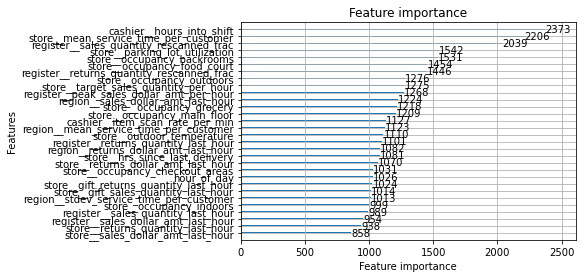

In [16]:
lgb.plot_importance(model,max_num_features=30)

In [17]:
y_pred = model.predict(X)

np.sqrt(mean_squared_error(y, y_pred)) 

99.51994635517919

In [18]:
cros_val = cross_validate(estimator=model,
                          X=X,
                          y=y,
                          scoring='neg_mean_squared_error',
                          cv=10,n_jobs=-1)

In [19]:
np.sqrt(np.abs(cros_val['test_score'].mean())) 

181.3306281980514

In [69]:
target_test = pd.DataFrame(y, columns=[target])

df_pred = pd.DataFrame(y_pred, columns=['target_pred'])

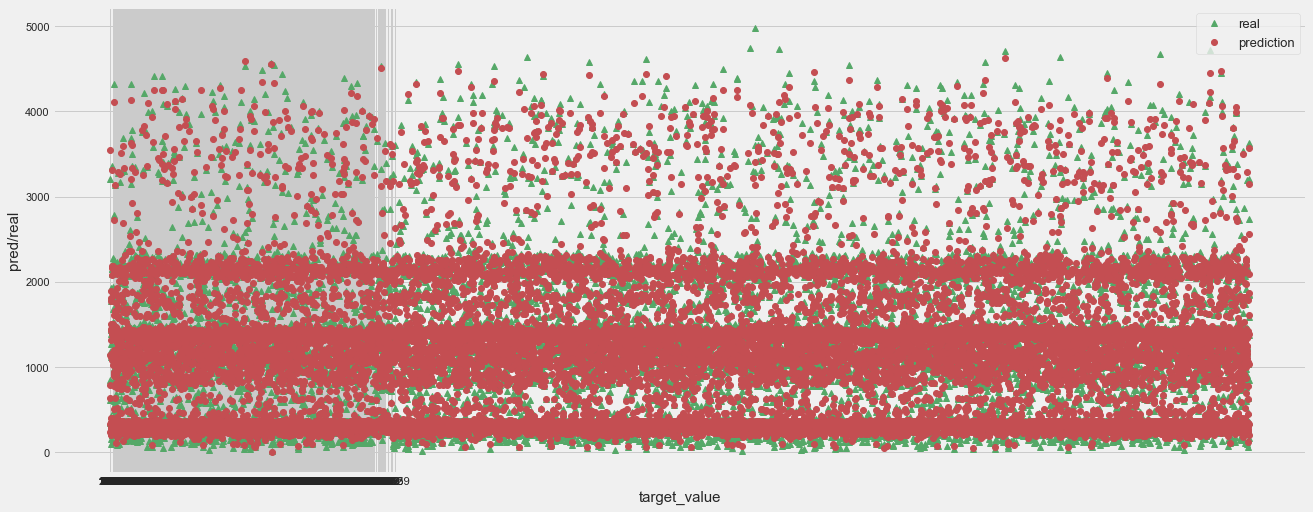

In [70]:
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.xticks(target_test[target], target_test.index.values) 
plt.plot(target_test[target], 'g^', label='real')
plt.xticks(df_pred['target_pred'], df_pred.index.values)
plt.plot(df_pred['target_pred'], 'ro', label='prediction')
plt.xlabel('target_value', fontsize=15)
plt.ylabel('pred/real', fontsize=15)
plt.legend(fontsize=13, loc='upper right')
plt.show()

# Specific values were determined around the parameters determined with OPTUNA.

In [71]:
 model2 = LGBMRegressor(max_bin= 342,learning_rate=0.03,metric='rmse',boosting_type='gbdt',
                       max_depth=15,n_estimators=210,
                       num_leaves= 164,
                       lambda_l1= 3.1160634660701038e-06,
                       lambda_l2= 3.4973557655000995,
                       feature_fraction= 0.5217835994428323,
                       bagging_fraction=0.865952560845951,
                       bagging_freq= 3,
                       min_data_in_leaf= 8,
                       min_child_samples= 36,
                       sub_feature= 0.10405923651355292,
                       sub_row= 0.881213833139655,random_state=17).fit(X,y) 

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.10405923651355292. Current value: feature_fraction=0.10405923651355292
[LightGBM] [Warning] bagging_fraction is set with subsample=1.0, will be overridden by sub_row=0.881213833139655. Current value: bagging_fraction=0.881213833139655
[LightGBM] [Warning] feature_fraction is set=0.5217835994428323, sub_feature=0.10405923651355292 will be ignored. Current value: feature_fraction=0.5217835994428323
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] lambda_l1 is set=3.1160634660701038e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1160634660701038e-06
[LightGBM] [Warning] bagging_fraction is set=0.865952560845951, sub_row=0.881213833139655 will be ignored. Current value: bagging_fraction=0.865952560845951
[LightGBM] [Warning] lambda_l2 is set=3.4973557655000995, reg_lambda=0.0 w

In [57]:
y_pred2 = model2.predict(X)

np.sqrt(mean_squared_error(y, y_pred2))  

101.88674119400498

In [59]:
cros_val2 = cross_validate(estimator=model2,
                          X=X,
                          y=y,
                          scoring='neg_mean_squared_error',
                          cv=10,n_jobs=-1)

In [60]:
np.sqrt(np.abs(cros_val2['test_score'].mean()))  

181.2100697575096

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

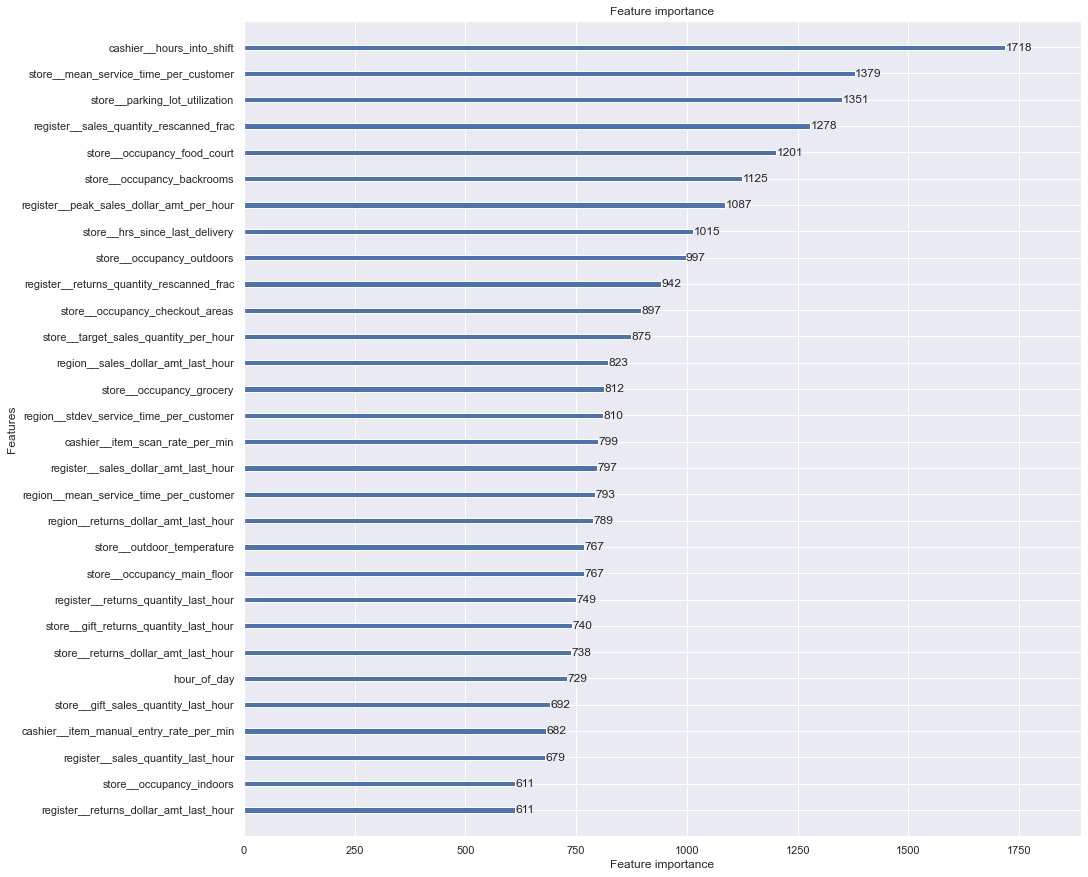

In [62]:
lgb.plot_importance(model2,max_num_features=30)

In [73]:
df_pred2 = pd.DataFrame(y_pred2, columns=['target_pred'])

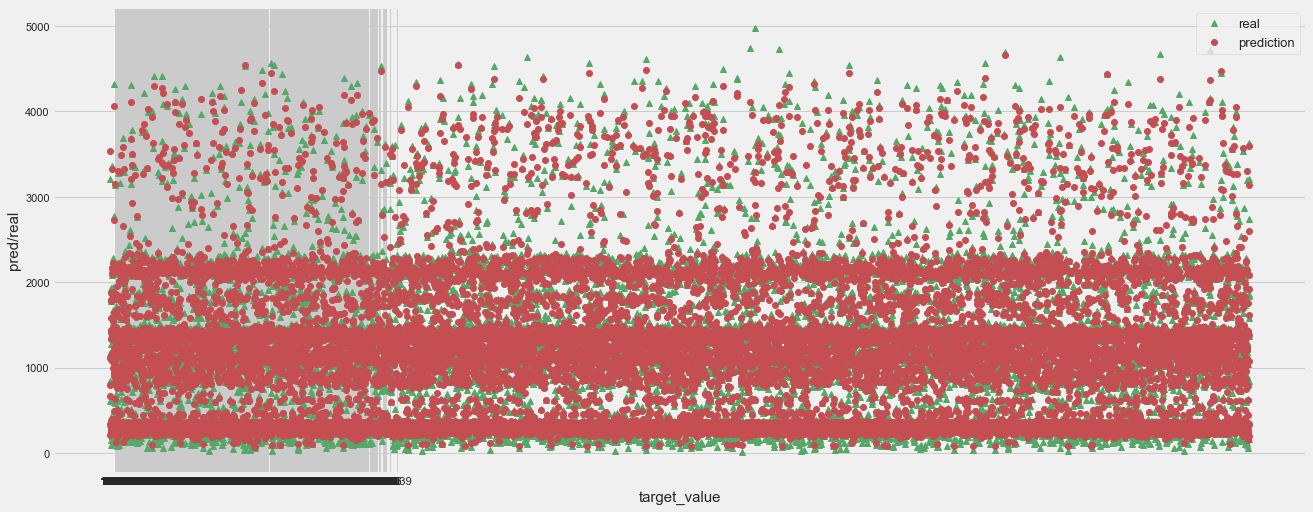

In [74]:
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.xticks(target_test[target], target_test.index.values) 
plt.plot(target_test[target], 'g^', label='real')
plt.xticks(df_pred2['target_pred'], df_pred2.index.values)
plt.plot(df_pred2['target_pred'], 'ro', label='prediction')
plt.xlabel('target_value', fontsize=15)
plt.ylabel('pred/real', fontsize=15)
plt.legend(fontsize=13, loc='upper right')
plt.show()

# Let's include 'region__peak_sales_dollar_amt_per_hour_v2','region__peak_returns_dollar_amt_per_hour_v2' variables in the model

In [48]:
df_train = pd.read_csv('training_dataset.csv')

In [49]:
df_train = Imputer(df_train,['region__peak_sales_dollar_amt_per_hour_v2'])
df_train = Imputer(df_train,['region__peak_returns_dollar_amt_per_hour_v2'])

In [50]:
df_train.loc[((df_train['hour_of_day']>=18)&(df_train['hour_of_day']<=23))|
            ((df_train['hour_of_day']>=0)&(df_train['hour_of_day']<=6)),'part_of_day'] ='night'

df_train.loc[(df_train['hour_of_day']>=7)&(df_train['hour_of_day']<=17),'part_of_day'] ='day'

In [51]:
df_train.drop(['observation_timestamp','observation_id','Unnamed: 0'],axis=1,inplace=True)

In [52]:
cat_col,num_col,cat_but_car=grab_col_names(df_train)

Observations: 18512
Variables: 61
cat_cols: 8
num_cols: 53
cat_but_car: 0
num_but_cat: 5


In [53]:
df_train = one_hot_encoder(df_train,cat_col,True)

In [54]:
X = df_train.drop(target,axis=1)
y = df_train[target]

In [55]:
model2 = LGBMRegressor(max_bin= 342,learning_rate=0.03,metric='rmse',boosting_type='gbdt',
                       max_depth=15,n_estimators=210,
                       num_leaves= 164,
                       lambda_l1= 3.1160634660701038e-06,
                       lambda_l2= 3.4973557655000995,
                       feature_fraction= 0.5217835994428323,
                       bagging_fraction=0.865952560845951,
                       bagging_freq= 3,
                       min_data_in_leaf= 8,
                       min_child_samples= 36,
                       sub_feature= 0.10405923651355292,
                       sub_row= 0.881213833139655,random_state=17).fit(X,y) 

In [56]:
y_pred2 = model2.predict(X)

np.sqrt(mean_squared_error(y, y_pred2))  

102.39564399420502

In [57]:
cros_val2 = cross_validate(estimator=model2,
                          X=X,
                          y=y,
                          scoring='neg_mean_squared_error',
                          cv=10,n_jobs=-1)

In [58]:
np.sqrt(np.abs(cros_val2['test_score'].mean()))  

181.3344260635092

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

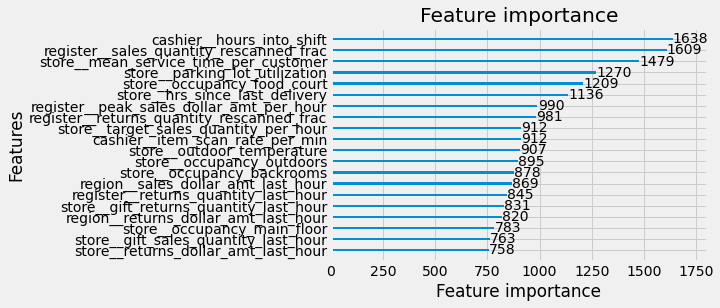

In [78]:
lgb.plot_importance(model2,max_num_features=20)

In [76]:
target_test = pd.DataFrame(y, columns=[target])
df_pred2 = pd.DataFrame(y_pred2, columns=['target_pred'])

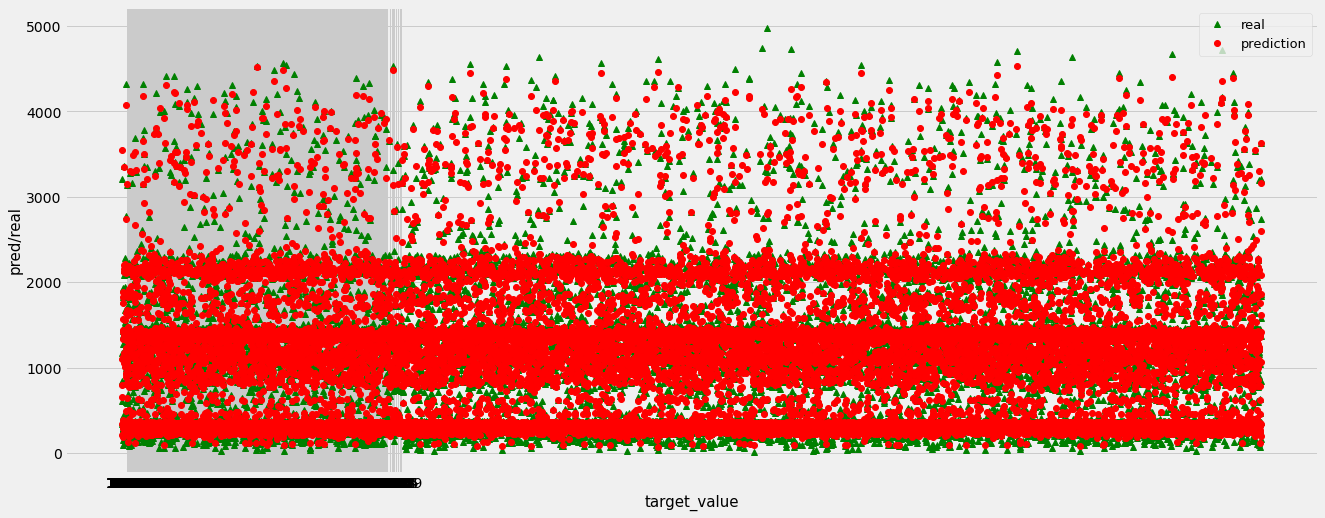

In [77]:
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.xticks(target_test[target], target_test.index.values) 
plt.plot(target_test[target], 'g^', label='real')
plt.xticks(df_pred2['target_pred'], df_pred2.index.values)
plt.plot(df_pred2['target_pred'], 'ro', label='prediction')
plt.xlabel('target_value', fontsize=15)
plt.ylabel('pred/real', fontsize=15)
plt.legend(fontsize=13, loc='upper right')
plt.show()